# Schematic
In this version schematics will be based upon BEST data set

<h1 style='color: yellow'> Pre-amble</h1>

In [1]:
# Standard Library Imports
import os
import sys
from importlib import reload
from functools import partial
from itertools import groupby, cycle

# Third-Party Library Imports
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from typing import Optional, Tuple
import cartopy.crs as ccrs
from statsmodels.distributions.empirical_distribution import ECDF
from matplotlib import cm
from scipy.stats import ks_2samp
import matplotlib.ticker as mticker
# My imports
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts'))
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts', 'src'))

import climate_utils
import plotting_utils
import my_stats
import toe_plots
import toe_calc as toe
import toe_constants as toe_const
import open_data
from toe_constants import PVALUE_THESHOLD1, OVERLAP_THRESHOLD, SN_THRESHOLD1
# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

Matplotlib created a temporary cache directory at /jobfs/136788328.gadi-pbs/matplotlib-ebctg01q because the default path (/home/563/ab2313/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


In [2]:
import matplotlib.patches as patches

In [3]:

# import matplotlib.pylab as pylab
# params = {'axes.labelsize' : 'xx-large', 'legend.fontsize': 'xx-large', 
#           'xtick.labelsize': 'xx-large', 'ytick.labelsize': 'xx-large'}
            
# pylab.rcParams.update(params)

In [4]:
from dask.distributed import Client
client = Client(threads_per_worker=1, memory_limit=None, n_workers=20)
client

 - State start
 -   Scheduler at:     tcp://127.0.0.1:34341
 -   dashboard at:         /proxy/8787/status
 - Registering Worker plugin shuffle
 -         Start Nanny at: 'tcp://127.0.0.1:35869'
 -         Start Nanny at: 'tcp://127.0.0.1:36865'
 -         Start Nanny at: 'tcp://127.0.0.1:44567'
 -         Start Nanny at: 'tcp://127.0.0.1:40455'
 -         Start Nanny at: 'tcp://127.0.0.1:36043'
 -         Start Nanny at: 'tcp://127.0.0.1:39227'
 -         Start Nanny at: 'tcp://127.0.0.1:40383'
 -         Start Nanny at: 'tcp://127.0.0.1:44715'
 -         Start Nanny at: 'tcp://127.0.0.1:36505'
 -         Start Nanny at: 'tcp://127.0.0.1:35587'
 -         Start Nanny at: 'tcp://127.0.0.1:41473'
 -         Start Nanny at: 'tcp://127.0.0.1:43443'
 -         Start Nanny at: 'tcp://127.0.0.1:41873'
 -         Start Nanny at: 'tcp://127.0.0.1:35679'
 -         Start Nanny at: 'tcp://127.0.0.1:37793'
 -         Start Nanny at: 'tcp://127.0.0.1:41069'
 -         Start Nanny at: 'tcp://127.0.0

<Client: 'tcp://127.0.0.1:34341' processes=20 threads=20>

In [5]:
dir(toe)

['ArrayLike',
 'Callable',
 'Enum',
 'List',
 'NamedTuple',
 'Optional',
 'Tuple',
 'Union',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__overlap_helper_function',
 '__overlap_helper_function_base_fitted',
 '__package__',
 '__spec__',
 'anderson_ksamp',
 'caculate_distribution_overlap',
 'calculate_freedman_diaconis_bins',
 'calculate_hellinger_distance',
 'calculate_kde_overlap',
 'combinations',
 'create_kde',
 'create_kde_x_exists',
 'create_x',
 'daskarray',
 'discrete_distribution_overlap',
 'discrete_pdf',
 'farctional_geometric_area',
 'fractional_geometric_area',
 'fractional_geometric_area_optimized',
 'gaussian_kde',
 'get_exceedance_arg',
 'get_permanent_exceedance',
 'get_rel_freq',
 'groupby',
 'hellinger_distance',
 'hellinger_distance_optimized',
 'kruskal',
 'ks_2samp',
 'levene',
 'logger',
 'mannwhitneyu',
 'np',
 'os',
 'partial',
 'pd',
 'perkins_skill_score',
 'perkins_skill_score_base_bins',
 'rel_freq',
 'remove_nans',


In [6]:
xr.set_options(display_expand_attrs=False)
xr.set_options(display_expand_data=False)

<h1 style='color: yellow'> Opening Data</h1>

In [7]:
'/g/data/w40/ab2313/time_of_emergence/best'

'/g/data/w40/ab2313/time_of_emergence/best'

In [8]:
ROOT_DIR = '/g/data/w40/ab2313/time_of_emergence'

os.listdir(os.path.join(ROOT_DIR, 'best'))

['Complete_TAVG_LatLong1.nc',
 'best_mask_old.zarr',
 'best_mask.zarr',
 'Land_and_Ocean_LatLong1_time_chunk.zarr',
 'Land_and_Ocean_LatLong1.zarr',
 'Land_and_Ocean_LatLong1.nc',
 '.ipynb_checkpoints',
 'Complete_TAVG_Daily_EqualArea.nc']

In [9]:
reload(open_data)

<module 'open_data' from '/home/563/ab2313/Documents/time_of_emergene_drafts/src/open_data.py'>

In [10]:
best_ds = open_data.open_best()

Opening best dataset from - /g/data/w40/ab2313/time_of_emergence/best/Land_and_Ocean_LatLong1_time_chunk.zarr
  -- overriding time to use cftime
  -- resampling to yearly mean


In [11]:
best_ds_smean = climate_utils.weighted_lat_lon_mean(best_ds)

In [12]:
# Only 43MB - load into memory
best_ds_smean = best_ds_smean.compute()

In [13]:
# Create a data set for the base period used as the pre-industrial climate 
base_period_tuple = (1850, 1900)#(1900, 1931)
best_ds_smean = best_ds_smean.sel(time=best_ds_smean.time.dt.year>=base_period_tuple[0])
best_ds_smean

<xarray.DataArray 'temperature' (time: 175)> Size: 700B
-0.3587 -0.2924 -0.2442 -0.26 -0.2723 ... 1.025 0.8704 0.9127 1.204 1.273
Coordinates:
  * time     (time) object 1kB 1850-12-31 00:00:00 ... 2024-12-31 00:00:00

In [14]:
base_period_ds = best_ds_smean.where(best_ds_smean.time.dt.year.isin(np.arange(*base_period_tuple)), drop=True)
base_period_ds

<xarray.DataArray 'temperature' (time: 50)> Size: 200B
-0.3587 -0.2924 -0.2442 -0.26 -0.2723 ... -0.2842 -0.193 -0.1842 -0.3879 -0.2289
Coordinates:
  * time     (time) object 400B 1850-12-31 00:00:00 ... 1899-12-31 00:00:00

In [15]:
base_period_ds_average = base_period_ds.mean(dim='time')
base_period_ds_average

<xarray.DataArray 'temperature' ()> Size: 4B
-0.2854

In [16]:
# Resetting the anomlies to 1850
best_ds_smean = best_ds_smean - base_period_ds.mean(dim='time')
base_period_ds = base_period_ds - base_period_ds.mean(dim='time')

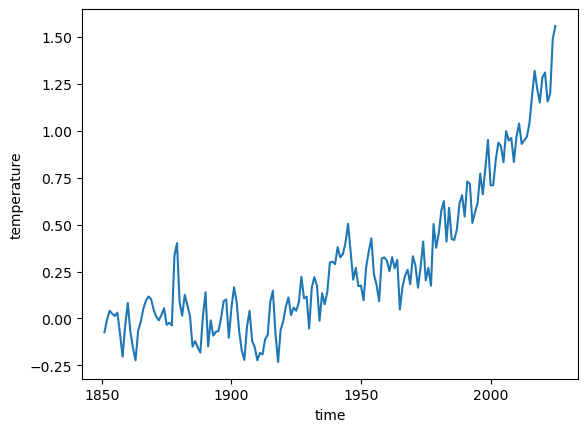

In [17]:
best_ds_smean.plot()

<h1 style='color: yellow'> Calculations</h1>

In [18]:
window = 20

<h2 style='color: cyan'> Signal-to-Noise </h2>

In [19]:
# Lowess
ds_best_lowess = my_stats.trend_fit(best_ds_smean, 'LOWESS', lowess_window=41)#method='POLYNOMIAL', order=4)#

# Rolling average
best_ds_rolling_20 = best_ds_smean.rolling(time=20, center=True).mean()

# Polynomial
best_ds_poly3 = xr.zeros_like(best_ds_smean)+my_stats.polynomial_fit(best_ds_smean, order=3)
best_ds_poly4 = xr.zeros_like(best_ds_smean)+my_stats.polynomial_fit(best_ds_smean, order=4)

In [20]:
best_ds_anom_signal = best_ds_smean.copy(deep=True)

In [21]:
best_ds_rolling_20.name = 's_rolling'
ds_best_lowess.name = 's_lowess'
best_ds_poly4.name = 's_poly4'
# best_ds_anom_signal.name = 's_anom'

In [22]:
# Note: SN is just lowess (this is here becuase of technical det)
ds_best_smooth = xr.concat([best_ds_rolling_20, best_ds_poly4, ds_best_lowess, ], #best_ds_anom_signal
                           pd.Index(['sn_rolling', 'sn_poly4', 'sn'], name='method')) #, 'sn_anom'
ds_best_smooth

<xarray.DataArray 's_rolling' (method: 3, time: 175)> Size: 4kB
nan nan nan nan nan nan nan nan ... 1.212 1.235 1.259 1.283 1.307 1.331 1.356
Coordinates:
  * time     (time) object 1kB 1850-12-31 00:00:00 ... 2024-12-31 00:00:00
  * method   (method) object 24B 'sn_rolling' 'sn_poly4' 'sn'

In [23]:
ds_best_no_trend = best_ds_smean - ds_best_smooth
ds_best_no_trend

<xarray.DataArray (time: 175, method: 3)> Size: 4kB
nan -0.09722 -0.036 nan -0.02642 0.02787 ... nan 0.1126 0.1584 nan 0.1476 0.2027
Coordinates:
  * time     (time) object 1kB 1850-12-31 00:00:00 ... 2024-12-31 00:00:00
  * method   (method) object 24B 'sn_rolling' 'sn_poly4' 'sn'

In [24]:
ds_best_noise = ds_best_no_trend.std(dim='time')

In [25]:
ds_best_sn_multi = ds_best_smooth/ds_best_noise

In [26]:
# Definind the S/N ratio as just the anomalies divided by the std of the base period
best_ds_anom_sn = best_ds_smean/best_ds_smean.isel(time=slice(0,50)).std()
best_ds_anom_sn.name = 'sn_anom'
best_ds_anom_sn = best_ds_anom_sn.expand_dims(dim={'method':['sn_anom']})

In [27]:
ds_best_sn_multi = xr.concat([ds_best_sn_multi, best_ds_anom_sn], dim='method')

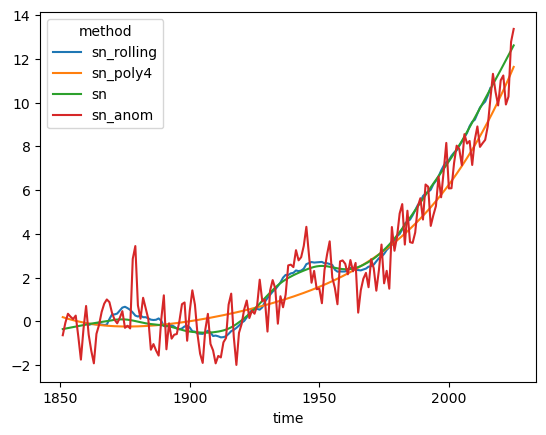

In [28]:
ds_best_sn_multi.plot(hue='method');

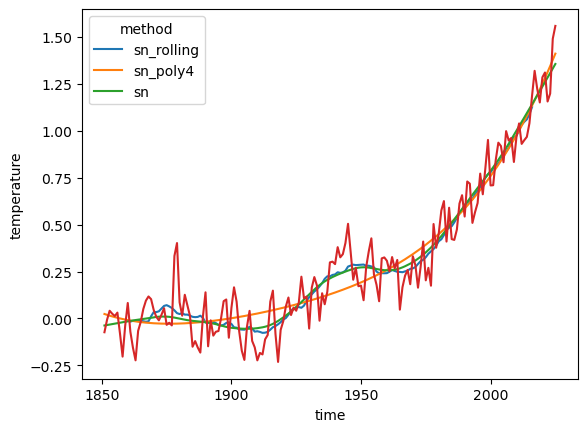

In [29]:
ds_best_smooth.plot(hue='method');
best_ds_smean.plot()

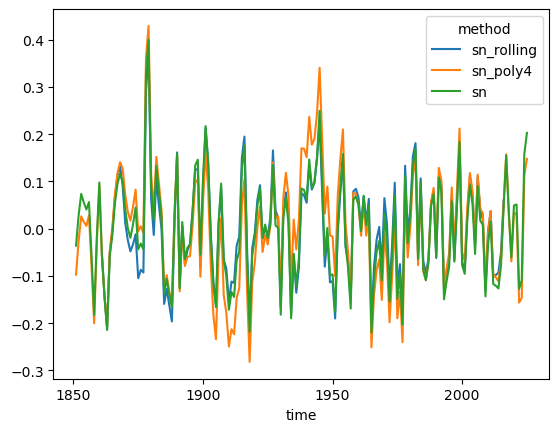

In [30]:
ds_best_no_trend.plot(hue='method');

In [31]:
# LEGACY 
ds_best_lowess_signal = ds_best_lowess#- base_period_ds_average
# Note - you have to use loc as method is a keyword lol
ds_best_sn = ds_best_sn_multi.loc[{'method':'sn'}]#ds_best_lowess_signal/noise_ds

In [32]:
ds_best_sn

<xarray.DataArray (time: 175)> Size: 1kB
-0.347 -0.325 -0.3025 -0.2798 -0.2567 -0.2334 ... 11.71 11.94 12.16 12.38 12.61
Coordinates:
  * time     (time) object 1kB 1850-12-31 00:00:00 ... 2024-12-31 00:00:00
    method   <U2 8B 'sn'

<h2 style='color: cyan'>  p-value and overlap </h2>

In [33]:
import toe_data_analysis

In [34]:
# This version is better
ks_ds = toe.stats_test_1d_xr(best_ds_smean, window=window, stats_func=toe.return_ks_pvalue)
ttest_ds = toe.stats_test_1d_xr(best_ds_smean, window=window, stats_func=toe.return_ttest_pvalue)
anderson_ds = toe.stats_test_1d_xr(best_ds_smean, window=window, stats_func=toe.return_anderson_pvalue)

In [35]:
bins = toe.calculate_freedman_diaconis_bins(best_ds_smean.values)
bins

p75=0.46295371651649475, p25=0.01198674738407135, iqr=0.4509669691324234, length=175


array([-0.39263588, -0.2313875 , -0.07013911,  0.09110928,  0.25235767,
        0.41360605,  0.57485444,  0.73610283,  0.89735121,  1.0585996 ,
        1.21984799,  1.38109638,  1.54234476,  1.70359315])

In [36]:
frac_geom_func = partial(toe.fractional_geometric_area, method_kwargs=dict(bw_method=0.2))
frac_geom_ds = toe.stats_test_1d_xr(best_ds_smean, window=30, stats_func=frac_geom_func)
hd_ds = toe.stats_test_1d_xr(best_ds_smean, window=30, stats_func=toe.hellinger_distance)

perkins_ds = toe.stats_test_1d_xr(best_ds_smean, window=30, stats_func=partial(toe.perkins_skill_score, bins=bins));

<h2 style='color: cyan'>ToENN</h2>

In [37]:
base_max_value = base_period_ds.max().values.item()
base_max_value

0.40173736214637756

In [38]:
new_normal_ds = best_ds_rolling_20 > base_max_value
new_normal_ds

<xarray.DataArray 's_rolling' (time: 175)> Size: 175B
False False False False False False ... False False False False False False
Coordinates:
  * time     (time) object 1kB 1850-12-31 00:00:00 ... 2024-12-31 00:00:00

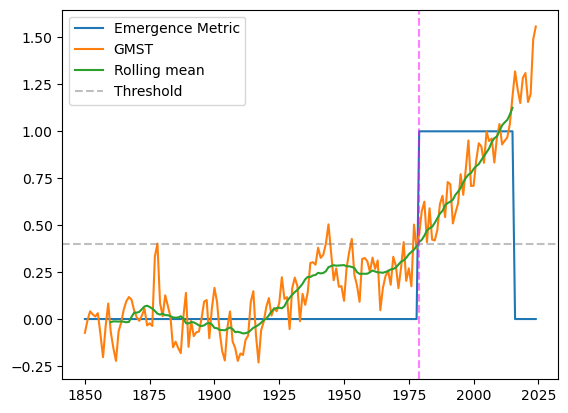

In [39]:
fig, ax = plt.subplots(1, 1)
ax.plot(new_normal_ds.time.dt.year.values, new_normal_ds.values, label='Emergence Metric')
ax.plot(new_normal_ds.time.dt.year.values,best_ds_smean.values, label='GMST')
ax.plot(new_normal_ds.time.dt.year.values, best_ds_rolling_20.values, label='Rolling mean')
ax.axhline(base_max_value, linestyle='--', color='grey', alpha=0.5, label='Threshold')
ax.axvline(1979, linestyle='--', color='magenta', alpha=0.5)
ax.legend()


<h2 style='color: cyan'> ToE </h2>

In [40]:
ds_best_sn.name = 'sn'
ks_ds.name = 'ks'
ttest_ds.name = 'ttest'
anderson_ds.name = 'anderson'
perkins_ds.name = 'perkins'
frac_geom_ds.name = 'frac'
hd_ds.name = 'hd'
new_normal_ds.name = 'nn'

In [41]:
# Set long name attributes for each variable
ds_best_sn.attrs['long_name'] = 'Signal to Noise Ratio'
ks_ds.attrs['long_name'] = 'Kolmogorov-Smirnov'
ttest_ds.attrs['long_name'] = 'T-Test'
anderson_ds.attrs['long_name'] = 'Anderson-Darling'
perkins_ds.attrs['long_name'] = 'Perkins Skill Score'
frac_geom_ds.attrs['long_name'] = 'Fractional Geometric Area'
hd_ds.attrs['long_name'] = 'Hellinger Distance'
new_normal_ds.attrs['long_name']  = 'New Normal'

In [42]:
# toe_metrics_ds = xr.merge([ks_ds, ttest_ds, anderson_ds, ds_best_sn, perkins_ds, frac_geom_ds])
toe_metrics_ds = xr.merge([ks_ds, ttest_ds, anderson_ds, ds_best_sn_multi.to_dataset(dim='method'),
                           perkins_ds, frac_geom_ds, hd_ds, new_normal_ds])
toe_metrics_ds = toe_metrics_ds.isel(time=slice(None, -int(window/2))) #int(window/2)
toe_metrics_ds = toe_metrics_ds.compute()
toe_metrics_ds

<xarray.Dataset> Size: 15kB
Dimensions:     (time: 165)
Coordinates:
  * time        (time) object 1kB 1850-12-31 00:00:00 ... 2014-12-31 00:00:00
Data variables:
    ks          (time) float64 1kB nan nan nan ... 1.235e-17 1.235e-17 1.235e-17
    ttest       (time) float64 1kB nan nan nan ... 1.298e-41 7.159e-42 6.405e-41
    anderson    (time) float64 1kB nan nan nan nan ... 0.001 0.001 0.001 0.001
    sn_rolling  (time) float64 1kB nan nan nan nan ... 9.773 9.92 10.04 10.31
    sn_poly4    (time) float64 1kB 0.197 0.1595 0.1241 ... 8.676 8.894 9.116
    sn          (time) float64 1kB -0.347 -0.325 -0.3025 ... 9.958 10.18 10.39
    sn_anom     (time) float64 1kB -0.6287 -0.06055 0.3528 ... 8.144 8.296 8.919
    perkins     (time) float64 1kB nan nan nan nan nan ... nan nan nan nan nan
    frac        (time) float64 1kB nan nan nan nan nan ... nan nan nan nan nan
    hd          (time) float64 1kB nan nan nan nan nan ... nan nan nan nan nan
    nn          (time) bool 165B False False False False ... True True True True
Attributes: (1)

In [43]:
print(f'{OVERLAP_THRESHOLD=}, {PVALUE_THESHOLD1=}')

OVERLAP_THRESHOLD=62, PVALUE_THESHOLD1=0.01


In [44]:
# Find the year of permanent exceedance
sn_toe_ds = toe.get_permanent_exceedance(np.abs(toe_metrics_ds[['sn_poly4', 'sn', 'sn_rolling', 'sn_anom']]), threshold=1, 
                                         comparison_func=np.greater_equal)

# None can be used if the values are already bool
nn_toe_ds = toe.get_permanent_exceedance(toe_metrics_ds['nn'], threshold=None, comparison_func=None)
# sn_toe_ds = toe.get_permanent_exceedance(np.abs(toe_metrics_ds['sn']), threshold=1, comparison_func=np.greater_equal)

ks_toe_ds = toe.get_permanent_exceedance(toe_metrics_ds['ks'], threshold=PVALUE_THESHOLD1, comparison_func=np.less)
ttest_toe_ds = toe.get_permanent_exceedance(toe_metrics_ds['ttest'], threshold=PVALUE_THESHOLD1, comparison_func=np.less)
anderson_toe_ds = toe.get_permanent_exceedance(toe_metrics_ds['anderson'], threshold=PVALUE_THESHOLD1, comparison_func=np.less)
# # The distribution overlap methods
perkins_toe_ds = toe.get_permanent_exceedance(perkins_ds, threshold=OVERLAP_THRESHOLD, comparison_func=np.less_equal)
frac_geom_toe_ds = toe.get_permanent_exceedance(frac_geom_ds, threshold=OVERLAP_THRESHOLD, comparison_func=np.less_equal)
hd_toe_ds = toe.get_permanent_exceedance(hd_ds, threshold=OVERLAP_THRESHOLD, comparison_func=np.greater_equal)

toe_ds = xr.merge([sn_toe_ds, ks_toe_ds,ttest_toe_ds , anderson_toe_ds, perkins_toe_ds, frac_geom_toe_ds, hd_toe_ds, nn_toe_ds])
# If have emerged too late, it has not emerged
toe_ds = xr.where(toe_ds<2015, toe_ds, np.nan)

In [45]:
toe_ds

<xarray.Dataset> Size: 88B
Dimensions:     ()
Data variables:
    sn_poly4    float64 8B 1.936e+03
    sn          float64 8B 1.928e+03
    sn_rolling  float64 8B 1.929e+03
    sn_anom     float64 8B 1.965e+03
    ks          float64 8B 1.928e+03
    ttest       float64 8B 1.928e+03
    anderson    float64 8B 1.927e+03
    perkins     float64 8B 1.928e+03
    frac        float64 8B 1.928e+03
    hd          float64 8B 1.945e+03
    nn          float64 8B 1.979e+03

<h1 style='color: yellow'> Plotting</h1> 

<h2 style='color: cyan'> GMST Plot</h2>

In [46]:
single_sn_list = ['ks', 'ttest', 'anderson', 'sn', 'perkins', 'frac', 'hd']

In [47]:
reload(toe_plots)

<module 'toe_plots' from '/home/563/ab2313/Documents/time_of_emergene_drafts/src/toe_plots.py'>

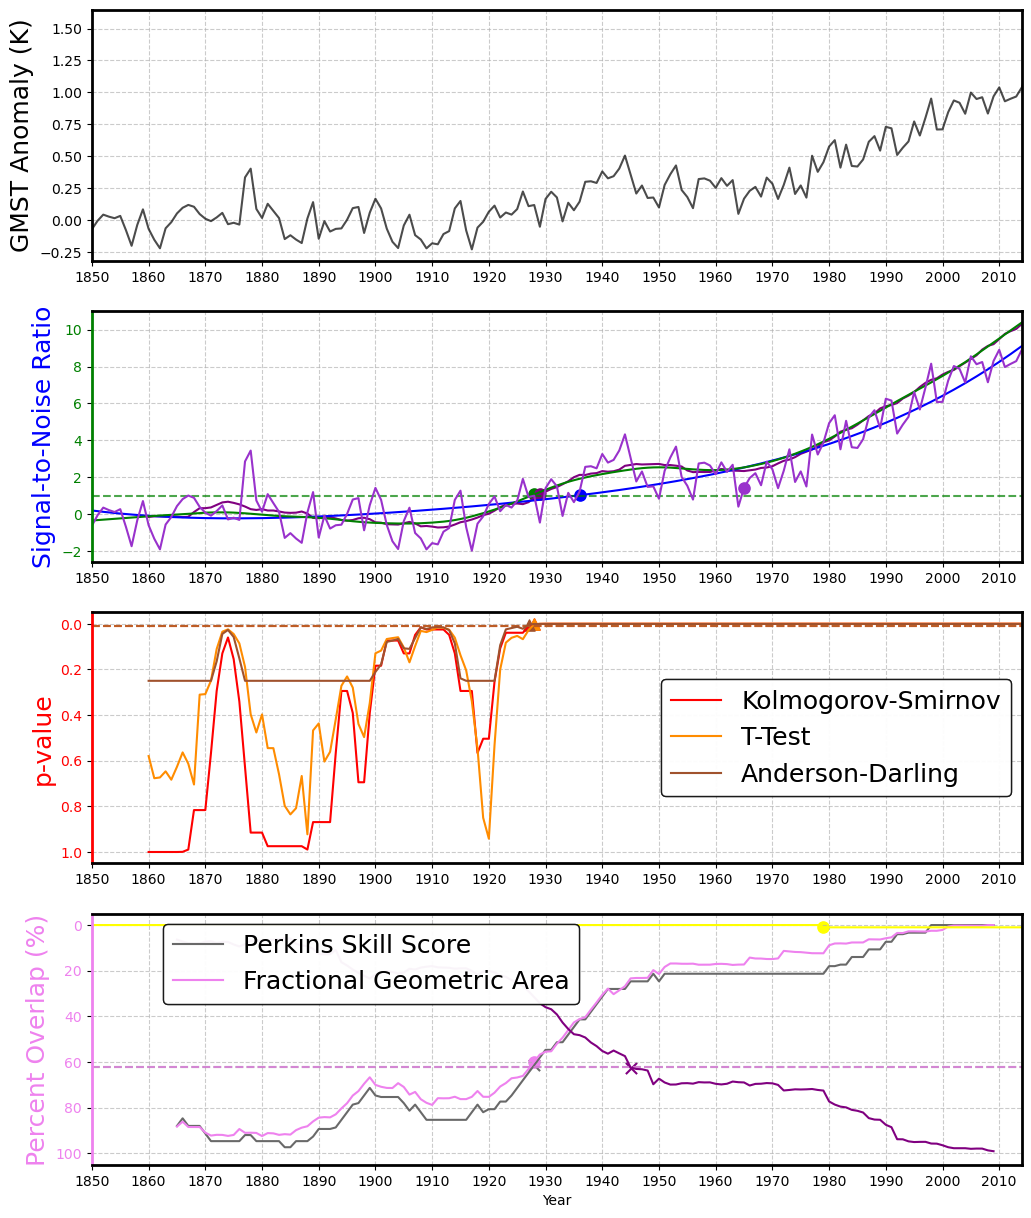

In [48]:
fig, gs, axes = toe_plots.plot_multiseries_with_pvalues(
    toe_metrics_ds,
    toe_ds,
    best_ds_smean,
    labels={'ylabel_bottom': 'GMST Anomaly (K)'},
    return_figure=True
    )

In [49]:
reload(toe_plots)
reload(toe_const)

<module 'toe_constants' from '/home/563/ab2313/Documents/time_of_emergene_drafts/src/toe_constants.py'>

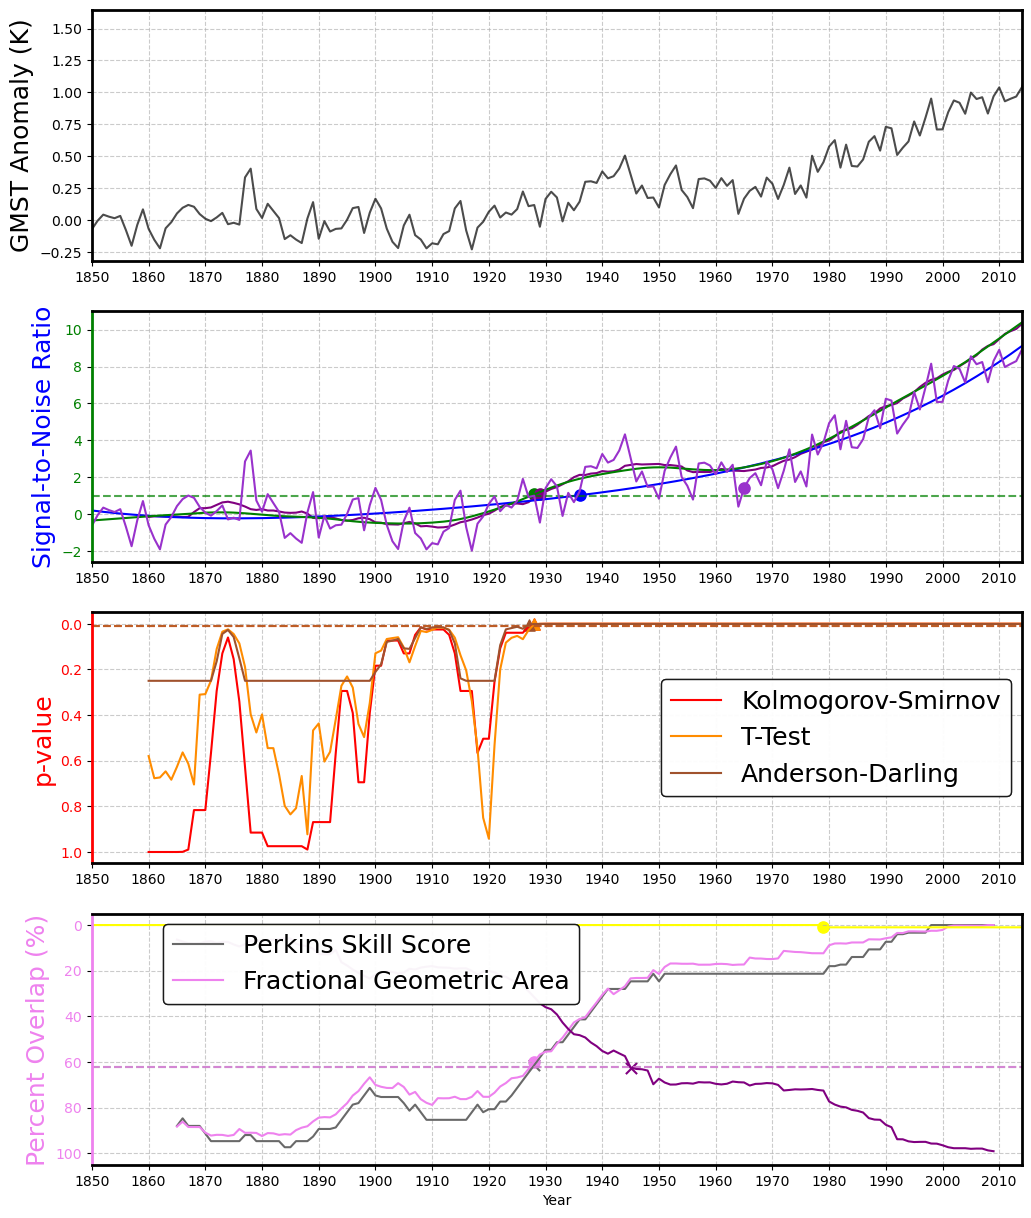

In [50]:
fig, gs, axes = toe_plots.plot_multiseries_with_pvalues(
    toe_metrics_ds,
    toe_ds,
    best_ds_smean,
    labels={'ylabel_bottom': 'GMST Anomaly (K)'},
    return_figure=True
    )

# for emergence_test in list(toe_ds.data_vars):
#     toe_st = toe_ds[emergence_test].values.item()
#     xval_emergence = toe_metrics_ds.time.values[toe_metrics_ds.time.dt.year.values==toe_st].item()
#     axes[0].axvline(xval_emergence, color= toe_plots.TEST_PLOT_DICT[emergence_test]['color'], 
#               linewidth=3)

In [51]:
test_subset = ['ks', 'sn', 'frac']

In [52]:
toe_ds[test_subset].to_array().values

array([1928., 1928., 1928.])

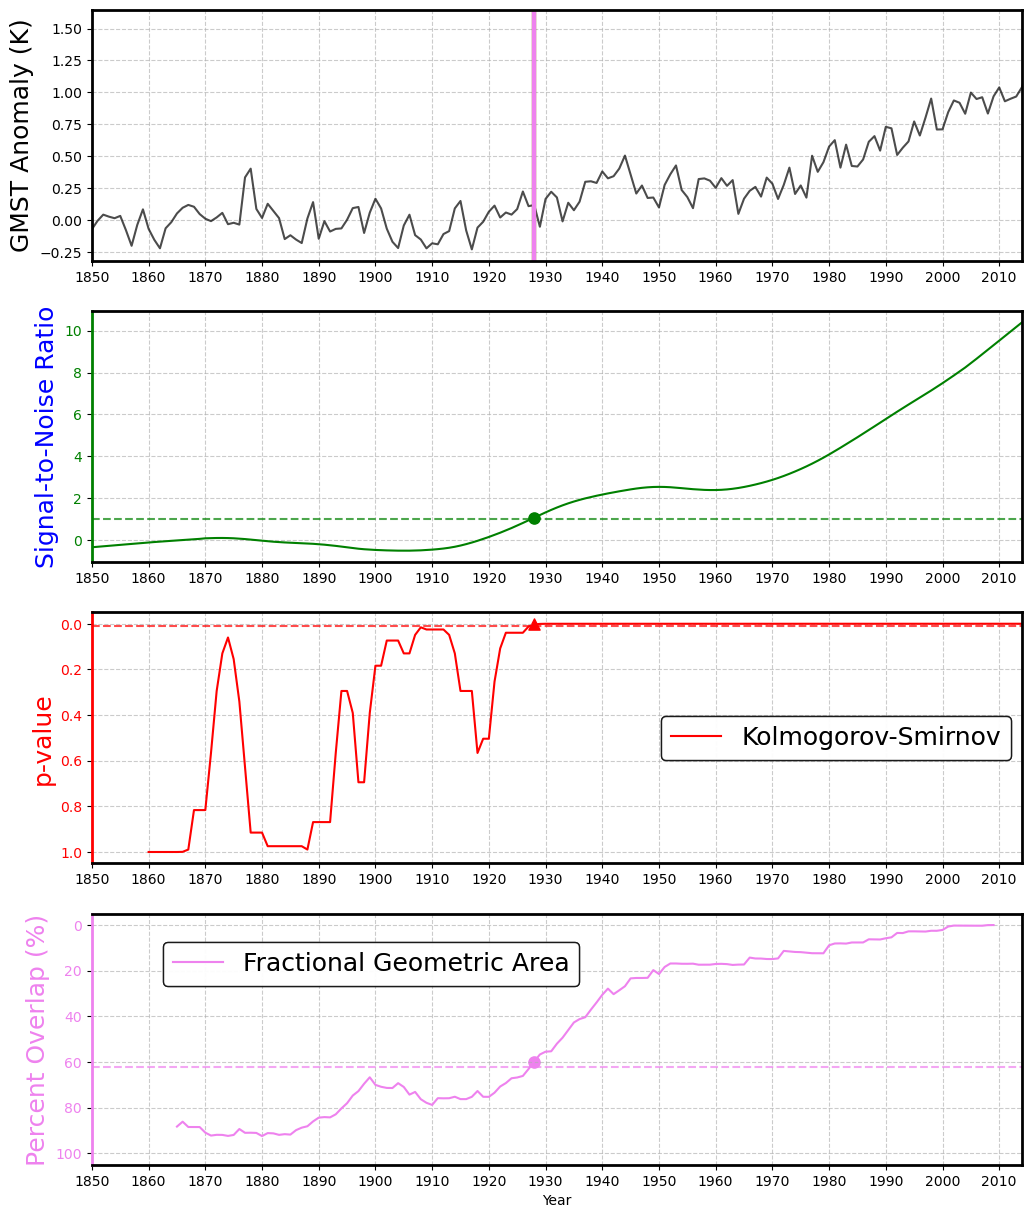

In [53]:
reload(toe_plots)
fig, gs, axes = toe_plots.plot_multiseries_with_pvalues(
    toe_metrics_ds[test_subset],
    toe_ds[test_subset],
    best_ds_smean,
    labels={'ylabel_bottom': 'GMST Anomaly (K)'},
    return_figure=True
    )

for emergence_test in test_subset:
    toe_st = toe_ds[emergence_test].values.item()
    xval_emergence = toe_metrics_ds.time.values[toe_metrics_ds.time.dt.year.values==toe_st].item()
    axes[0].axvline(xval_emergence, color= toe_plots.TEST_PLOT_DICT[emergence_test]['color'], 
              linewidth=3)

<h2 style='color: cyan'> S/N Ratio</h2>

In [54]:
central_year  = 1940
period_of_interest_ds = best_ds_smean.sel(time=best_ds_smean.time.dt.year.isin(np.arange(central_year-20, central_year+21)))

In [55]:
bins = np.arange(-0.5, 0.6, .03)

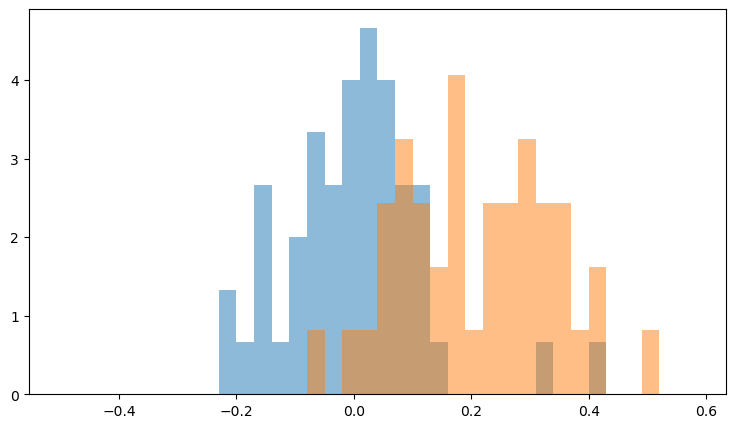

In [56]:
fig, ax  = plt.subplots(figsize=(9, 5))


# base_period_ds.plot(ax=ax)
# period_of_interest_ds.plot(ax=ax)
ax.hist(base_period_ds.values, bins=bins, density=True, alpha=0.5, label='base perdiod');
ax.hist(period_of_interest_ds.values, bins=bins, density=True, alpha=0.5, label='period of interest');
# ax.legend(ncol=1)

# axes_bottom[1].hist(base_period_ds.values, cumulative=True, alpha=0.5);
# axes_bottom[1].hist(period_of_interest_ds.values, cumulative=True, alpha=0.5);

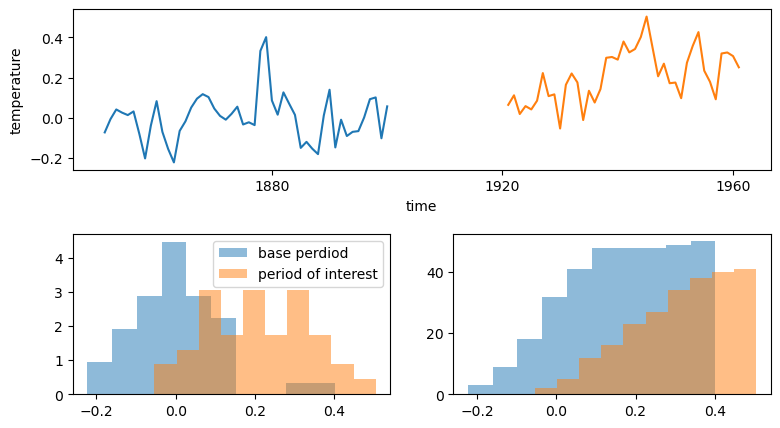

In [57]:
fig  = plt.figure(figsize=(9, 5))
gs = gridspec.GridSpec(2, 2, hspace=0.4)
ax_top = fig.add_subplot(gs[0, :])
axes_bottom = [fig.add_subplot(gs[1, i]) for i in [0, 1]]

base_period_ds.plot(ax=ax_top)
period_of_interest_ds.plot(ax=ax_top)
axes_bottom[0].hist(base_period_ds.values, density=True, alpha=0.5, label='base perdiod');
axes_bottom[0].hist(period_of_interest_ds.values, density=True, alpha=0.5, label='period of interest');
axes_bottom[0].legend(ncol=1)

axes_bottom[1].hist(base_period_ds.values, cumulative=True, alpha=0.5);
axes_bottom[1].hist(period_of_interest_ds.values, cumulative=True, alpha=0.5);

In [58]:
ds_best_sn

<xarray.DataArray 'sn' (time: 175)> Size: 1kB
-0.347 -0.325 -0.3025 -0.2798 -0.2567 -0.2334 ... 11.71 11.94 12.16 12.38 12.61
Coordinates:
  * time     (time) object 1kB 1850-12-31 00:00:00 ... 2024-12-31 00:00:00
    method   <U2 8B 'sn'
Attributes: (1)

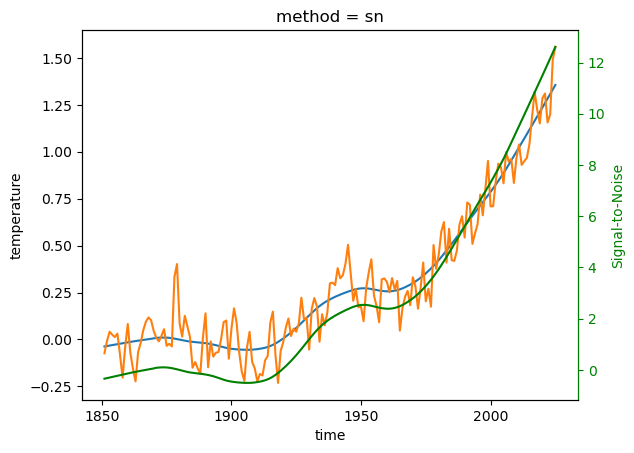

In [59]:
fig, ax = plt.subplots()
ax_twinx = ax.twinx()
ds_best_lowess.plot(ax=ax)
best_ds_smean.plot(ax=ax)
ds_best_sn.plot(ax=ax_twinx, color='green')

ax_twinx.set_ylabel('Signal-to-Noise', color='green')
ax_twinx.tick_params(axis='y', color='green', labelcolor='green')
ax_twinx.spines['right'].set_color('green')

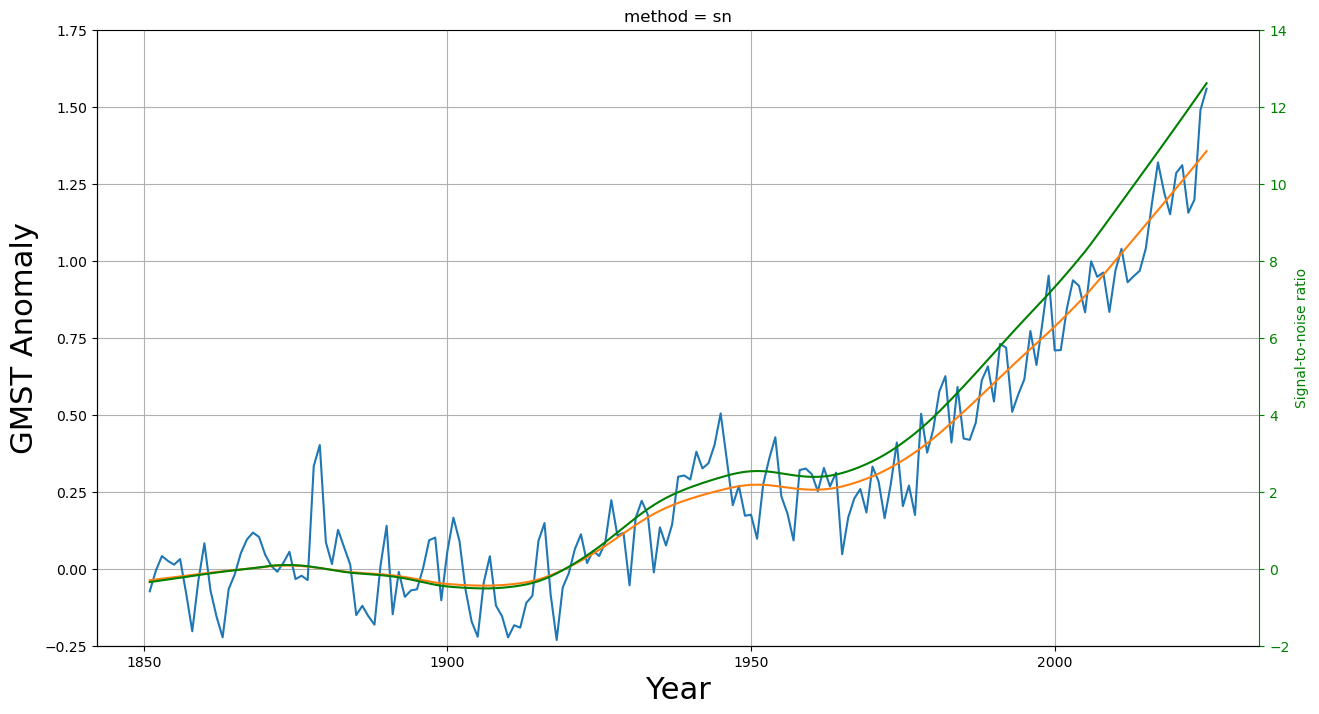

In [60]:
fig, ax = plt.subplots(figsize=(15, 8))
best_ds_smean.plot(ax=ax)
ds_best_lowess.plot(ax=ax)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('GMST Anomaly', fontsize=22)
ax.set_xlabel('Year', fontsize=22)

ax_twinx = ax.twinx()


ds_best_sn.plot(ax=ax_twinx, color='green')

ax_twinx.set_ylabel('Signal-to-noise ratio', color='green')
ax_twinx.tick_params(axis='y', color='green', labelcolor='green')
ax_twinx.spines['right'].set_color('green')

ax.set_ylim(-0.25, 1.75)
ax1 = ax
ax2 = ax_twinx
ax2.set_ylim(-2,14)
ax1.set_yticks(np.linspace(ax1.get_ybound()[0], ax1.get_ybound()[1], 9))
ax2.set_yticks(np.linspace(ax2.get_ybound()[0], ax2.get_ybound()[1], 9))

ax.grid(True)


In [61]:
best_ds_smean.time[best_ds_smean.time.dt.year == 1935].values

array([cftime.DatetimeGregorian(1935, 12, 31, 0, 0, 0, 0, has_year_zero=False)],
      dtype=object)

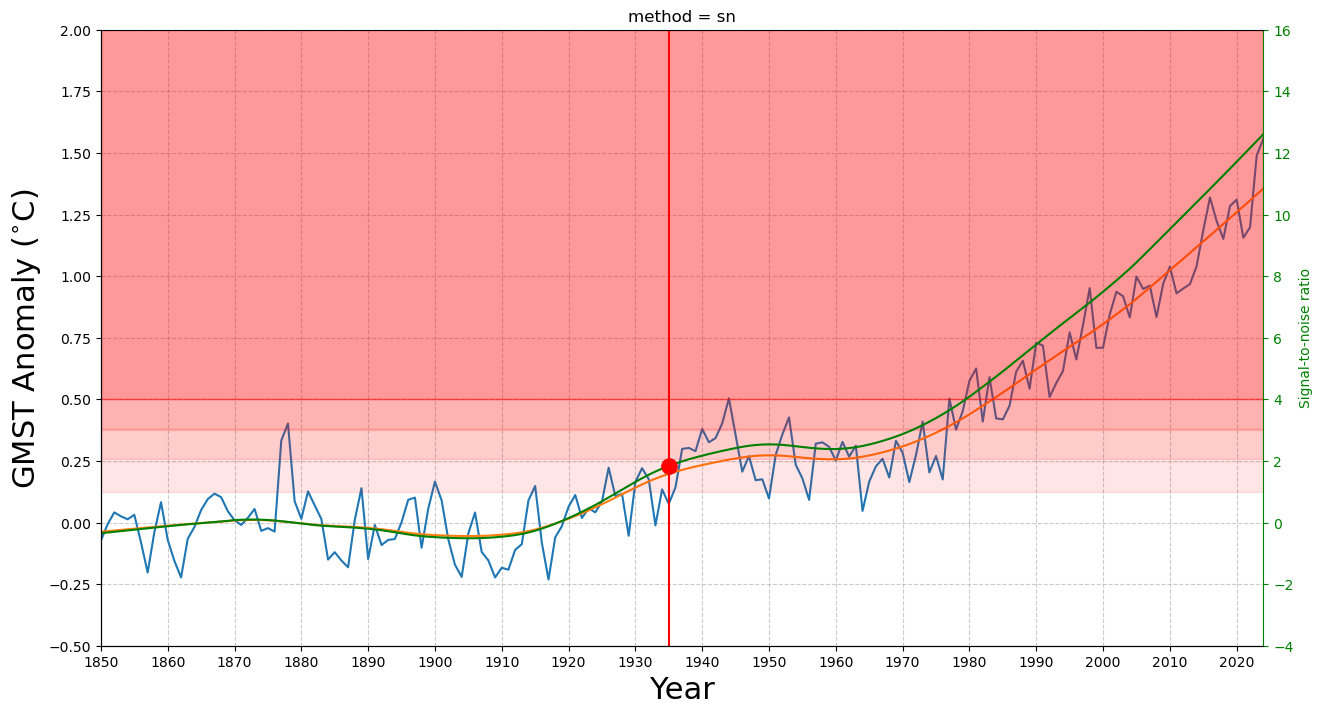

In [62]:
fig, ax = plt.subplots(figsize=(15, 8))
time = best_ds_smean.time.values
best_ds_smean.plot(ax=ax)
ds_best_lowess.plot(ax=ax)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('GMST Anomaly ($^{\circ}$C)', fontsize=22)
ax.set_xlabel('Year', fontsize=22)

ax.grid(True, linestyle='--', alpha=0.65)
ax.set_xlim(*np.take(ds_best_sn.time.values,[0, -1]))
ax.set_ylim(-0.5, 2)

tick_locations = list(filter(lambda t: t.year % 10 == 0, time))
ax.set_xticks(tick_locations);
ax.set_xticklabels(list(map(lambda t:t.year, tick_locations)));


#### Phase 2
ax_twinx = ax.twinx()

ds_best_sn.plot(ax=ax_twinx, color='green')


ax_twinx.set_ylabel('Signal-to-noise ratio', color='green')
ax_twinx.tick_params(axis='y', color='green', labelcolor='green')
ax_twinx.spines['right'].set_color('green')


ax_twinx.set_ylim(-4,16);
ax.set_yticks(np.linspace(ax.get_ybound()[0], ax.get_ybound()[1], 11));
ax_twinx.set_yticks(np.linspace(ax_twinx.get_ybound()[0], ax_twinx.get_ybound()[1], 11));

#### Phase 3

ax_twinx.axhspan(1, 2, color='red', alpha=0.1)
ax_twinx.axhspan(2.05, 3, color='red', alpha=0.2)
ax_twinx.axhspan(3.05, 4, color='red', alpha=0.3)
ax_twinx.axhspan(4., 16, color='red', alpha=0.4)


ax_twinx.scatter(ds_best_sn.time[ds_best_sn.time.dt.year == 1935].values[0], ds_best_sn[ds_best_sn.time.dt.year == 1935].values[0], 
           s=120, color='red', zorder=1000)

ax_twinx.axvline(ds_best_sn.time[ds_best_sn.time.dt.year == 1935].values[0], color='r')

(-54422.0, 9131.0)

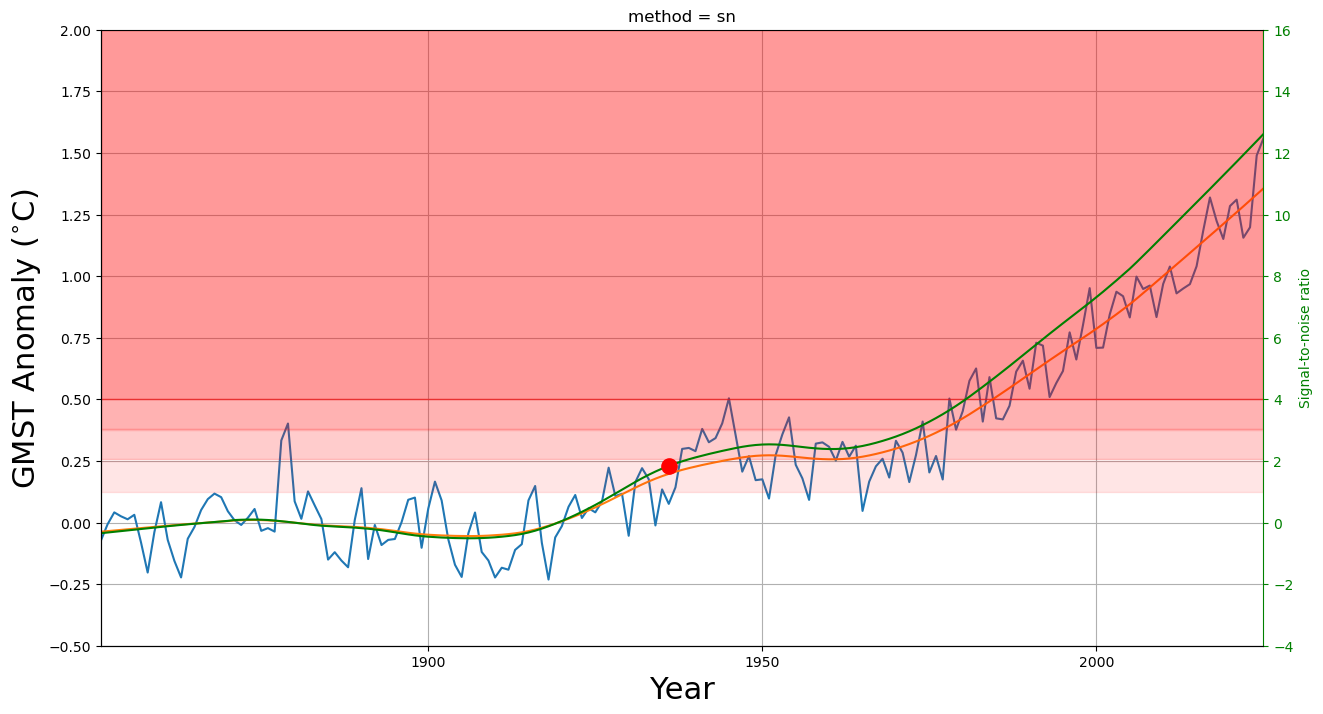

In [63]:
fig, ax = plt.subplots(figsize=(15, 8))

best_ds_smean.plot(ax=ax)
ds_best_lowess.plot(ax=ax)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('GMST Anomaly ($^{\circ}$C)', fontsize=22)  # Corrected axis label
ax.set_xlabel('Year', fontsize=22)

ax_twinx = ax.twinx()

ds_best_sn.plot(ax=ax_twinx, color='green')

ax_twinx.set_ylabel('Signal-to-noise ratio', color='green')
ax_twinx.tick_params(axis='y', color='green', labelcolor='green')
ax_twinx.spines['right'].set_color('green')

ax.set_ylim(-0.5, 2)

ax1 = ax
ax2 = ax_twinx
# ax2.set_ylim(-2,14)
ax2.set_ylim(-4,16)

ax1.set_yticks(np.linspace(ax1.get_ybound()[0], ax1.get_ybound()[1], 11))
ax2.set_yticks(np.linspace(ax2.get_ybound()[0], ax2.get_ybound()[1], 11))

ax2.axhspan(1, 2, color='red', alpha=0.1)
ax2.axhspan(2.05, 3, color='red', alpha=0.2)
ax2.axhspan(3.05, 4, color='red', alpha=0.3)
ax2.axhspan(4., 16, color='red', alpha=0.4)

ax.grid(True)

ax2.scatter(ds_best_sn.time[ds_best_sn.time.dt.year == 1935].values[0], ds_best_sn[ds_best_sn.time.dt.year == 1935].values[0], 
           s=120, color='red', zorder=1000)

ax.set_xlim(*np.take(ds_best_sn.time.values,[0, -1]))

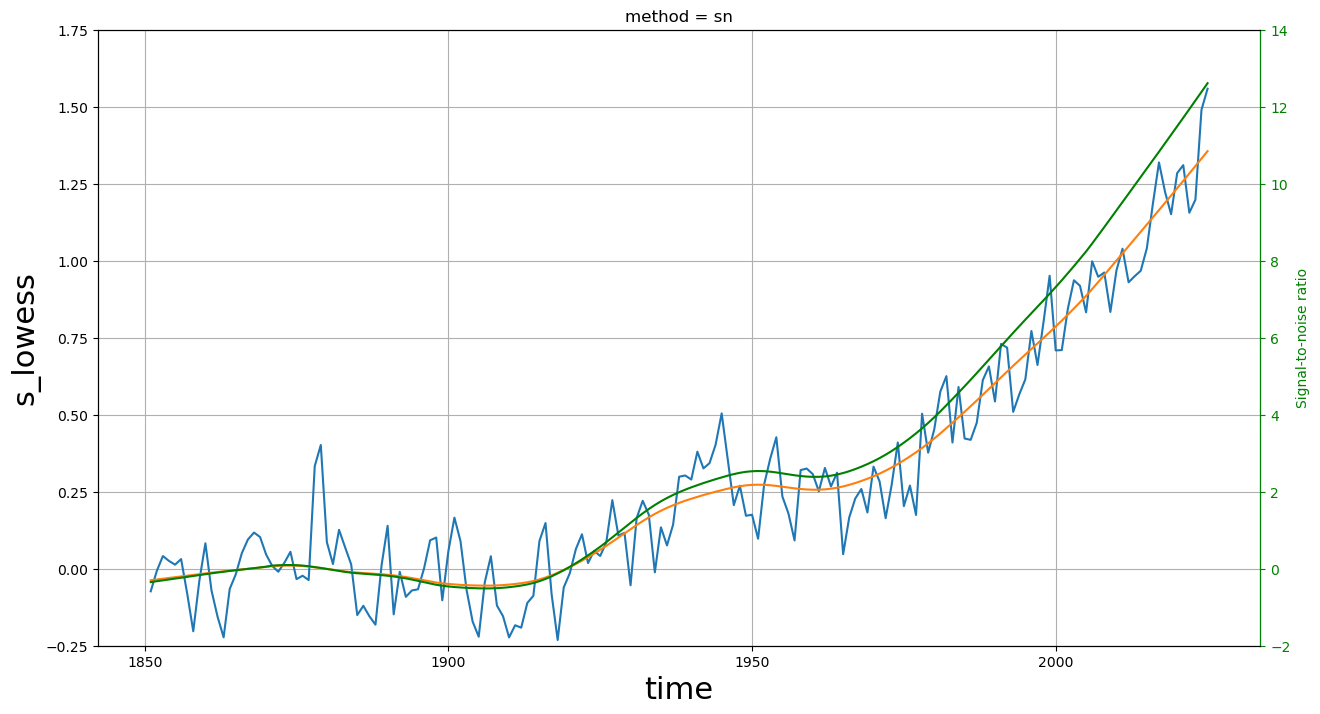

In [64]:
fig, ax = plt.subplots(figsize=(15, 8))
ax_twinx = ax.twinx()


# Define the rectangular patches on the secondary y-axis
xstart = ax_twinx.get_xbound()[0]
width = np.sum(np.abs(ax_twinx.get_xbound()))

rect1 = patches.Rectangle((xstart, -2), width, 3, edgecolor=None, alpha=0.4, facecolor='grey', zorder=1)
rect2 = patches.Rectangle((xstart, 1), width, 1, edgecolor=None, alpha=0.6, facecolor='grey', zorder=1)
rect3 = patches.Rectangle((xstart, 2), width, 1, edgecolor=None, alpha=0.8, facecolor='grey', zorder=1)
rect4 = patches.Rectangle((xstart, 3), width, 1, edgecolor=None, alpha=1, facecolor='grey', zorder=1)

# Add patches to the secondary y-axis
ax_twinx.add_patch(rect1)
ax_twinx.add_patch(rect2)
ax_twinx.add_patch(rect3)
ax_twinx.add_patch(rect4)

# Plot on the secondary y-axis
ds_best_sn.plot(ax=ax_twinx, color='green', zorder=2)  # Ensure the plot is in front

# Labels and grid
ax.set_ylabel('GMST Anomaly', fontsize=22)
ax.set_xlabel('Year', fontsize=22)
ax_twinx.set_ylabel('Signal-to-noise ratio', color='green')
ax_twinx.tick_params(axis='y', colors='green', labelcolor='green')
ax_twinx.spines['right'].set_color('green')

ax.set_ylim(-0.25, 1.75)
ax_twinx.set_ylim(-2, 14)
ax.set_yticks(np.linspace(ax.get_ybound()[0], ax.get_ybound()[1], 9))
ax_twinx.set_yticks(np.linspace(ax_twinx.get_ybound()[0], ax_twinx.get_ybound()[1], 9))


# Plot on the primary y-axis
best_ds_smean.plot(ax=ax, zorder=3)  # Ensure these plots are in front
ds_best_lowess.plot(ax=ax, zorder=3)  # Ensure these plots are in front

ax.grid(True)



Text(1861, 5, 'Inconceivable')

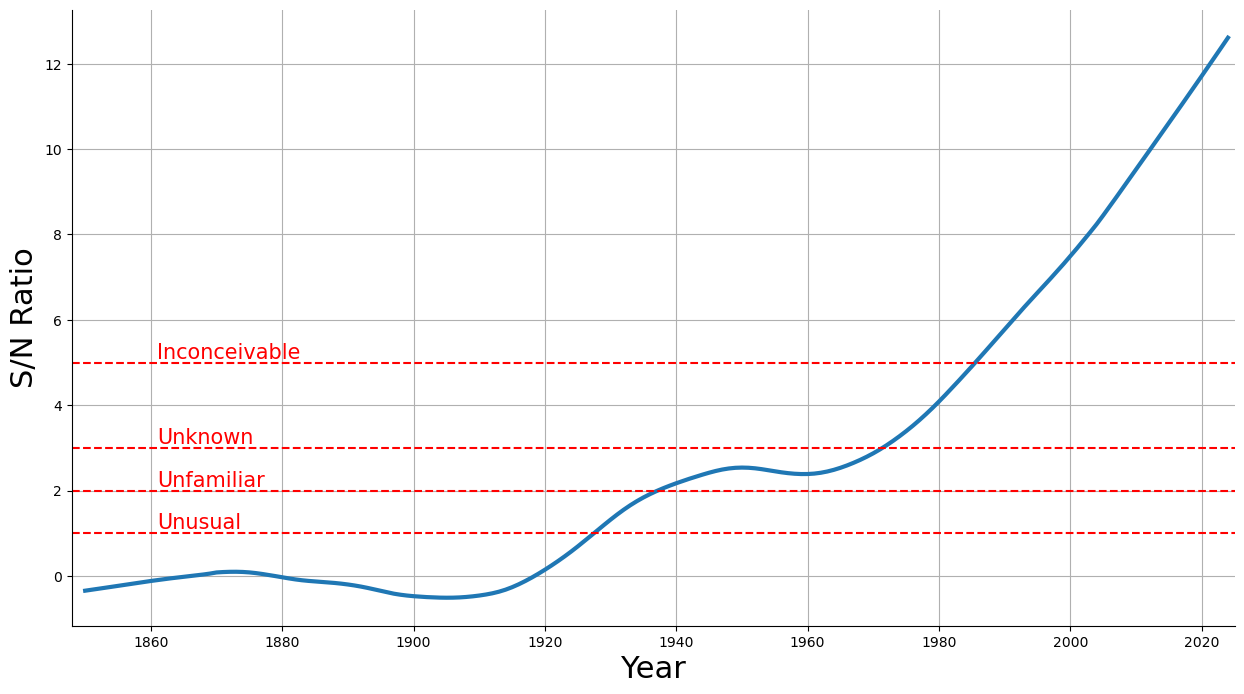

In [65]:
fig, ax = plt.subplots(figsize=(15, 8))
time = ds_best_sn.time.dt.year.values
ax.plot(time, ds_best_sn.values, linewidth=3)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('S/N Ratio', fontsize=22)
ax.set_xlabel('Year', fontsize=22)
ax.grid(True)


ax.set_xlim(1848, 2025)


frame_lines = dict(linestyle='--', color='red')
ax.axhline(1, **frame_lines)
ax.annotate('Unusual', xy=(1861, 1), va='bottom', size=15, color='red')
ax.axhline(2, **frame_lines)
ax.annotate('Unfamiliar', xy=(1861, 2), va='bottom', size=15, color='red')
ax.axhline(3, **frame_lines)
ax.annotate('Unknown', xy=(1861, 3), va='bottom', size=15, color='red')

ax.axhline(5, **frame_lines)
ax.annotate('Inconceivable', xy=(1861, 5), va='bottom', size=15, color='red')


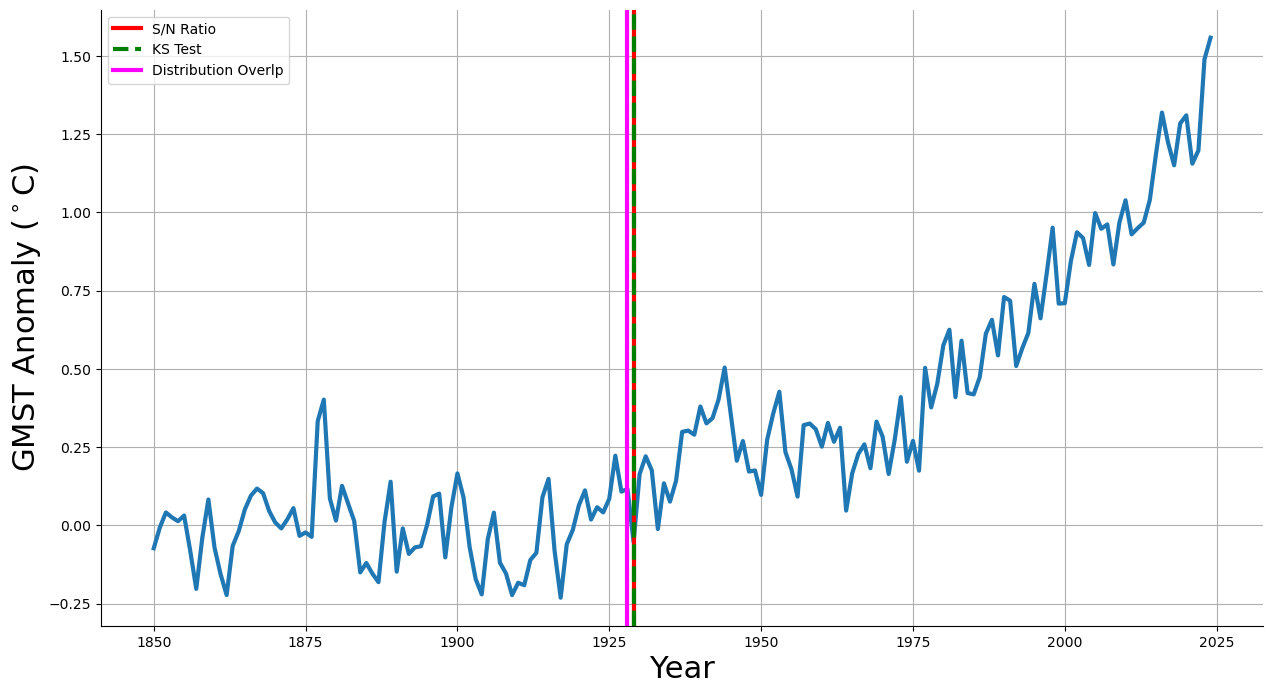

In [66]:
fig, ax = plt.subplots(figsize=(15, 8))
time = ds_best_lowess.time.dt.year.values
ax.plot(time, best_ds_smean.values, linewidth=3)
# ax.plot(time, ds_best_lowess.values, linewidth=3)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('GMST Anomaly'+ r' ($^\circ$C)', fontsize=22)
ax.set_xlabel('Year', fontsize=22)
ax.grid(True)

ax.axvline(1929, linewidth=3, color='red', label='S/N Ratio')
ax.axvline(1929, linewidth=3, color='green', linestyle='--', label='KS Test')
ax.axvline(1928, linewidth=3, color='magenta', label='Distribution Overlp')
ax.legend()

(1848.0, 2025.0)

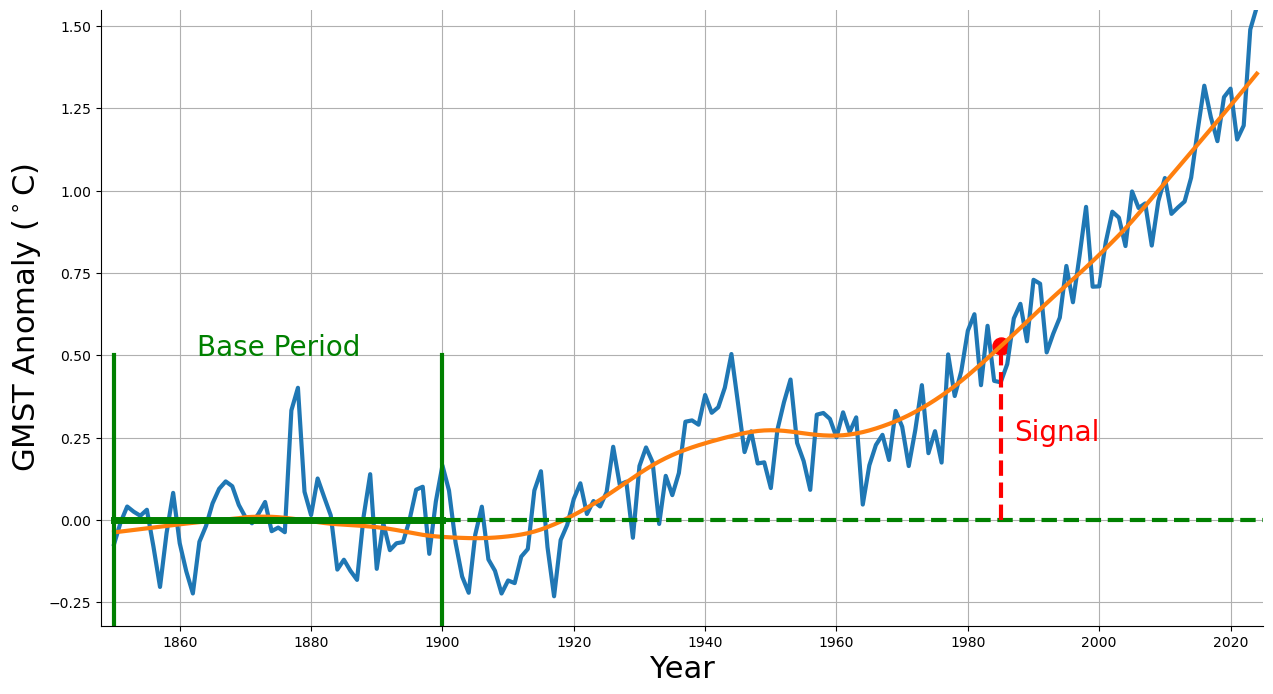

In [67]:
fig, ax = plt.subplots(figsize=(15, 8))
time = ds_best_lowess.time.dt.year.values
ax.plot(time, best_ds_smean.values, linewidth=3)
ax.plot(time, ds_best_lowess.values, linewidth=3)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('GMST Anomaly' + r' ($^\circ$C)', fontsize=22)
ax.set_xlabel('Year', fontsize=22)
ax.grid(True)

ylower = ax.get_ylim()[0]
ax.plot([1850, 1850], [ylower, 0.5], linewidth=3, color='green')
ax.plot([1900, 1900], [ylower, 0.5], linewidth=3, color='green')
ax.plot([1850, 2025], [0, 0], color='green', linewidth=3, linestyle='--')
ax.plot([1850, 1900], [0, 0], color='green', linewidth=5)

itime = 135
ax.scatter(time[itime], ds_best_lowess.values[itime], marker='o', s=150,
          color='red')
ax.plot([time[itime], time[itime]], [0, ds_best_lowess.values[itime]],
       color='red', linewidth=3, linestyle='--')

ax.annotate('Signal', xy=(time[itime]+2, ds_best_lowess.values[itime]/2), fontsize=20, ha='left', 
            color='red', va='center')

ax.set_ylim(ylower, 1.55)
ax.annotate('Base Period', xy=(1875, 0.5), fontsize=20, ha='center', color='green')

ax.set_xlim(1848, 2025)

Text(1861, 5, 'Inconceivable')

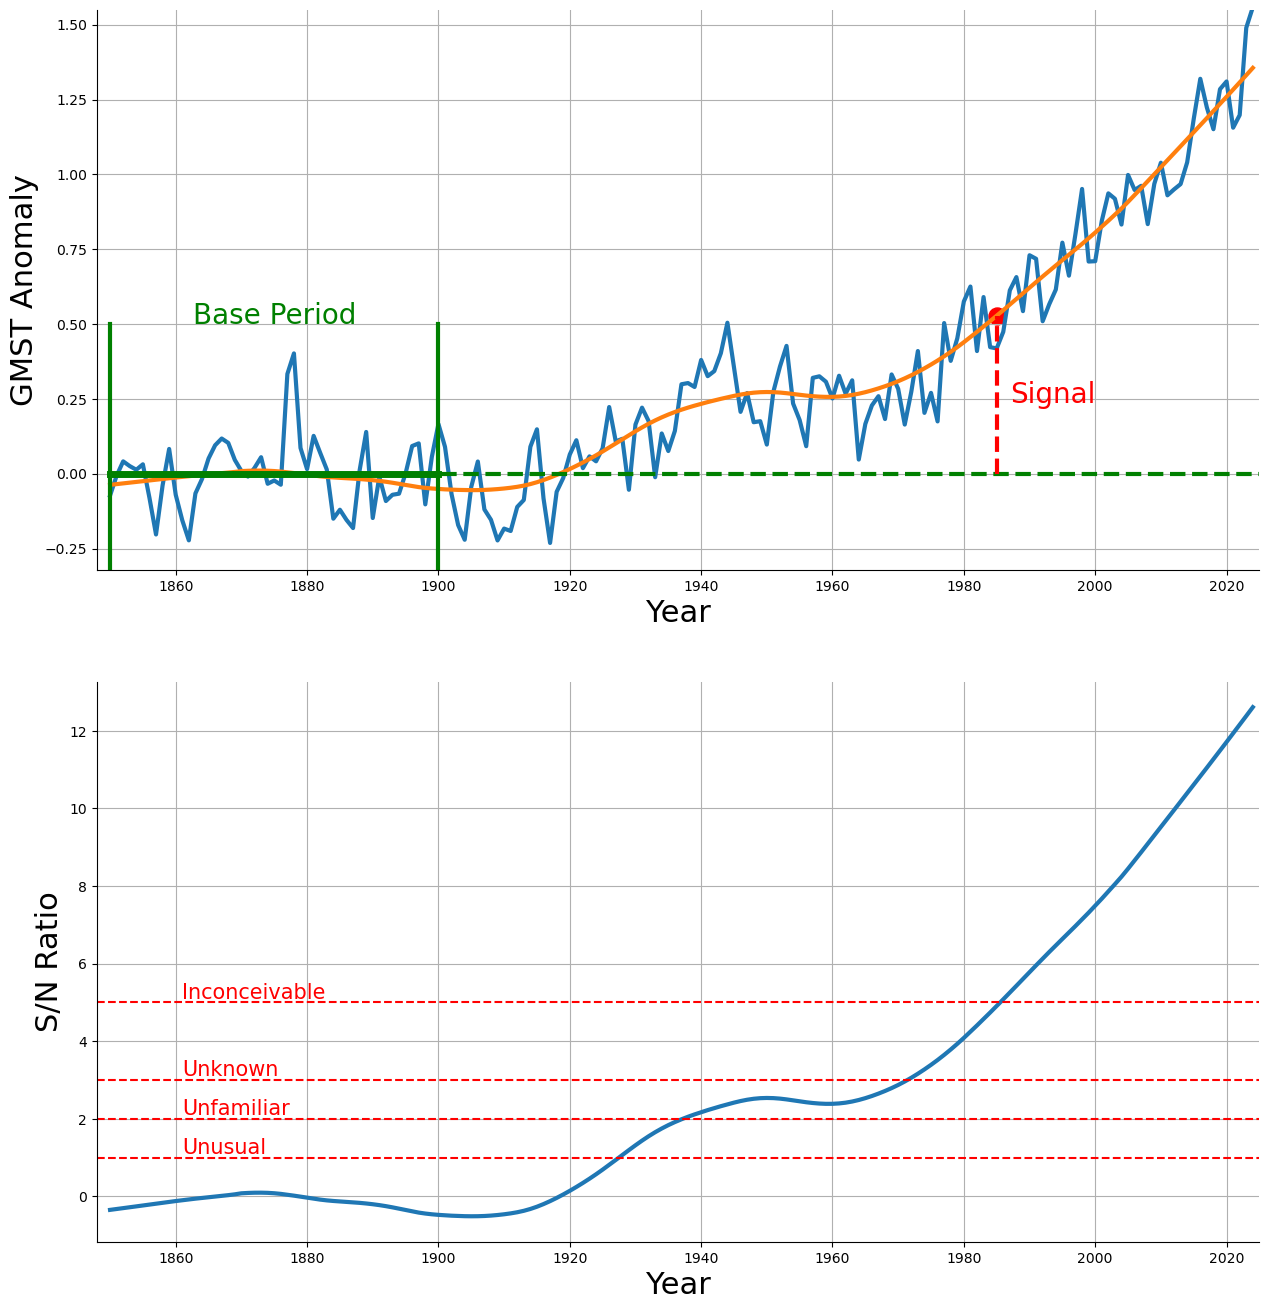

In [68]:

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 16))

### Upper aes
time = ds_best_lowess.time.dt.year.values
ax1.plot(time, best_ds_smean.values, linewidth=3)
ax1.plot(time, ds_best_lowess.values, linewidth=3)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_ylabel('GMST Anomaly', fontsize=22)
ax1.set_xlabel('Year', fontsize=22)
ax1.grid(True)

ylower = ax1.get_ylim()[0]
ax1.plot([1850, 1850], [ylower, 0.5], linewidth=3, color='green')
ax1.plot([1900, 1900], [ylower, 0.5], linewidth=3, color='green')
ax1.plot([1850, 2025], [0, 0], color='green', linewidth=3, linestyle='--')
ax1.plot([1850, 1900], [0, 0], color='green', linewidth=5)

itime = 135
ax1.scatter(time[itime], ds_best_lowess.values[itime], marker='o', s=150,
          color='red')
ax1.plot([time[itime], time[itime]], [0, ds_best_lowess.values[itime]],
       color='red', linewidth=3, linestyle='--')

ax1.annotate('Signal', xy=(time[itime]+2, ds_best_lowess.values[itime]/2), fontsize=20, ha='left', 
            color='red', va='center')

ax1.set_ylim(ylower, 1.55)
ax1.annotate('Base Period', xy=(1875, 0.5), fontsize=20, ha='center', color='green')

ax1.set_xlim(1848, 2025)



### Lower axes

time = ds_best_sn.time.dt.year.values
ax2.plot(time, ds_best_sn.values, linewidth=3)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_ylabel('S/N Ratio', fontsize=22)
ax2.set_xlabel('Year', fontsize=22)
ax2.grid(True)


ax2.set_xlim(1848, 2025)


frame_lines = dict(linestyle='--', color='red')
ax2.axhline(1, **frame_lines)
ax2.annotate('Unusual', xy=(1861, 1), va='bottom', size=15, color='red')
ax2.axhline(2, **frame_lines)
ax2.annotate('Unfamiliar', xy=(1861, 2), va='bottom', size=15, color='red')
ax2.axhline(3, **frame_lines)
ax2.annotate('Unknown', xy=(1861, 3), va='bottom', size=15, color='red')

ax2.axhline(5, **frame_lines)
ax2.annotate('Inconceivable', xy=(1861, 5), va='bottom', size=15, color='red')


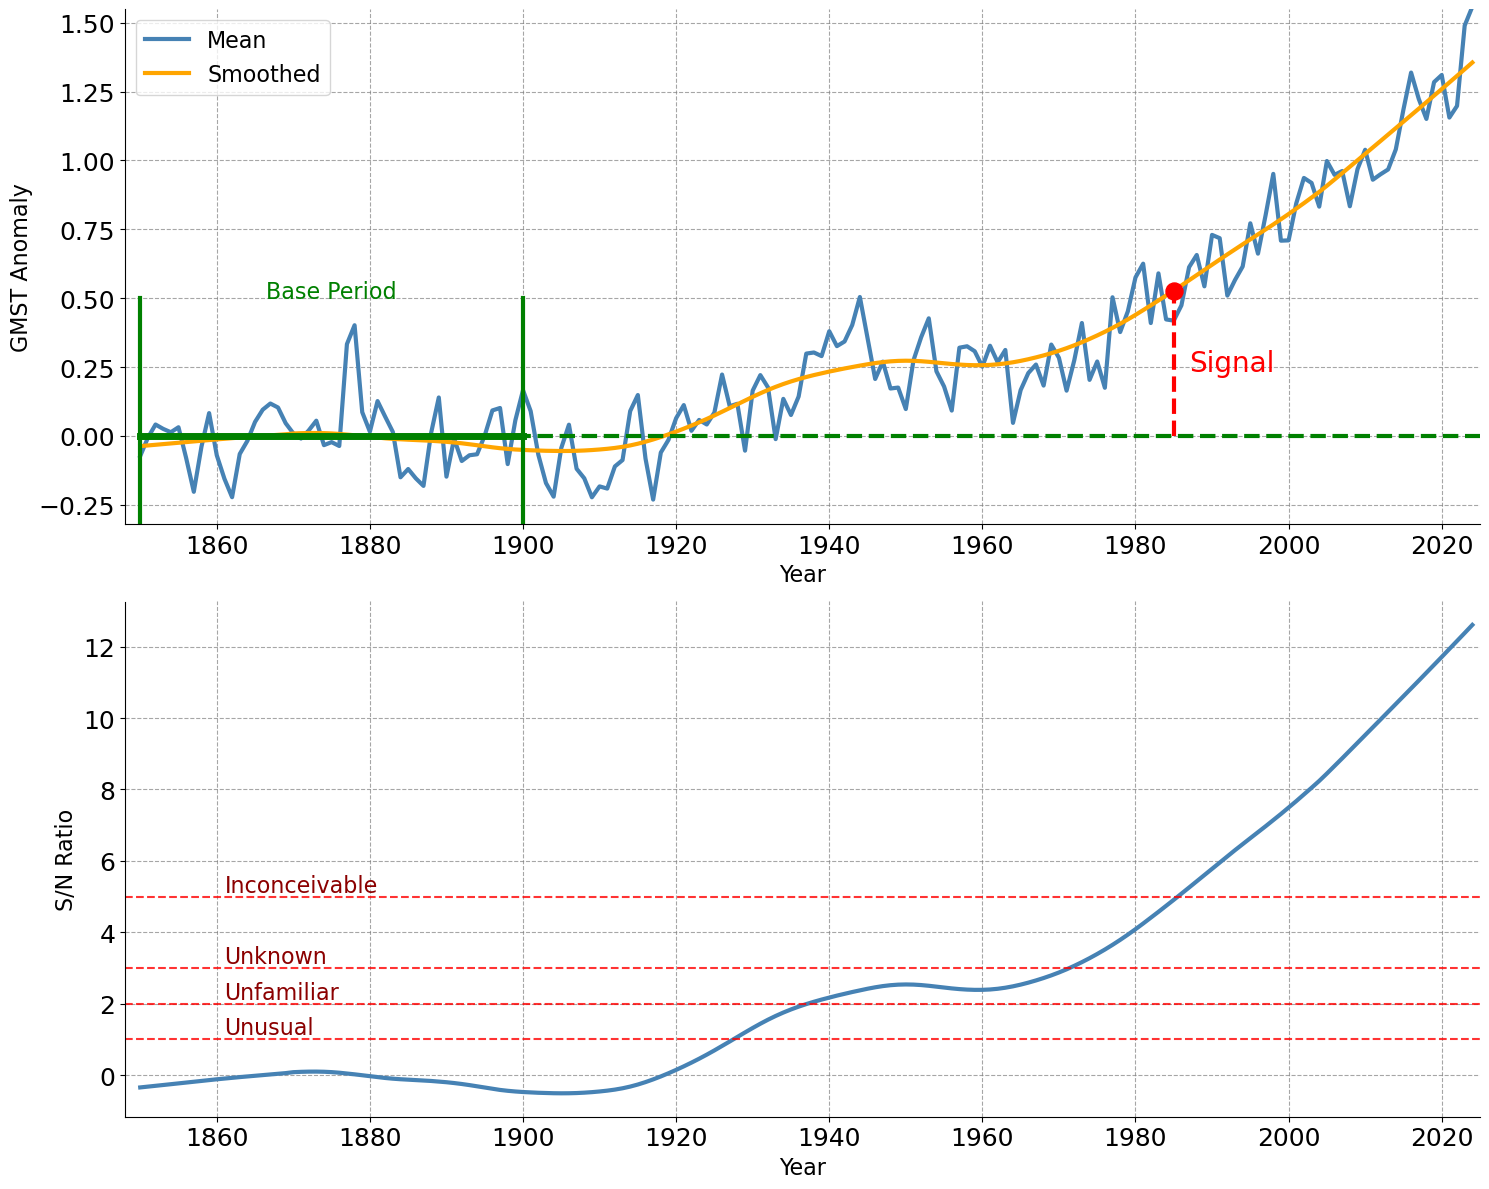

In [69]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

text_size = 16

# --- Upper axes (GMST Anomaly) ---
time = ds_best_lowess.time.dt.year.values
ax1.plot(time, best_ds_smean.values, linewidth=3, label="Mean", color="steelblue")
ax1.plot(time, ds_best_lowess.values, linewidth=3, label="Smoothed", color="orange")

# Remove top and right spines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Axis labels
ax1.set_ylabel('GMST Anomaly', fontsize=text_size)
ax1.set_xlabel('Year', fontsize=text_size)

# Customize tick label sizes
ax1.tick_params(axis='both', labelsize=18)

# Grid customization
ax1.grid(True, which='both', linestyle='--', color='grey', alpha=0.7)

# Green base period annotations
ylower = ax1.get_ylim()[0]
ax1.plot([1850, 1850], [ylower, 0.5], linewidth=3, color='green')
ax1.plot([1900, 1900], [ylower, 0.5], linewidth=3, color='green')
ax1.plot([1850, 2025], [0, 0], color='green', linewidth=3, linestyle='--')
ax1.plot([1850, 1900], [0, 0], color='green', linewidth=5)
ax1.annotate('Base Period', xy=(1875, 0.5), fontsize=text_size, ha='center', color='green')


# Red scatter and annotation for the signal
itime = 135
ax1.scatter(time[itime], ds_best_lowess.values[itime], marker='o', s=150, color='red', zorder=3)
ax1.plot([time[itime], time[itime]], [0, ds_best_lowess.values[itime]], color='red', linewidth=3, 
         linestyle='--')

ax1.annotate('Signal', xy=(time[itime]+2, ds_best_lowess.values[itime]/2), fontsize=20, ha='left', 
            color='red', va='center')

# Other annotations
ax1.set_ylim(ylower, 1.55)

# Axis limits
ax1.set_xlim(1848, 2025)

# Add a legend
ax1.legend(loc="upper left", fontsize=text_size)

# --- Lower axes (S/N Ratio) ---
time_sn = ds_best_sn.time.dt.year.values
ax2.plot(time_sn, ds_best_sn.values, linewidth=3, color="steelblue")

# Remove top and right spines
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Axis labels
ax2.set_ylabel('S/N Ratio', fontsize=text_size)
ax2.set_xlabel('Year', fontsize=text_size)

# Customize tick label sizes
ax2.tick_params(axis='both', labelsize=18)

# Grid customization
ax2.grid(True, which='both', linestyle='--', color='grey', alpha=0.7)

# Horizontal lines and annotations
frame_lines = dict(linestyle='--', color='red', linewidth=1.5, alpha=0.8)
ax2.axhline(1, **frame_lines)
ax2.annotate('Unusual', xy=(1861, 1), va='bottom', size=text_size, color='darkred')
ax2.axhline(2, **frame_lines)
ax2.annotate('Unfamiliar', xy=(1861, 2), va='bottom', size=text_size, color='darkred')
ax2.axhline(3, **frame_lines)
ax2.annotate('Unknown', xy=(1861, 3), va='bottom', size=text_size, color='darkred')
ax2.axhline(5, **frame_lines)
ax2.annotate('Inconceivable', xy=(1861, 5), va='bottom', size=text_size, color='darkred')

# Axis limits
ax2.set_xlim(1848, 2025)

# Reduce space between the plots
plt.tight_layout()

# Show the plot
plt.show()


<h2 style='color: cyan'> KS Test</h2>

In [70]:
# Assuming ks_emergence_year and base_period_tuple are already defined
ks_emergence_year = int(toe_ds['ks'].values.item())
base_period_end = base_period_tuple[-1]
year_until_emergence = ks_emergence_year - base_period_end
years = np.arange(0, 40, 3) # These are the years after the base period
# The central year will be the end of the base period + 10 (ass middle of 20-years), +year
central_years = base_period_end+10+years
years, central_years

(array([ 0,  3,  6,  9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39]),
 array([1910, 1913, 1916, 1919, 1922, 1925, 1928, 1931, 1934, 1937, 1940,
        1943, 1946, 1949]))

(1.0499273218260938, -0.049996539134575885)

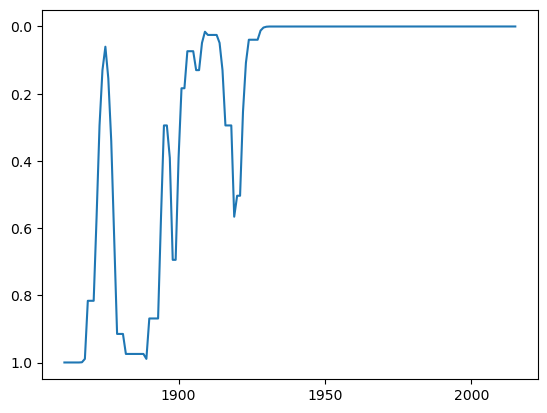

In [71]:
fig, ax2 = plt.subplots(1, 1)
ax2.plot(toe_metrics_ds['ks'].time.values, toe_metrics_ds['ks'].values)
ax2.set_ylim(np.take(ax2.get_ylim(), [-1, 0]))

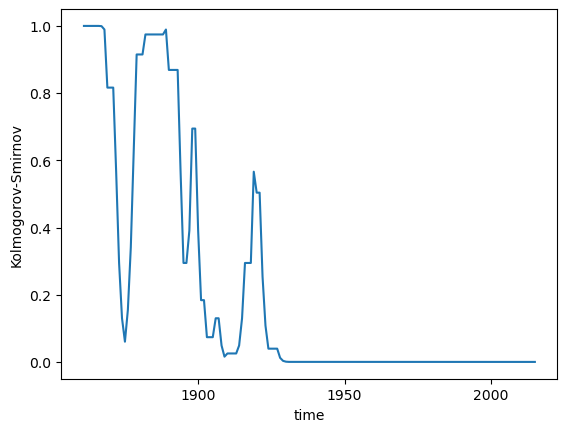

In [72]:
toe_metrics_ds['ks'].plot()

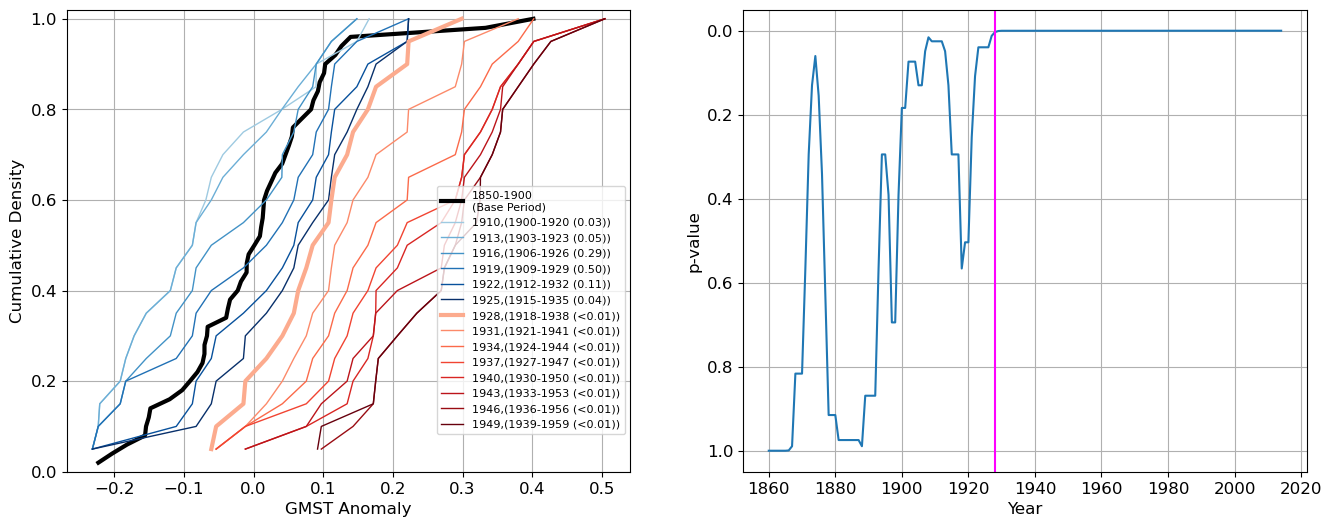

In [73]:
# Set up your plot
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(16, 6))



# Base array for comparison
base_array = best_ds_smean.isel(time=slice(0, 50)).values  # Length 50
ecdf_base = ECDF(base_array)
ax.plot(ecdf_base.x, ecdf_base.y, color='black', linewidth=3, label='1850-1900\n(Base Period)')

# Prepare to calculate KS statistics and p-values
ks_statistics = []
ks_statistics2 = []

p_values = []

# Set up color maps
cmap1 = cm.get_cmap('Blues', sum(central_years < ks_emergence_year) + 3)  
cmap2 = cm.get_cmap('Reds', sum(central_years >= ks_emergence_year) + 3) 

# Loop through the years and calculate ECDFs, KS statistics, and p-values
count = 3
for year, central_year in zip(years, central_years):

    data2 = best_ds_smean.values[50 + year:70 + year]  # Second dataset (length 20)
    ecdf2 = ECDF(data2)

    # Compute KS statistic and p-value using ks_2samp
    ks_statistic2, p_value = ks_2samp(base_array, data2)  # Direct KS test
    ks_statistics2.append(ks_statistic2)  # Store the KS statistic from ks_2samp
    p_values.append(p_value) 

    # Set line width based on conditions
    if ks_emergence_year - 3 < central_year < ks_emergence_year + 3:
        linewidth = 3
        count = 3
        
    else:
        linewidth = 1

    # Get color from colormap
    if central_year < ks_emergence_year:
        color = cmap1(count)
        count += 1
    else:
        color = cmap2(count) 
        count += 1

    # Plot the ECDF for the second dataset
    if p_value < 0.01:
        p_value_str = '<0.01'
    else:
        p_value_str = f'{p_value:.2f}'

    year_str = f'{central_year-10}-{central_year+10}'
    ax.plot(ecdf2.x, ecdf2.y, color=color,
            label=f'{central_year},({year_str} ({p_value_str}))', linewidth=linewidth)


# Set labels, grid, and legend
ax.set_ylabel('Cumulative Density', fontsize=12)
ax.set_xlabel('GMST Anomaly', fontsize=12)
ax.grid(True)
ax.legend(loc='right', bbox_to_anchor=[1.0, 0.35], fontsize=8)

ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)

ax.set_ylim(0, 1.02)

# The second subplot
ax2.plot(toe_metrics_ds['ks'].time.dt.year.values, toe_metrics_ds['ks'].values)
ax2.set_ylim(np.take(ax2.get_ylim(), [-1, 0]))
ax2.grid(True)

ax2.tick_params(axis='y', labelsize=12)
ax2.tick_params(axis='x', labelsize=12)

ax2.set_ylabel('p-value', fontsize=12)
ax2.set_xlabel('Year', fontsize=12)
ax2.axvline(ks_emergence_year, color='magenta')

In [74]:
best_ds_smean

<xarray.DataArray 'temperature' (time: 175)> Size: 700B
-0.07331 -0.00706 0.04114 0.02534 0.01312 ... 1.31 1.156 1.198 1.49 1.558
Coordinates:
  * time     (time) object 1kB 1850-12-31 00:00:00 ... 2024-12-31 00:00:00

In [75]:
base_period_end + year, base_period_end + year

(1939, 1939)

(0.0, 1.02)

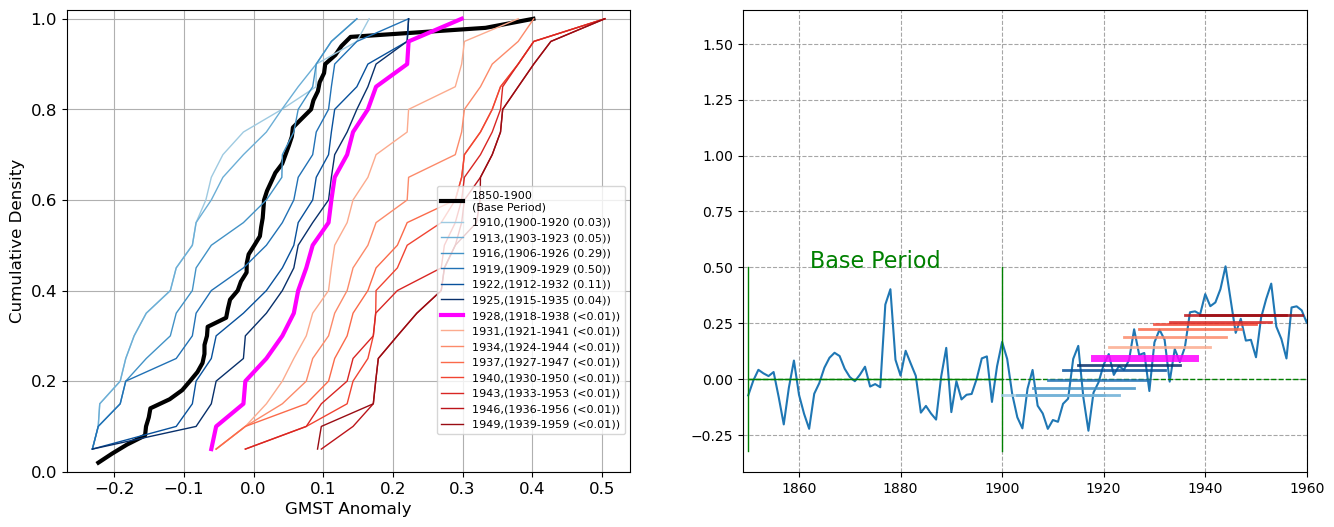

In [76]:
# Set up your plot
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax2.plot(best_ds_smean.time.dt.year.values, best_ds_smean.values)
# Green base period annotations
ylower = ax2.get_ylim()[0]
ax2.plot([1850, 1850], [ylower, 0.5], linewidth=1, color='green')
ax2.plot([1900, 1900], [ylower, 0.5], linewidth=1, color='green')
ax2.plot([1850, 2025], [0, 0], color='green', linewidth=1, linestyle='--')
ax2.plot([1850, 1900], [0, 0], color='green', linewidth=1)
ax2.annotate('Base Period', xy=(1875, 0.5), fontsize=text_size, ha='center', color='green')

ax2.set_xlim(1849, 1960)
ax2.grid(True, which='both', linestyle='--', color='grey', alpha=0.7)

# Base array for comparison
base_array = best_ds_smean.isel(time=slice(0, 50)).values  # Length 50
ecdf_base = ECDF(base_array)
ax.plot(ecdf_base.x, ecdf_base.y, color='black', linewidth=3, label='1850-1900\n(Base Period)')

# Prepare to calculate KS statistics and p-values
ks_statistics = []
ks_statistics2 = []

p_values = []

# Set up color maps
cmap1 = cm.get_cmap('Blues', sum(central_years < ks_emergence_year) + 3)  
cmap2 = cm.get_cmap('Reds', sum(central_years >= ks_emergence_year) + 3) 

# Loop through the years and calculate ECDFs, KS statistics, and p-values
count = 3
for year, central_year in zip(years, central_years):

    data2 = best_ds_smean.values[50 + year:70 + year]  # Second dataset (length 20)
    ecdf2 = ECDF(data2)
    

    # Compute KS statistic and p-value using ks_2samp
    ks_statistic2, p_value = ks_2samp(base_array, data2)  # Direct KS test
    ks_statistics2.append(ks_statistic2)  # Store the KS statistic from ks_2samp
    p_values.append(p_value) 


    


    # Get color from colormap
    if central_year < ks_emergence_year:
        color = cmap1(count)
        count += 1
    else:
        color = cmap2(count) 
        count += 1

        # Set line width based on conditions
    if ks_emergence_year - 3 < central_year < ks_emergence_year + 3:
        linewidth = 3
        count = 3
        linewidth_ax2 = 5
        color='magenta'
        
    else:
        linewidth = 1
        linewidth_ax2 = 2

    # Plot the ECDF for the second dataset
    if p_value < 0.01:
        p_value_str = '<0.01'
    else:
        p_value_str = f'{p_value:.2f}'

    year_str = f'{central_year-10}-{central_year+10}'
    ax.plot(ecdf2.x, ecdf2.y, color=color,
            label=f'{central_year},({year_str} ({p_value_str}))', linewidth=linewidth)

    data2_mean = np.nanmean(data2)
    ax2.plot([base_period_end + year, base_period_end+ 20 + year], [data2_mean, data2_mean],
            color=color, linewidth=linewidth_ax2, alpha=0.85)

    ####


# Set labels, grid, and legend
ax.set_ylabel('Cumulative Density', fontsize=12)
ax.set_xlabel('GMST Anomaly', fontsize=12)
ax.grid(True)
ax.legend(loc='right', bbox_to_anchor=[1.0, 0.35], fontsize=8)

ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)

ax.set_ylim(0, 1.02)

# # The second subplot
# ax2.plot(toe_metrics_ds['ks'].time.dt.year.values, toe_metrics_ds['ks'].values)
# ax2.set_ylim(np.take(ax2.get_ylim(), [-1, 0]))
# ax2.grid(True)

# ax2.tick_params(axis='y', labelsize=12)
# ax2.tick_params(axis='x', labelsize=12)

# ax2.set_ylabel('p-value', fontsize=12)
# ax2.set_xlabel('Year', fontsize=12)
# ax2.axvline(ks_emergence_year, color='magenta')

(0.0, 1.02)

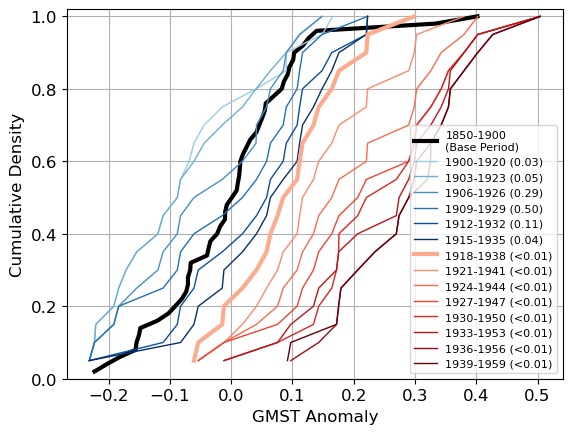

In [77]:
# Set up your plot
fig, ax = plt.subplots(1, 1)

# Assuming ks_emergence_year and base_period_tuple are already defined
ks_emergence_year = int(toe_ds['ks'].values.item())
base_period_end = base_period_tuple[-1]
year_until_emergence = ks_emergence_year - base_period_end

# Base array for comparison
base_array = best_ds_smean.isel(time=slice(0, 50)).values  # Length 50
ecdf_base = ECDF(base_array)
ax.plot(ecdf_base.x, ecdf_base.y, color='black', linewidth=3, label='1850-1900\n(Base Period)')

# Prepare to calculate KS statistics and p-values
ks_statistics = []
ks_statistics2 = []

p_values = []

# Set up color maps
cmap1 = cm.get_cmap('Blues', sum(central_years < ks_emergence_year) + 3)  
cmap2 = cm.get_cmap('Reds', sum(central_years >= ks_emergence_year) + 3) 

# Loop through the years and calculate ECDFs, KS statistics, and p-values
count = 3
for year, central_year in zip(years, central_years):

    data2 = best_ds_smean.values[50 + year:70 + year]  # Second dataset (length 20)
    ecdf2 = ECDF(data2)

    # Create a common grid of values for evaluating ECDFs
    combined_values = np.concatenate([base_array, data2])
    ecdf_combined = np.sort(combined_values)

    # Evaluate the ECDFs at the combined values
    ecdf_base_values = ecdf_base(ecdf_combined)
    ecdf2_values = ecdf2(ecdf_combined)

    # Calculate the KS statistic (maximum difference)
    differences = np.abs(ecdf_base_values - ecdf2_values)
    ks_statistic = np.max(differences)  # Max difference from ECDFs
    ks_statistics.append(ks_statistic)   # Store the KS statistic from ECDFs

    # Compute KS statistic and p-value using ks_2samp
    ks_statistic2, p_value = ks_2samp(base_array, data2)  # Direct KS test
    ks_statistics2.append(ks_statistic2)  # Store the KS statistic from ks_2samp
    p_values.append(p_value) 

    # Set line width based on conditions
    if ks_emergence_year - 3 < central_year < ks_emergence_year + 3:
        linewidth = 3
        count = 3
        
    else:
        linewidth = 1

    # Get color from colormap
    if central_year < ks_emergence_year:
        color = cmap1(count)
        count += 1
    else:
        color = cmap2(count) 
        count += 1

    # Plot the ECDF for the second dataset
    if p_value < 0.01:
        p_value_str = '<0.01'
    else:
        p_value_str = f'{p_value:.2f}'

    year_str = f'{central_year-10}-{central_year+10}'
    ax.plot(ecdf2.x, ecdf2.y, color=color,
            label=f'{year_str} ({p_value_str})', linewidth=linewidth)





# Set labels, grid, and legend
ax.set_ylabel('Cumulative Density', fontsize=12)
ax.set_xlabel('GMST Anomaly', fontsize=12)
ax.grid(True)
ax.legend(loc='right', bbox_to_anchor=[1.0, 0.35], fontsize=8)

ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)

ax.set_ylim(0, 1.02)

In [78]:
# Print the KS statistics and p-values for each year
for central_year, ks_stat, p_val in zip(central_years, ks_statistics, p_values):
    print(f"KS Statistic for year {central_year}: {ks_stat}, p-value: {p_val}")

KS Statistic for year 1910: 0.37999999999999995, p-value: 0.025179533099176636
KS Statistic for year 1913: 0.35, p-value: 0.048844029818826566
KS Statistic for year 1916: 0.24999999999999997, p-value: 0.29449912551945945
KS Statistic for year 1919: 0.21000000000000008, p-value: 0.5037278503545657
KS Statistic for year 1922: 0.31000000000000005, p-value: 0.10813272558383452
KS Statistic for year 1925: 0.36000000000000004, p-value: 0.03945221556540564
KS Statistic for year 1928: 0.46, p-value: 0.0031886855178668632
KS Statistic for year 1931: 0.56, p-value: 0.00012470093911667402
KS Statistic for year 1934: 0.65, p-value: 3.2928280874369593e-06
KS Statistic for year 1937: 0.75, p-value: 2.196689587238549e-08
KS Statistic for year 1940: 0.8400000000000001, p-value: 7.758744016307761e-11
KS Statistic for year 1943: 0.79, p-value: 2.0697422881437893e-09
KS Statistic for year 1946: 0.91, p-value: 2.5062296896711496e-13
KS Statistic for year 1949: 0.8600000000000001, p-value: 1.81987040975137

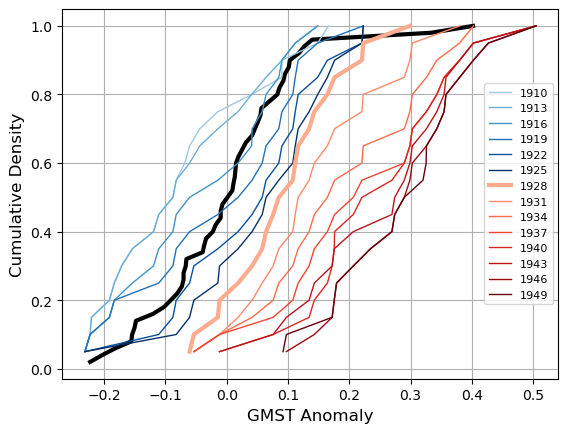

In [79]:
fig, ax = plt.subplots(1, 1)

ks_emergence_year = int(toe_ds['ks'].values.item())
base_period_end = base_period_tuple[-1]
year_until_emergence = ks_emergence_year - base_period_end

number_cdfs = 50

# Set up your color map
cmap1 = cm.get_cmap('Blues', sum(central_years<ks_emergence_year)+3)  
cmap2 = cm.get_cmap('Reds', sum(central_years>=ks_emergence_year)+3) 


base_array = best_ds_smean.isel(time=slice(0,50)).values#[:50]
ecdf_base = ECDF(base_array)
ax.plot(ecdf_base.x, ecdf_base.y, color='black', linewidth=3)  # You can keep the first ECDF in black or another fixed color

# Plot the subsequent ECDFs with a color gradient
count = 3
for year, central_year in zip(years, central_years):
    # central_year = base_period_end+10+year
    
    data2 = best_ds_smean.values[50+year:70+year]
    ecdf2 = ECDF(data2)
    if ks_emergence_year-3<central_year<ks_emergence_year+3:
        linewidth = 3
        count = 3
    else: linewidth = 1
    
    # Get color from colormap
    if central_year < ks_emergence_year:
        color = cmap1(count)
        count += 1
    else:
        color = cmap2(count) 
        count +=1



    ax.plot(ecdf2.x, ecdf2.y, color=color, label=central_year,linewidth=linewidth) 

ax.set_ylabel('Cumulative Density', fontsize=12)
ax.set_xlabel('GMST Anomaly', fontsize=12)
ax.grid(True)
ax.legend(loc='right', bbox_to_anchor=[1.0, 0.5], fontsize=8)  

Text(1875, 0.5, 'Base Period')

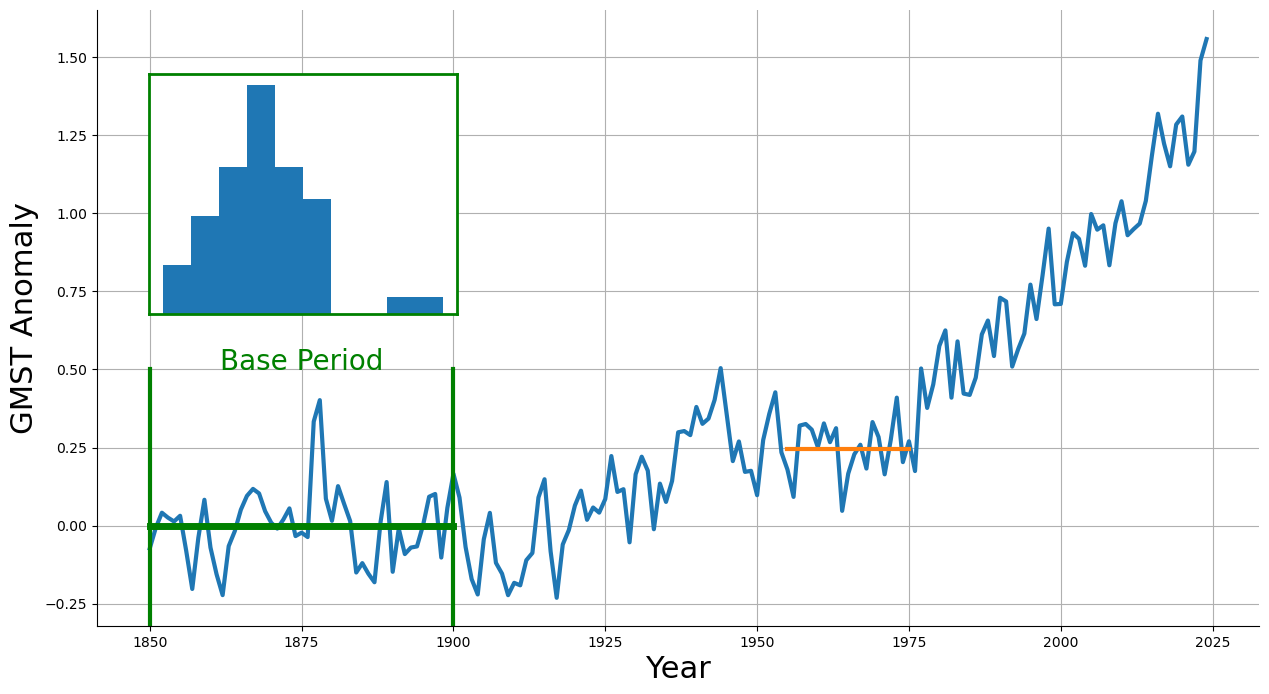

In [80]:
fig, ax = plt.subplots(figsize=(15, 8))
time = best_ds_smean.time.dt.year.values
ax.plot(time, best_ds_smean.values, linewidth=3)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('GMST Anomaly', fontsize=22)
ax.set_xlabel('Year', fontsize=22)
ax.grid(True)

ylower = ax.get_ylim()[0]
ax.plot([1850, 1850], [ylower, 0.5], linewidth=3, color='green')
ax.plot([1900, 1900], [ylower, 0.5], linewidth=3, color='green')
ax.plot([1850, 1900], [0, 0], color='green', linewidth=5)

inner_ax = fig.add_axes([0.16, 0.5, 0.205, 0.3])  # [left, bottom, width, height]
inner_ax.set_xticks([])
inner_ax.set_yticks([])
inner_ax.hist(best_ds_smean.values[:50])

# Set the spine colors and increase their width for the inner plot
for spine in inner_ax.spines.values():
    spine.set_color('green')  # Set color to green
    spine.set_linewidth(2)     # Set the linewidth to 2


central_year = 115

subset = best_ds_smean.values[central_year-10:central_year+10]
ax.plot([1850+central_year-10, 1850+central_year+10], np.tile(np.mean(subset), 2),
       linewidth=3)

ax.set_ylim(ylower, ax.get_ylim()[-1])
ax.annotate('Base Period', xy=(1875, 0.5), fontsize=20, ha='center', color='green')

<h2 style='color: cyan'>Overlap Methods </h2>

In [81]:
base_arr = best_ds_smean.isel(time=slice(0, 50))

In [82]:
start =70
arr = best_ds_smean.isel(time=slice(start, start+20)).values

In [83]:
num_bins = 25

bmax = np.nanmax(np.concatenate([base_arr, arr]))*1.2
bmin = np.nanmin(np.concatenate([base_arr, arr]))*1.2


# Define the bin width and create bin edges
bins = np.linspace(bmin, bmax, num_bins)

In [84]:
_, pdf_base = toe.discrete_pdf(base_arr, bins)
_, pdf_arr = toe.discrete_pdf(arr, bins)

In [85]:
pps_overlap = toe.discrete_distribution_overlap(pdf_base, pdf_arr)

Text(0, 0.5, 'Relative Frequency')

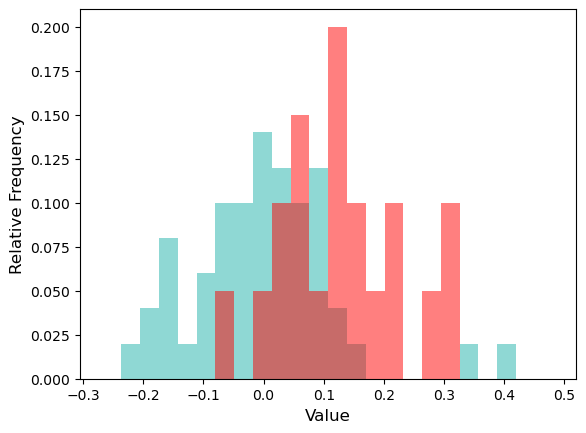

In [86]:
# Plot the PDF as a bar plot
plt.bar(bins[:-1], pdf_base, width=np.diff(bins), align='edge', label='Base Period',
       color='lightseagreen', alpha=0.5)
plt.bar(bins[:-1], pdf_arr, width=np.diff(bins), align='edge', label='Base Period',
       color='red', alpha=0.5)

plt.xlabel('Value', fontsize=12)
plt.ylabel('Relative Frequency', fontsize=12)


In [87]:
reload(toe)

<module 'toe_calc' from '/home/563/ab2313/Documents/time_of_emergene_drafts/src/toe_calc.py'>

In [88]:
x_kde, kde_vals1, kde_vals2, fga_overlap = toe.fractional_geometric_area(
    base_arr, arr, return_all=True, method_kwargs=dict(bw_method=0.2))#'silverman'))
# bw_method=0.2, 

Text(0.5, 1.0, 'Fractional Geometric Area (49%)')

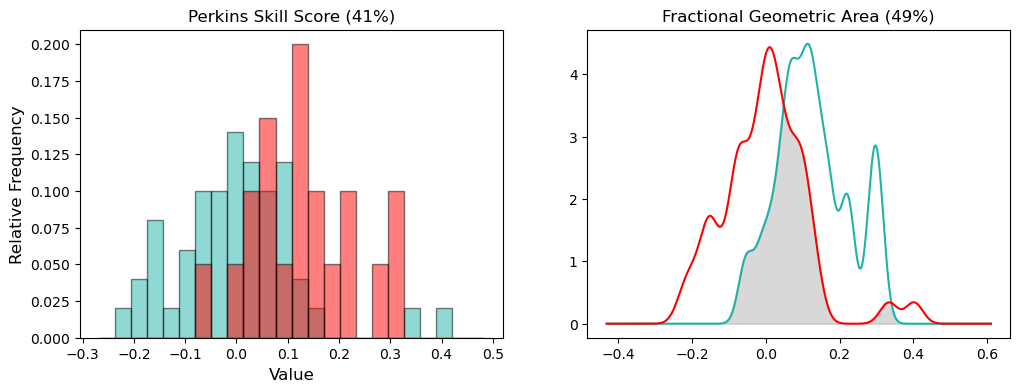

In [89]:
# Plot the PDF as a bar plot

fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.bar(bins[:-1], pdf_base, width=np.diff(bins), align='edge', label='Base Period',
       color='lightseagreen', alpha=0.5, edgecolor='k')
ax1.bar(bins[:-1], pdf_arr, width=np.diff(bins), align='edge', label='Base Period',
       color='red', alpha=0.5, edgecolor='k')


# Calculate the overlap
# overlap = np.minimum(pdf_base, pdf_arr)

# # Add the hatching pattern for overlapping regions
# ax1.bar(bins[:-1], overlap, width=np.diff(bins), align='edge', color='none', alpha=0,
#         hatch='/', edgecolor=None)


ax1.set_xlabel('Value', fontsize=12)
ax1.set_ylabel('Relative Frequency', fontsize=12)

ax1.set_title(f'Perkins Skill Score ({pps_overlap:.0f}%)')

ax2.plot(x_kde, kde_vals1, color='lightseagreen')
ax2.plot(x_kde, kde_vals2, color='red')
ax2.fill_between(x_kde, 0, np.min(np.vstack([kde_vals1, kde_vals2]), axis=0),
                 color='gray', alpha=0.3)

ax2.set_title(f'Fractional Geometric Area ({fga_overlap:.0f}%)')


Text(0.5, 1.0, 'Hellinger Distance = 53%')

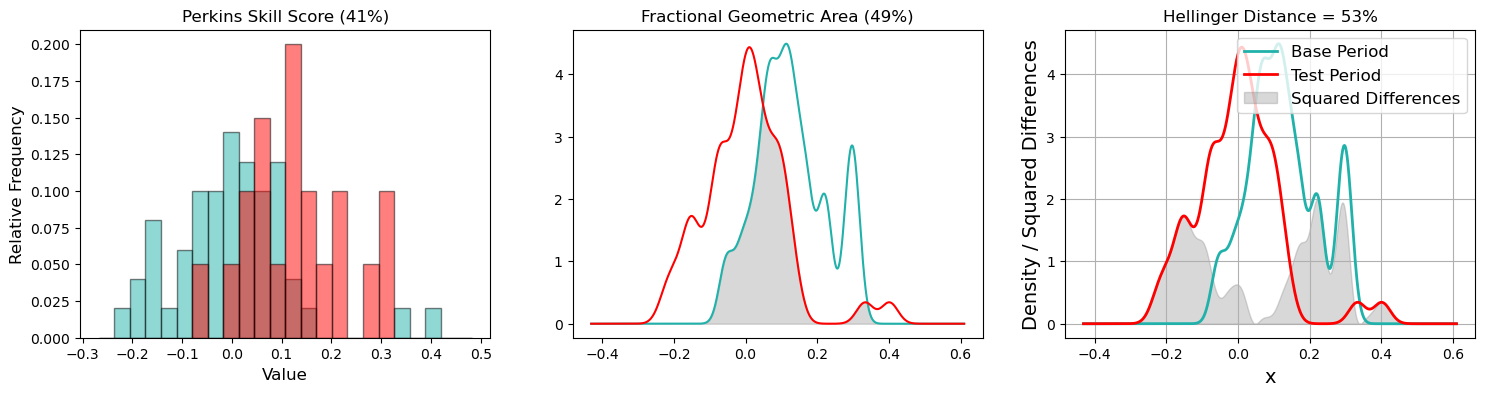

In [90]:
# Plot the PDF as a bar plot

fig = plt.figure(figsize=(18, 4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)


ax1.bar(bins[:-1], pdf_base, width=np.diff(bins), align='edge', label='Base Period',
       color='lightseagreen', alpha=0.5, edgecolor='k')
ax1.bar(bins[:-1], pdf_arr, width=np.diff(bins), align='edge', label='Base Period',
       color='red', alpha=0.5, edgecolor='k')


# Calculate the overlap
# overlap = np.minimum(pdf_base, pdf_arr)

# # Add the hatching pattern for overlapping regions
# ax1.bar(bins[:-1], overlap, width=np.diff(bins), align='edge', color='none', alpha=0,
#         hatch='/', edgecolor=None)

### FGA
ax1.set_xlabel('Value', fontsize=12)
ax1.set_ylabel('Relative Frequency', fontsize=12)

ax1.set_title(f'Perkins Skill Score ({pps_overlap:.0f}%)')

ax2.plot(x_kde, kde_vals1, color='lightseagreen')
ax2.plot(x_kde, kde_vals2, color='red')
ax2.fill_between(x_kde, 0, np.min(np.vstack([kde_vals1, kde_vals2]), axis=0),
                 color='gray', alpha=0.3)

ax2.set_title(f'Fractional Geometric Area ({fga_overlap:.0f}%)')



#### Hellinger Distance

P = kde_vals1
Q = kde_vals2

squared_diff = (np.sqrt(P) - np.sqrt(Q))**2

hellinger_distance = np.sqrt(np.sum(squared_diff) * (x_kde[1] - x_kde[0])) / np.sqrt(2)

# Plot the original distributions
ax3.plot(x_kde, P, label=f'Base Period', color='lightseagreen', linewidth=2)
ax3.plot(x_kde, Q, label=f'Test Period', color='red', linewidth=2)


#ax3Fill the area under the squared differences
plt.fill_between(x_kde, 0, squared_diff, color='gray', alpha=0.3,
                 label=f'Squared Differences')


# Add titles and labels
ax3.set_xlabel('x', fontsize=14)
ax3.set_ylabel('Density / Squared Differences', fontsize=14)
ax3.legend(loc='upper right', fontsize=12)
ax3.grid(True)
ax3.set_title(f'Hellinger Distance = {hellinger_distance*100:.0f}%')

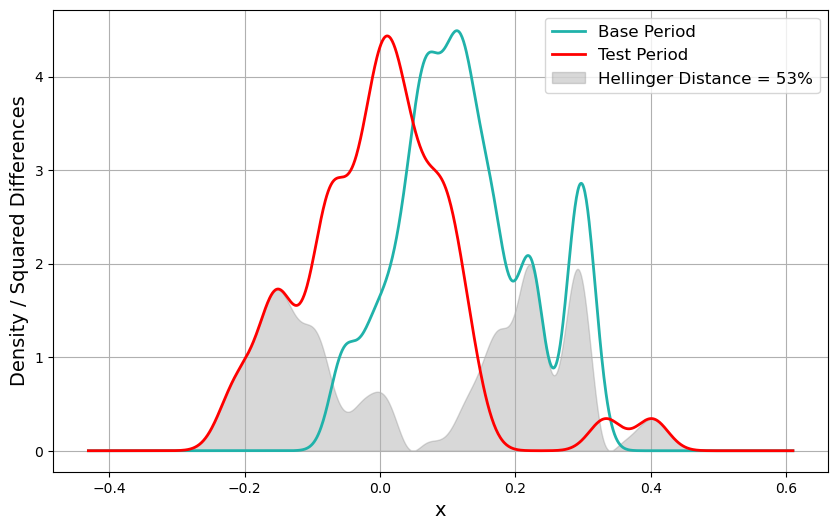

In [91]:
P = kde_vals1
Q = kde_vals2

squared_diff = (np.sqrt(P) - np.sqrt(Q))**2

hellinger_distance = np.sqrt(np.sum(squared_diff) * (x_kde[1] - x_kde[0])) / np.sqrt(2)

# Plot the original distributions
plt.figure(figsize=(10, 6))
plt.plot(x_kde, P, label=f'Base Period', color='lightseagreen', linewidth=2)
plt.plot(x_kde, Q, label=f'Test Period', color='red', linewidth=2)


# Fill the area under the squared differences
plt.fill_between(x_kde, 0, squared_diff, color='gray', alpha=0.3,
                 label=f'Hellinger Distance = {hellinger_distance*100:.0f}%')


# Add titles and labels
plt.xlabel('x', fontsize=14)
plt.ylabel('Density / Squared Differences', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True)


<h2 style='color: cyan'> Figure Merge </h2>

In [92]:
def convert_multi_to_name(arr):
    '''
    Same have the same ToE - so give just one line and bloth all with that lavel
    '''
    if len(arr) == 1:
        return toe_const.NAME_CONVERSION_DICT_SHORT.get(arr[0], arr[0])
    
    return '(' + ', '.join(toe_const.NAME_CONVERSION_DICT_SHORT.get(toe_metric, toe_metric) for toe_metric in arr) + ')'

In [129]:
SHCEMATIC_FIGURE_DICT = {
    'base_color': 'lightseagreen',
    'future_color': 'red', 
    'title_fontsize': 15,
    'other_text': 10,
    'labels': 14,
    'linewidth': 2,
    'tick_size':1,
    'legend_elements': 14
}

In [130]:
toe_df = toe_ds.to_pandas().astype(int)
toe_df

sn_poly4      1936
sn            1928
sn_rolling    1929
sn_anom       1965
ks            1928
ttest         1928
anderson      1927
perkins       1928
frac          1928
hd            1945
nn            1979
dtype: int64

In [131]:
main_metrics = ['sn_poly4','sn', 'sn_rolling' ,'sn_anom', 'ks', 'perkins', 'frac', 'hd', 'nn']
toe_subset_df = toe_df[main_metrics]
toe_labels = toe_subset_df.groupby(toe_subset_df).apply(lambda x: list(x.index))
toe_labels = toe_labels.apply(lambda x: convert_multi_to_name(x))
toe_labels

1928    (S/N, KS, PSS, FGA)
1929             S/N (Mean)
1936         S/N (4th-Poly)
1945                     HD
1965             S/N (Anom)
1979                     NN
dtype: object

In [132]:
def format_timeseries_ax(ax):
    ax.set_xlim(1847, 2020)
    ax.grid(True, linestyle='--', color='grey', alpha=0.6)
    ax.set_xticks(np.arange(1850, 2020, 25));
    ax.set_xlabel("Year", fontsize=SHCEMATIC_FIGURE_DICT['labels'])

In [133]:
def change_tick_size(ax, tick_size=6, label_size:float=SHCEMATIC_FIGURE_DICT['labels']):

    ax.tick_params(axis='x', which='both', size=SHCEMATIC_FIGURE_DICT['tick_size'], labelsize=label_size)
    ax.tick_params(axis='y', which='both', size=SHCEMATIC_FIGURE_DICT['tick_size'], labelsize=label_size)

In [181]:
def overlap_figure(
    fig: Optional[Figure] = None,
    ax1: Optional[Axes] = None,
    ax2: Optional[Axes] = None,
    ax3: Optional[Axes] = None
) -> Tuple[Figure, Axes, Axes, Axes]:
    
    if fig is None or ax1 is None or ax2 is None:
        fig = plt.figure(figsize=(18, 4))
        ax1 = fig.add_subplot(131)
        ax2 = fig.add_subplot(132)
        ax3 = fig.add_subplot(133)

    axes = [ax1, ax2, ax3]

    for ax in axes:
        ax.axvline(0, color='k', alpha=0.4)

    start_year = int(best_ds_smean.time.dt.year.values[0])
    base_arr = best_ds_smean.isel(time=slice(0, 50))
    
    fgs_emergence_year = 1928
    # This will be the arguement for the start of the 30 year base period 
    # 
    start_arr = fgs_emergence_year - start_year - 15# + 4
    # print(start_arr)

    arr = best_ds_smean.isel(time=slice(start_arr, start_arr+30)).values
    
    num_bins = 25
    
    bmax = 0.6#np.nanmax(np.concatenate([base_arr, arr]))*1.2
    bmin = -0.6#np.nanmin(np.concatenate([base_arr, arr]))*1.2
    
    
    # Define the bin width and create bin edges
    bins = np.linspace(bmin, bmax, num_bins)
    
    _, pdf_base = toe.discrete_pdf(base_arr, bins)
    _, pdf_arr = toe.discrete_pdf(arr, bins)
    
    pps_overlap = toe.discrete_distribution_overlap(pdf_base, pdf_arr)
    
    x_kde, kde_vals2, kde_vals1, fga_overlap = toe.fractional_geometric_area(
        base_arr, arr, return_all=True, method_kwargs=dict(bw_method=0.2), bmin=bmin, bmax=bmax)#'silverman'))

    
    ax1.bar(bins[:-1], pdf_base, width=np.diff(bins), align='edge', label='Base Period',
           color=SHCEMATIC_FIGURE_DICT['base_color'], alpha=0.5, edgecolor='k')
    ax1.bar(bins[:-1], pdf_arr, width=np.diff(bins), align='edge', label='Future Climate',
           color=SHCEMATIC_FIGURE_DICT['future_color'], alpha=0.5, edgecolor='k')
    
    
    ### FGA
    ax2.plot(x_kde, kde_vals1, color=SHCEMATIC_FIGURE_DICT['base_color'], #label='Base Period', 
            linewidth=SHCEMATIC_FIGURE_DICT['linewidth'])
    ax2.plot(x_kde, kde_vals2, color=SHCEMATIC_FIGURE_DICT['future_color'],# label='Future Climate',
            linewidth=SHCEMATIC_FIGURE_DICT['linewidth'])
    ax2.fill_between(x_kde, 0, np.min(np.vstack([kde_vals1, kde_vals2]), axis=0),
                     color='gray', alpha=0.3, label='Distribution\nOverlap')
    
    #### Hellinger Distance
    squared_diff = (np.sqrt(kde_vals1) - np.sqrt(kde_vals2))**2
    hellinger_distance = np.sqrt(np.sum(squared_diff) * (x_kde[1] - x_kde[0])) / np.sqrt(2)
    
    # Plot the original distributions
    ax3.plot(x_kde, kde_vals1, #label=f'Base Period',
             color=SHCEMATIC_FIGURE_DICT['base_color'],
             linewidth=SHCEMATIC_FIGURE_DICT['linewidth'])
    ax3.plot(x_kde, kde_vals2, #label=f'Test Period',
             color=SHCEMATIC_FIGURE_DICT['future_color'],
             linewidth=SHCEMATIC_FIGURE_DICT['linewidth'])
    
    
    #ax3Fill the area under the squared differences
    plt.fill_between(x_kde, 0, squared_diff, color='gray', alpha=0.3,
                     label=f'Squared\nDifferences')
    
    # Add titles and labels
    for ax in axes:
        change_tick_size(ax)
        ax.set_xlim(-0.8, 0.8)
        ax.set_ylim(0, None)
    ax2.set_xlabel(r'Tempeature Anomaly ($^\circ$C)', fontsize=SHCEMATIC_FIGURE_DICT['labels'])

    ax1.set_ylabel('Relative Frequency', fontsize=SHCEMATIC_FIGURE_DICT['labels'])
    ax2.set_ylabel('Probability', fontsize=SHCEMATIC_FIGURE_DICT['labels'])
    ax3.set_ylabel('Probability', fontsize=SHCEMATIC_FIGURE_DICT['labels'])
    
    ax1.set_title(f'Perkins Skill Score ({pps_overlap:.0f}%)', fontsize=SHCEMATIC_FIGURE_DICT['title_fontsize'])
    ax2.set_title(f'Fractional\nGeometric Area ({fga_overlap:.0f}%)', fontsize=SHCEMATIC_FIGURE_DICT['title_fontsize'])
    ax3.set_title(f'Hellinger Distance ({hellinger_distance*100:.0f}%)', fontsize=SHCEMATIC_FIGURE_DICT['title_fontsize'])
    bbox_to_anchor = (1.7, -0.38)
    ax1.legend(loc='lower center', fontsize=SHCEMATIC_FIGURE_DICT['legend_elements'], ncol=2, bbox_to_anchor=bbox_to_anchor)
    ax2.legend(loc='upper left', fontsize=SHCEMATIC_FIGURE_DICT['legend_elements'], ncol=2)#bbox_to_anchor=bbox_to_anchor)
    ax3.legend(loc='upper left', fontsize=SHCEMATIC_FIGURE_DICT['legend_elements'], ncol=2) #bbox_to_anchor=bbox_to_anchor)

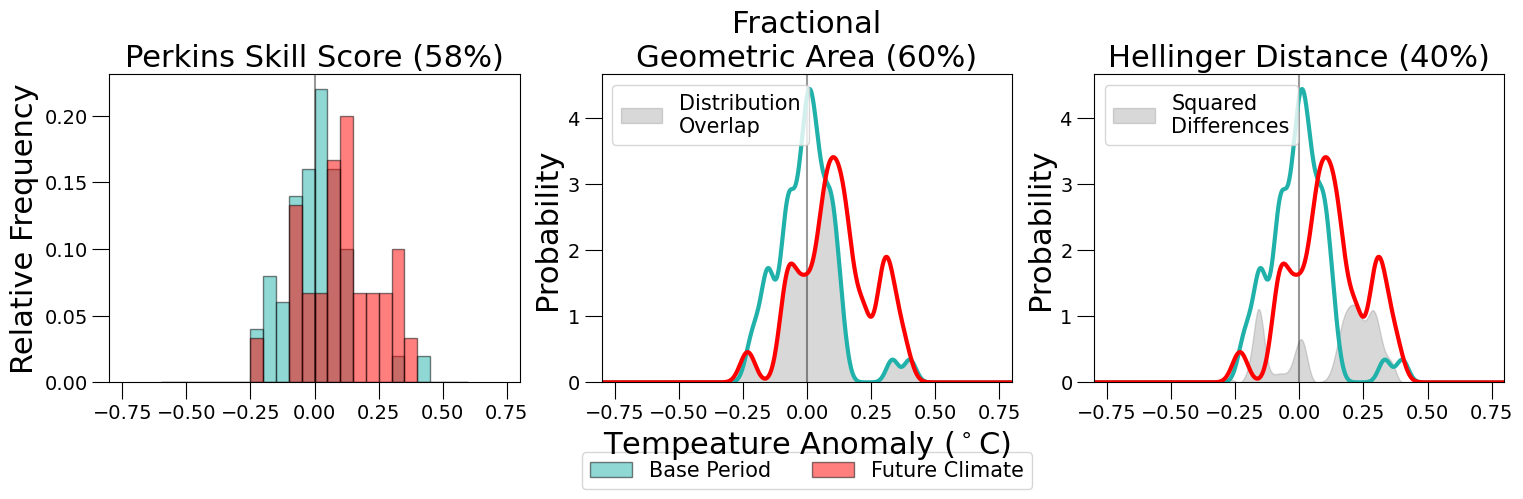

In [182]:
overlap_figure()

In [136]:
def overlap_figure_v2(
    fig: Optional[Figure] = None,
    ax1: Optional[Axes] = None,
    ax2: Optional[Axes] = None,
) -> Tuple[Figure, Axes, Axes, Axes]:
    
    if fig is None or ax1 is None or ax2 is None:
        fig = plt.figure(figsize=(12, 3))
        ax1 = fig.add_subplot(131)
        ax2 = fig.add_subplot(132)

    axes = [ax1, ax2]
    ax3 = ax2

    for ax in axes:
        ax.axvline(0, color='k', alpha=0.4)

    start_year = int(best_ds_smean.time.dt.year.values[0])
    base_arr = best_ds_smean.isel(time=slice(0, 50))
    
    fgs_emergence_year = 1928
    # This will be the arguement for the start of the 30 year base period 
    # 
    start_arr = fgs_emergence_year - start_year - 15# + 4
    # print(start_arr)

    arr = best_ds_smean.isel(time=slice(start_arr, start_arr+30)).values
    
    num_bins = 25
    
    bmax = 0.6#np.nanmax(np.concatenate([base_arr, arr]))*1.2
    bmin = -0.6#np.nanmin(np.concatenate([base_arr, arr]))*1.2
    
    
    # Define the bin width and create bin edges
    bins = np.linspace(bmin, bmax, num_bins)
    
    _, pdf_base = toe.discrete_pdf(base_arr, bins)
    _, pdf_arr = toe.discrete_pdf(arr, bins)
    
    pps_overlap = toe.discrete_distribution_overlap(pdf_base, pdf_arr)
    
    x_kde, kde_vals2, kde_vals1, fga_overlap = toe.fractional_geometric_area(
        base_arr, arr, return_all=True, method_kwargs=dict(bw_method=0.2), bmin=bmin, bmax=bmax)#'silverman'))

    
    ax1.bar(bins[:-1], pdf_base, width=np.diff(bins), align='edge', label='Base Period',
           color=SHCEMATIC_FIGURE_DICT['base_color'], alpha=0.5, edgecolor='k')
    ax1.bar(bins[:-1], pdf_arr, width=np.diff(bins), align='edge', label='Base Period',
           color=SHCEMATIC_FIGURE_DICT['future_color'], alpha=0.5, edgecolor='k')
    
    
    ### FGA
    ax2.plot(x_kde, kde_vals1, color=SHCEMATIC_FIGURE_DICT['base_color'], label='Base Period', 
            linewidth=SHCEMATIC_FIGURE_DICT['linewidth'])
    ax2.plot(x_kde, kde_vals2, color=SHCEMATIC_FIGURE_DICT['future_color'], label='Future Climate',
            linewidth=SHCEMATIC_FIGURE_DICT['linewidth'])
    ax2.fill_between(x_kde, 0, np.min(np.vstack([kde_vals1, kde_vals2]), axis=0),
                     color='gray', alpha=0.3)
    
    #### Hellinger Distance
    squared_diff = (np.sqrt(kde_vals1) - np.sqrt(kde_vals2))**2
    hellinger_distance = np.sqrt(np.sum(squared_diff) * (x_kde[1] - x_kde[0])) / np.sqrt(2)
    
    # Plot the original distributions
    # ax3.plot(x_kde, kde_vals1, label=f'Base Period', color=SHCEMATIC_FIGURE_DICT['base_color'],
    #          linewidth=SHCEMATIC_FIGURE_DICT['linewidth'])
    # ax3.plot(x_kde, kde_vals2, label=f'Test Period', color=SHCEMATIC_FIGURE_DICT['future_color'],
    #          linewidth=SHCEMATIC_FIGURE_DICT['linewidth'])
    
    
    #ax3Fill the area under the squared differences
    plt.fill_between(x_kde, 0, squared_diff, color='blue', alpha=0.3,
                     label=f'Squared Differences')
    
    # Add titles and labels
    for ax in axes:
        change_tick_size(ax)
        ax.set_xlim(-0.6, 0.6)
        ax.set_ylim(0, None)
    ax2.set_xlabel(r'Tempeature Anomaly ($^\circ$C)', fontsize=SHCEMATIC_FIGURE_DICT['labels'])

    ax1.set_ylabel('Relative Frequency', fontsize=SHCEMATIC_FIGURE_DICT['labels'])
    ax2.set_ylabel('Probability', fontsize=SHCEMATIC_FIGURE_DICT['labels'])
    # ax3.set_ylabel('Probability', fontsize=SHCEMATIC_FIGURE_DICT['labels'])
    
    ax1.set_title(f'Perkins Skill Score ({pps_overlap:.0f}%)', fontsize=SHCEMATIC_FIGURE_DICT['title_fontsize'])
    ax2.set_title(f'Fractional Geometric Area ({fga_overlap:.0f}%)', fontsize=SHCEMATIC_FIGURE_DICT['title_fontsize'])
    # ax3.set_title(f'Hellinger Distance ({hellinger_distance*100:.0f}%)', fontsize=SHCEMATIC_FIGURE_DICT['title_fontsize'])
    
    ax2.legend(loc='lower center', fontsize=SHCEMATIC_FIGURE_DICT['other_text'], ncol=2, bbox_to_anchor=(0.5, -0.5))

In [137]:
# overlap_figure_v2()

In [138]:
# def get_color_cycle():
    # return cycle(['royalblue', 'darkorange', 'forestgreen', 'goldenrod', 'mediumslateblue'])

# colors = ['CadetBlue', 'DarkOliveGreen', 'Goldenrod', 'MediumPurple', 'SlateBlue', 'Tomato']
colors = ['chocolate', 'hotpink', 'lightseagreen', 'blueviolet', 'goldenrod', 'lightslategray', 'tomato'] 

In [139]:
year = 1928

In [140]:
time = best_ds_smean.time.dt.year.values

vals = best_ds_smean.values

In [141]:
vals[time == year]

array([0.11646762], dtype=float32)

In [142]:
def plot_gmst_and_toe(fig=None, ax=None):
    main_metrics = ['PSS', 'KS', 'Mean']
    if fig is None and ax is None:
        fig = plt.figure(figsize=(12, 6))
        
        ax = fig.add_subplot(111)
    
    # color_cycle = get_color_cycle()
    time = best_ds_smean.time.dt.year.values
    arr = best_ds_smean.values
    ax.plot(time, arr,linewidth=SHCEMATIC_FIGURE_DICT['linewidth'])

    for i, (year, toe_metrics) in enumerate(toe_labels.items()):
        # color = toe_plots.TEST_PLOT_DICT[metric_arr[0]]['color']
        colour = colors[i]
        if not any([mm in toe_metrics for mm in main_metrics]):
            line_format_dict = dict(linestyle='-', alpha=0.5, linewidth = SHCEMATIC_FIGURE_DICT['linewidth']+0.5)
        else: line_format_dict = dict(linestyle='-', alpha=1, linewidth = SHCEMATIC_FIGURE_DICT['linewidth']+0.5)
        # print(toe_metrics, colour, '\n')
        # print(toe_metrics)
        final_label = toe_metrics#f'{i}. '+ toe_metrics
        yval = arr[time==year][0] 
        # print(arr.shape, time.shape, year)
        ax.plot([year, year], [-0.35,yval], color=colour, label=final_label, **line_format_dict)
        ax.scatter([year], [yval], color=colour, s=50, zorder=100)
        # print(final_label)
        # ax.axvline(year, color=colour, label=final_label, **line_format_dict)
        
        # match i:
        #     case 1: xval = year - 0.5 # Case i =1 (this is for 2.)
        #     case 2: xval = year + 0.5 # Case i =2 (this is for 3.)
        #     case _: xval = year

        # xval_dict = {1: year - 0.5, 2: year + 0.5}
        # xval = xval_dict.get(i, year)
        # ax.annotate(i+1, xy=(xval, 1.02), xycoords=('data','axes fraction'), color=colour, ha='center', va='center')
    
    leg = ax.legend(fontsize=SHCEMATIC_FIGURE_DICT['labels'], labelspacing=0.2, handletextpad=0.2, loc='upper left', ncol=2)
    leg.set_title('Method')
    leg.get_title().set_fontsize(SHCEMATIC_FIGURE_DICT['labels'])

     
    ax1 = ax
    
    ylower = ax1.get_ylim()[0]
    ax1.plot([1850, 1850], [ylower, 0.5], linewidth=2, color=SHCEMATIC_FIGURE_DICT['base_color'])
    ax1.plot([1900, 1900], [ylower, 0.5], linewidth=2, color=SHCEMATIC_FIGURE_DICT['base_color'])
    ax1.plot([1850, 2025], [0, 0], color=SHCEMATIC_FIGURE_DICT['base_color'], linewidth=2, linestyle='--')
    # ax1.plot([1850, 1900], [0, 0], color='green', linewidth=5)
    ax1.plot([1850, 1900], [ylower, ylower], color=SHCEMATIC_FIGURE_DICT['base_color'], linewidth=2)
    ax1.plot([1850, 1900], [0.5, 0.5], color=SHCEMATIC_FIGURE_DICT['base_color'], linewidth=2)
    ax1.annotate('Base Period', xy=(1875, 0.53), fontsize=SHCEMATIC_FIGURE_DICT['title_fontsize'], 
                 ha='center', color=SHCEMATIC_FIGURE_DICT['base_color'])
    ax.set_ylabel(r'GMST Anomaly ($^\circ$ C)', fontsize=SHCEMATIC_FIGURE_DICT['labels'])
    format_timeseries_ax(ax)
    change_tick_size(ax1)

    ax.set_ylim(-0.35, 1.5)

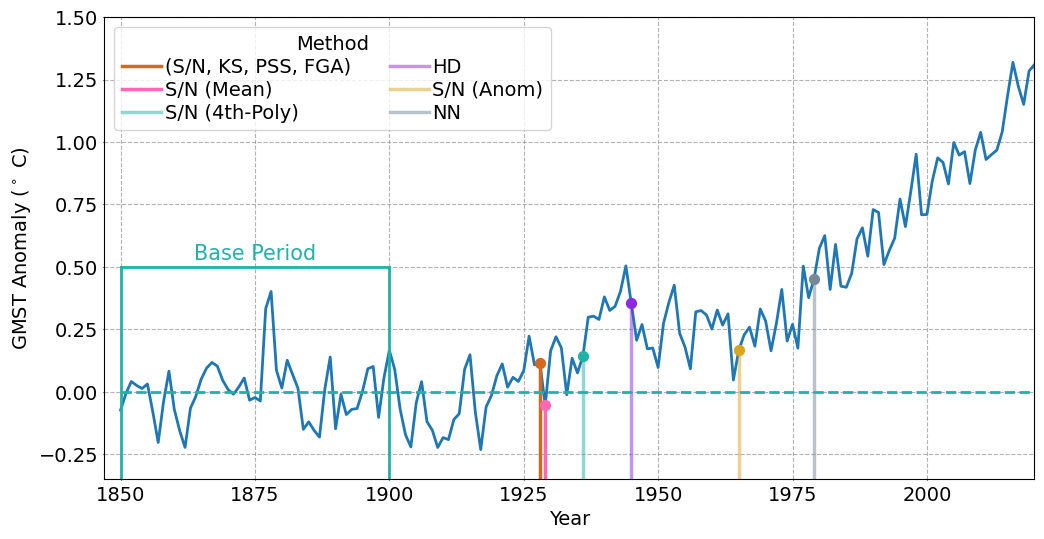

In [143]:
plot_gmst_and_toe()

In [144]:
def ks_test_figure_v2(
    fig: Optional[Figure] = None,
    ax: Optional[Axes] = None,
) -> Tuple[Figure, Axes, Axes]:
    
    if fig is None or ax1 is None or ax2 is None:
        fig, ax= plt.subplots(1, 1, figsize=(8, 6))
        
    # Assuming ks_emergence_year and base_period_tuple are already defined
    ks_emergence_year = int(toe_ds['ks'].values.item())
    base_period_end = base_period_tuple[-1]
    years = np.arange(0, 40, 3) # These are the years after the base period
    # The central year will be the end of the base period + 10 (ass middle of 20-years), +year
    central_years = base_period_end+10+years
    
    
    # Base array for comparison
    base_array = best_ds_smean.isel(time=slice(0, 50)).values  # Length 50
    ecdf_base = ECDF(base_array)
    ax.plot(ecdf_base.x, ecdf_base.y, color=SHCEMATIC_FIGURE_DICT['base_color'],
            linewidth=SHCEMATIC_FIGURE_DICT['linewidth'], label='CDF of Base Period ')
 
    # Loop through the years and calculate ECDFs, KS statistics, and p-values
    for year, central_year in zip(years, central_years):
    
        data2 = best_ds_smean.values[50 + year:70 + year]  # Second dataset (length 20)
        ecdf2 = ECDF(data2)
    
        # Compute KS statistic and p-value using ks_2samp
        #statistic, pvalue, statistic_location, statistic_sign 
        ks_result = ks_2samp(base_array, data2)  # Direct KS test
        ks_location = ks_result.statistic_location
        pvalue = ks_result.pvalue
        ks_statistic = ks_result.statistic
    

        # Set line width based on conditions
        # This is better then using p-value as that won't take into account permanent emergnece
        # plus-minus thee is ues as I am moving in blocks of 3
        if ks_emergence_year - 3 < central_year < ks_emergence_year + 3:
            ecdf_kwargs = dict(color=SHCEMATIC_FIGURE_DICT['future_color'], label='CDF at Emergence')
            ax.plot(ecdf2.x, ecdf2.y, linewidth=SHCEMATIC_FIGURE_DICT['linewidth'], **ecdf_kwargs)
            # Plot the maximum difference between the CDFs
            x_values = np.unique(np.concatenate((ecdf_base.x, ecdf2.x)))
            y_distances = np.abs(ecdf_base(x_values) - ecdf2(x_values))
            max_idx = np.argmax(y_distances)
            max_x = x_values[max_idx]
            max_y_base = ecdf_base(max_x)
            max_y_data2 = ecdf2(max_x)

            ax.plot([max_x, max_x],[max_y_base, max_y_data2+0.05],
                color='k', linestyle='--', linewidth=1.5,
                label=f'Max KS Statistic\n(D = {ks_statistic:.2f})'
            )
            ax.scatter([max_x], [max_y_base], color=SHCEMATIC_FIGURE_DICT['base_color'], zorder=1000)
            ax.scatter([max_x], [max_y_data2+0.05], color=SHCEMATIC_FIGURE_DICT['future_color'], zorder=1000)



 
    # Set labels, grid, and legend
    ax.set_ylabel('Cumulative Density', fontsize=SHCEMATIC_FIGURE_DICT['labels'])
    ax.set_xlabel('GMST Anomaly' + r' ($^\circ C$)', fontsize=SHCEMATIC_FIGURE_DICT['labels'])
    ax.grid(True, linestyle='--', color='grey', alpha=0.6)  
    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='x', labelsize=12)
    ax.set_ylim(0, 1.02)
    ax.set_title('Kolmogorov-Smirnov Test', fontsize=SHCEMATIC_FIGURE_DICT['title_fontsize'])
    ax.legend(fontsize=SHCEMATIC_FIGURE_DICT['legend_elements'])
    change_tick_size(ax)

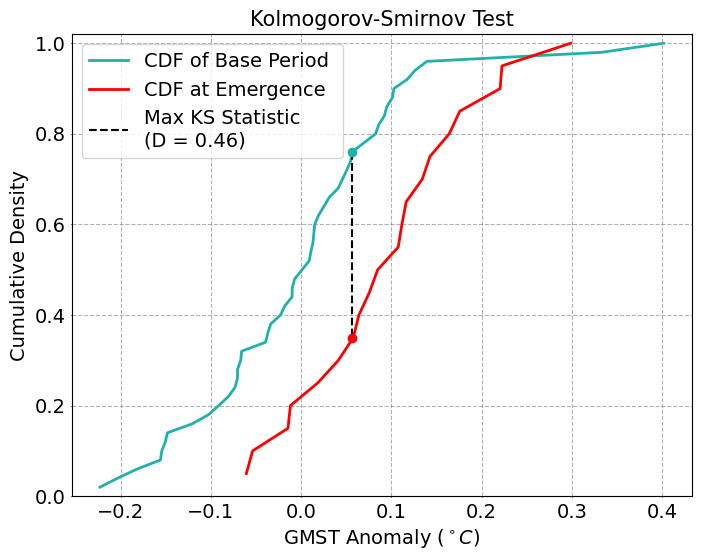

In [145]:
ks_test_figure_v2()

In [156]:
def sn_ratio_figure_v2(
    fig: Optional[Figure] = None,
    ax2: Optional[Axes] = None,
    fontscale:float=1, 
) -> Tuple[Figure, Axes, Axes]:
    
    if fig is None or ax1 is None or ax2 is None:
        fig, ax2= plt.subplots(1, 1, figsize=(8, 6))
        
    sn_vars = ['sn', 'sn_rolling', 'sn_poly4', 'sn_anom']#['sn_anom','sn_rolling', 'sn', 'sn_poly4']
    # color_cycle = get_color_cycle()
    colors_here = np.take(colors, [1,2,3,5])
    for i, sn_name in enumerate(sn_vars):
        alpha = 1 if 'anom' not in sn_name else 0.3
        ax2.plot(toe_metrics_ds.time.dt.year.values, toe_metrics_ds[sn_name].values, 
                 color=colors_here[i],
                 label=toe_const.NAME_CONVERSION_DICT_SHORT.get(sn_name, sn_name), linewidth=SHCEMATIC_FIGURE_DICT['linewidth'], alpha=alpha)
    
    ax2.legend(fontsize=SHCEMATIC_FIGURE_DICT['legend_elements'])
    format_timeseries_ax(ax2)
    xpost_label = 1851
    frame_lines = dict(linestyle='--', color='red')
    ax2.axhline(1, **frame_lines)
    ax2.annotate('Unusual', xy=(xpost_label, 1), va='bottom', size=SHCEMATIC_FIGURE_DICT['other_text'], color='red')
    ax2.axhline(2, **frame_lines)
    ax2.annotate('Unfamiliar', xy=(xpost_label, 2), va='bottom', size=SHCEMATIC_FIGURE_DICT['other_text'], color='red')
    ax2.axhline(3, **frame_lines)
    ax2.annotate('Unknown', xy=(xpost_label, 3), va='bottom', size=SHCEMATIC_FIGURE_DICT['other_text'], color='red')
    
    ax2.axhline(5, **frame_lines)
    ax2.annotate('Inconceivable', xy=(xpost_label, 5), va='bottom', size=SHCEMATIC_FIGURE_DICT['other_text'], color='red')
    ax2.set_ylabel('S/N Ratio', fontsize=SHCEMATIC_FIGURE_DICT['labels'])
    ax2.set_title('Signal-to-noise (S/N) Ratio', fontsize=SHCEMATIC_FIGURE_DICT['title_fontsize'])
    change_tick_size(ax2)

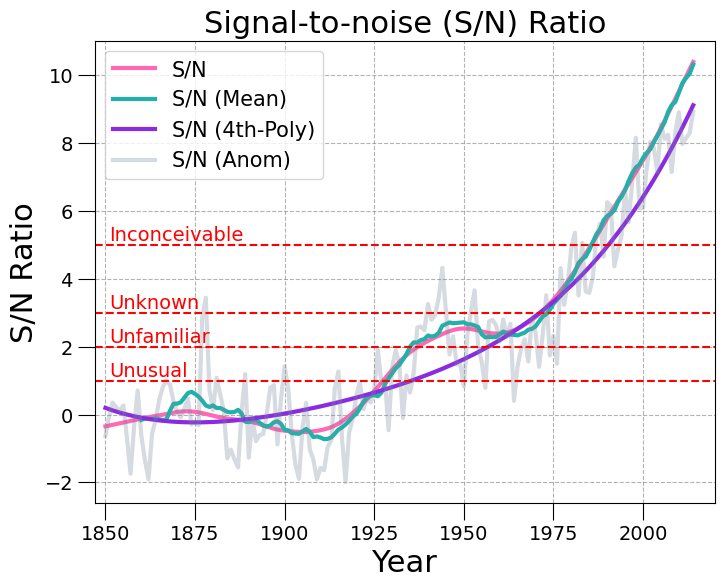

In [157]:
sn_ratio_figure_v2()

In [148]:
base_period_ds.max()

<xarray.DataArray 'temperature' ()> Size: 8B
0.4017

In [151]:
SHCEMATIC_FIGURE_DICT = {
    'base_color': 'lightseagreen',
    'future_color': 'red', 
    'title_fontsize': 22, #15
    'other_text': 14, #10
    'labels': 22, #15
    'legend_elements': 15, 
    'tick_size': 12,
    'linewidth': 3 #2
}

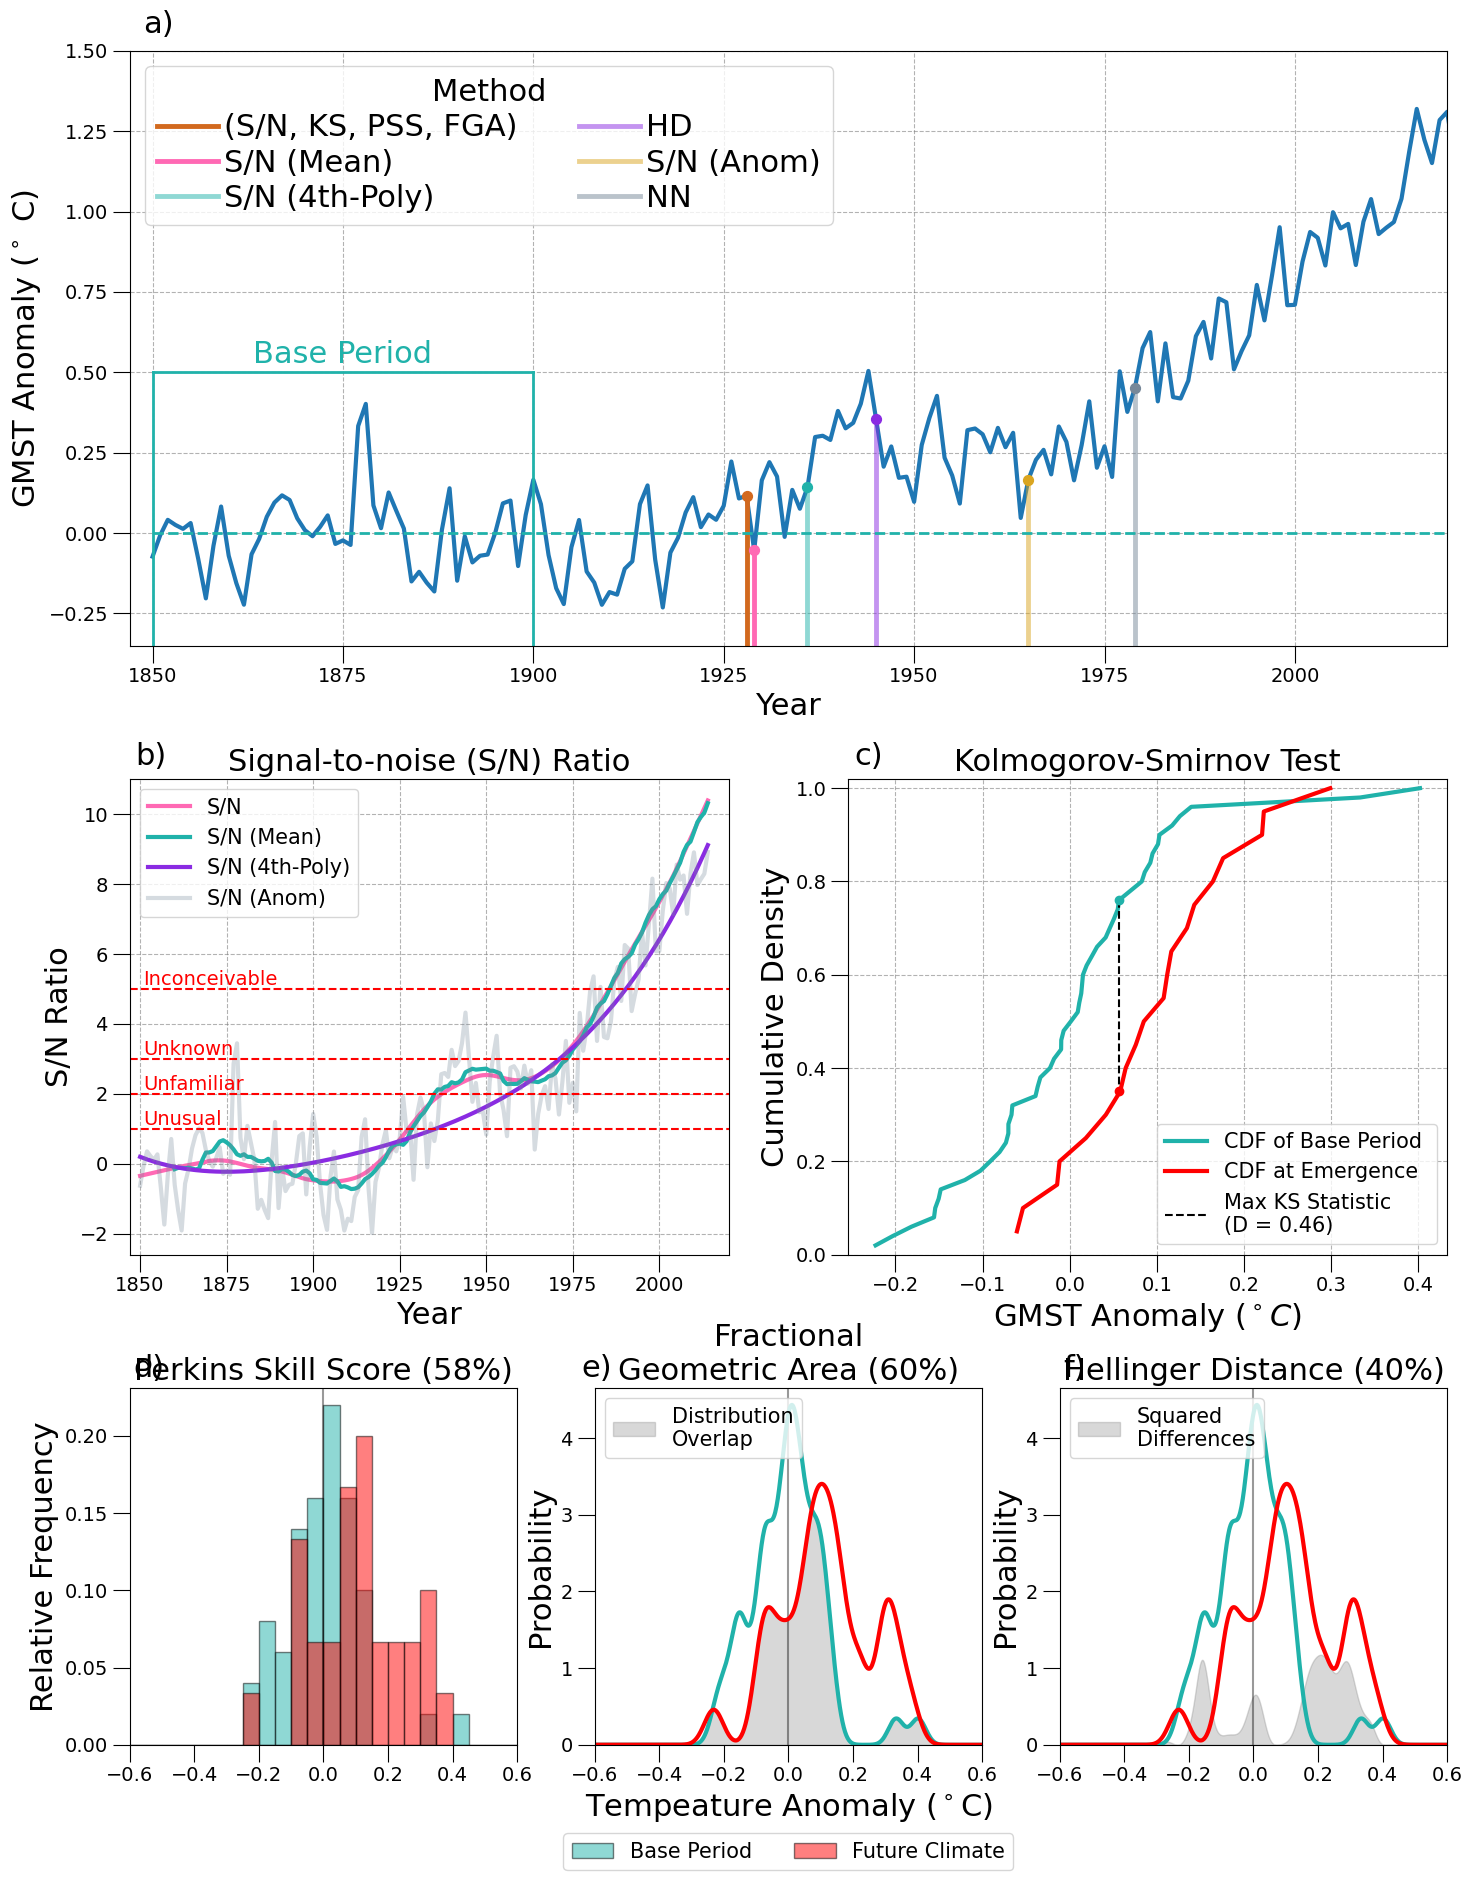

In [152]:
fig = plt.figure(figsize=(17, 22))
n_rows = 3  
gs = gridspec.GridSpec(n_rows, 2, height_ratios = [1, 0.8, 0.6], hspace=0.28)

ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

subgrid = gs[2, :].subgridspec(1, 3)
lower_axes = [fig.add_subplot(subgrid[i]) for i in range(3)]

axes = [ax1, ax2, ax3, *lower_axes]

plot_gmst_and_toe(fig, ax1)
sn_ratio_figure_v2(fig, ax2)
ks_test_figure_v2(fig, ax3)
overlap_figure(fig, *lower_axes)

for i, ax in enumerate(axes): 
    ax.annotate(f'{chr(97+i)})', xy=(0.01 if i != 4 else -0.035, 1.03),
                xycoords='axes fraction', fontsize=SHCEMATIC_FIGURE_DICT['title_fontsize'])

### Old

In [106]:

def sn_ratio_figure(
    fig: Optional[Figure] = None,
    ax1: Optional[Axes] = None,
    ax2: Optional[Axes] = None
) -> Tuple[Figure, Axes, Axes]:
    
    if fig is None or ax1 is None or ax2 is None:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 16))
    
    ### Upper aes
    time = ds_best_lowess.time.dt.year.values
    ax1.plot(time, best_ds_smean.values, linewidth=3, label='GMST')
    ax1.plot(time, ds_best_lowess.values, linewidth=3, label='LOWESS')
    
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_ylabel('GMST Anomaly', fontsize=22)
    ax1.set_xlabel('Year', fontsize=22)
    ax1.grid(True)
    
    ylower = ax1.get_ylim()[0]
    ax1.plot([1850, 1850], [ylower, 0.5], linewidth=3, color='green')
    ax1.plot([1900, 1900], [ylower, 0.5], linewidth=3, color='green')
    ax1.plot([1850, 2025], [0, 0], color='green', linewidth=3, linestyle='--')
    # ax1.plot([1850, 1900], [0, 0], color='green', linewidth=5)
    ax1.plot([1850, 1900], [ylower, ylower], color='green', linewidth=5)
    ax1.plot([1850, 1900], [0.5, 0.5], color='green', linewidth=5)
    
    
    itime = 135
    ax1.scatter(time[itime], ds_best_lowess.values[itime], marker='o', s=150,
              color='red')
    ax1.plot([time[itime], time[itime]], [0, ds_best_lowess.values[itime]],
           color='red', linewidth=3, linestyle='--')
    
    ax1.annotate('Signal', xy=(time[itime]+2, ds_best_lowess.values[itime]/2), fontsize=20, ha='left', 
                color='red', va='center')
    
    ax1.set_ylim(ylower, 1.55)
    ax1.annotate('Base Period', xy=(1875, 0.53), fontsize=20, ha='center', color='green')
    
    ax1.set_xlim(1848, 2025)
    
    
    
    ### Lower axes
    
    time = ds_best_sn.time.dt.year.values
    ax2.plot(time, ds_best_sn.values, linewidth=3)
    
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.set_ylabel('S/N Ratio', fontsize=22)
    ax2.set_xlabel('Year', fontsize=22)
    ax2.grid(True)
    
    
    ax2.set_xlim(1848, 2025)
    
    
    frame_lines = dict(linestyle='--', color='red')
    ax2.axhline(1, **frame_lines)
    ax2.annotate('Unusual', xy=(1861, 1), va='bottom', size=15, color='red')
    ax2.axhline(2, **frame_lines)
    ax2.annotate('Unfamiliar', xy=(1861, 2), va='bottom', size=15, color='red')
    ax2.axhline(3, **frame_lines)
    ax2.annotate('Unknown', xy=(1861, 3), va='bottom', size=15, color='red')
    
    ax2.axhline(5, **frame_lines)
    ax2.annotate('Inconceivable', xy=(1861, 5), va='bottom', size=15, color='red')
    
    ax1.legend()

In [107]:
def ks_test_figure(
    fig: Optional[Figure] = None,
    ax: Optional[Axes] = None,
    ax2: Optional[Axes] = None
) -> Tuple[Figure, Axes, Axes]:
    
    if fig is None or ax1 is None or ax2 is None:
        fig, (ax2, ax) = plt.subplots(1, 2, figsize=(16, 6))
        
    # Assuming ks_emergence_year and base_period_tuple are already defined
    ks_emergence_year = int(toe_ds['ks'].values.item())
    base_period_end = base_period_tuple[-1]
    year_until_emergence = ks_emergence_year - base_period_end
    years = np.arange(0, 40, 3) # These are the years after the base period
    # The central year will be the end of the base period + 10 (ass middle of 20-years), +year
    central_years = base_period_end+10+years
    years, central_years
    
    # Set up your plot
    
    ax2.plot(best_ds_smean.time.dt.year.values, best_ds_smean.values)
    # Green base period annotations
    ylower = ax2.get_ylim()[0]
    upper_box = 0.45
    box_line_width = 3
    ax2.plot([1850, 1850], [ylower+0.05, upper_box], linewidth=box_line_width, color='green')
    ax2.plot([1900, 1900], [ylower+0.05, upper_box], linewidth=box_line_width, color='green')
    # ax2.plot([1850, 2025], [0, 0], color='green', linewidth=2, linestyle='--')
    # ax2.plot([1850, 1900], [0, 0], color='green', linewidth=2)
    ax2.plot([1850, 1900], [ylower+0.05, ylower+0.05], color='green', linewidth=box_line_width)
    ax2.plot([1850, 1900], [upper_box, upper_box], color='green', linewidth=box_line_width)
    
    ax2.annotate('Base Period', xy=(1875, 0.5), fontsize=22, ha='center', color='green')
    
    ax2.set_xlim(1849, 1960)
    ax2.grid(True, which='both', linestyle='--', color='grey', alpha=0.7)
    
    # Base array for comparison
    base_array = best_ds_smean.isel(time=slice(0, 50)).values  # Length 50
    ecdf_base = ECDF(base_array)
    ax.plot(ecdf_base.x, ecdf_base.y, color='green', linewidth=3, label='1850-1900\n(Base Period)')
    
    # Prepare to calculate KS statistics and p-values
    ks_statistics = []
    ks_statistics2 = []
    
    p_values = []
    
    # Set up color maps
    cmap1 = cm.get_cmap('Blues', sum(central_years < ks_emergence_year) + 3)  
    cmap2 = cm.get_cmap('Reds', sum(central_years >= ks_emergence_year) + 3) 
    
    # Loop through the years and calculate ECDFs, KS statistics, and p-values
    count = 3
    for year, central_year in zip(years, central_years):
    
        data2 = best_ds_smean.values[50 + year:70 + year]  # Second dataset (length 20)
        ecdf2 = ECDF(data2)
        
    
        # Compute KS statistic and p-value using ks_2samp
        ks_statistic2, p_value = ks_2samp(base_array, data2)  # Direct KS test
    
    
        # Get color from colormap
        if central_year < ks_emergence_year:
            color = cmap1(count)
            count += 1
        else:
            color = cmap2(count) 
            count += 1
    
            # Set line width based on conditions
        if ks_emergence_year - 3 < central_year < ks_emergence_year + 3:
            linewidth = 3
            count = 3
            linewidth_ax2 = 5
            color='magenta'
            
        else:
            color='green'
            linewidth = 1
            linewidth_ax2 = 2
    
        # Plot the ECDF for the second dataset
        if p_value < 0.01:
        #     p_value_str = '<0.01'
        # else:
        #     p_value_str = f'{p_value:.2f}'
    
            year_str = f'{central_year-10}-{central_year+10}'
            ax.plot(ecdf2.x, ecdf2.y, color=color,
                    label=f'{year_str} ({p_value_str})', linewidth=linewidth)
        
            data2_mean = np.nanmean(data2)
            ax2.plot([base_period_end + year, base_period_end+ 20 + year], [data2_mean, data2_mean],
                    color=color, linewidth=linewidth_ax2, alpha=0.85)
            break
    
    
    
    # Set labels, grid, and legend
    ax.set_ylabel('Cumulative Density', fontsize=22)
    ax.set_xlabel('GMST Anomaly' + r' ($^\circ C$)', fontsize=22)
    ax2.set_ylabel('GMST Anomaly' + r' ($^\circ C$)', fontsize=22)
    ax2.set_xlabel('Year', fontsize=22)
    
    ax.grid(True)
    # ax.legend(loc='right', bbox_to_anchor=[1.0, 0.35], fontsize=8)
    
    ax.tick_params(axis='y', labelsize=20)
    ax.tick_params(axis='x', labelsize=20)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.tick_params(axis='x', labelsize=20)
    
    ax.set_ylim(0, 1.02)
    
    ax2.set_ylim(-0.3, 0.75)
    
    ax2.set_title('GMST Time Series', fontsize=22)
    ax.set_title('CDFs', fontsize=22)

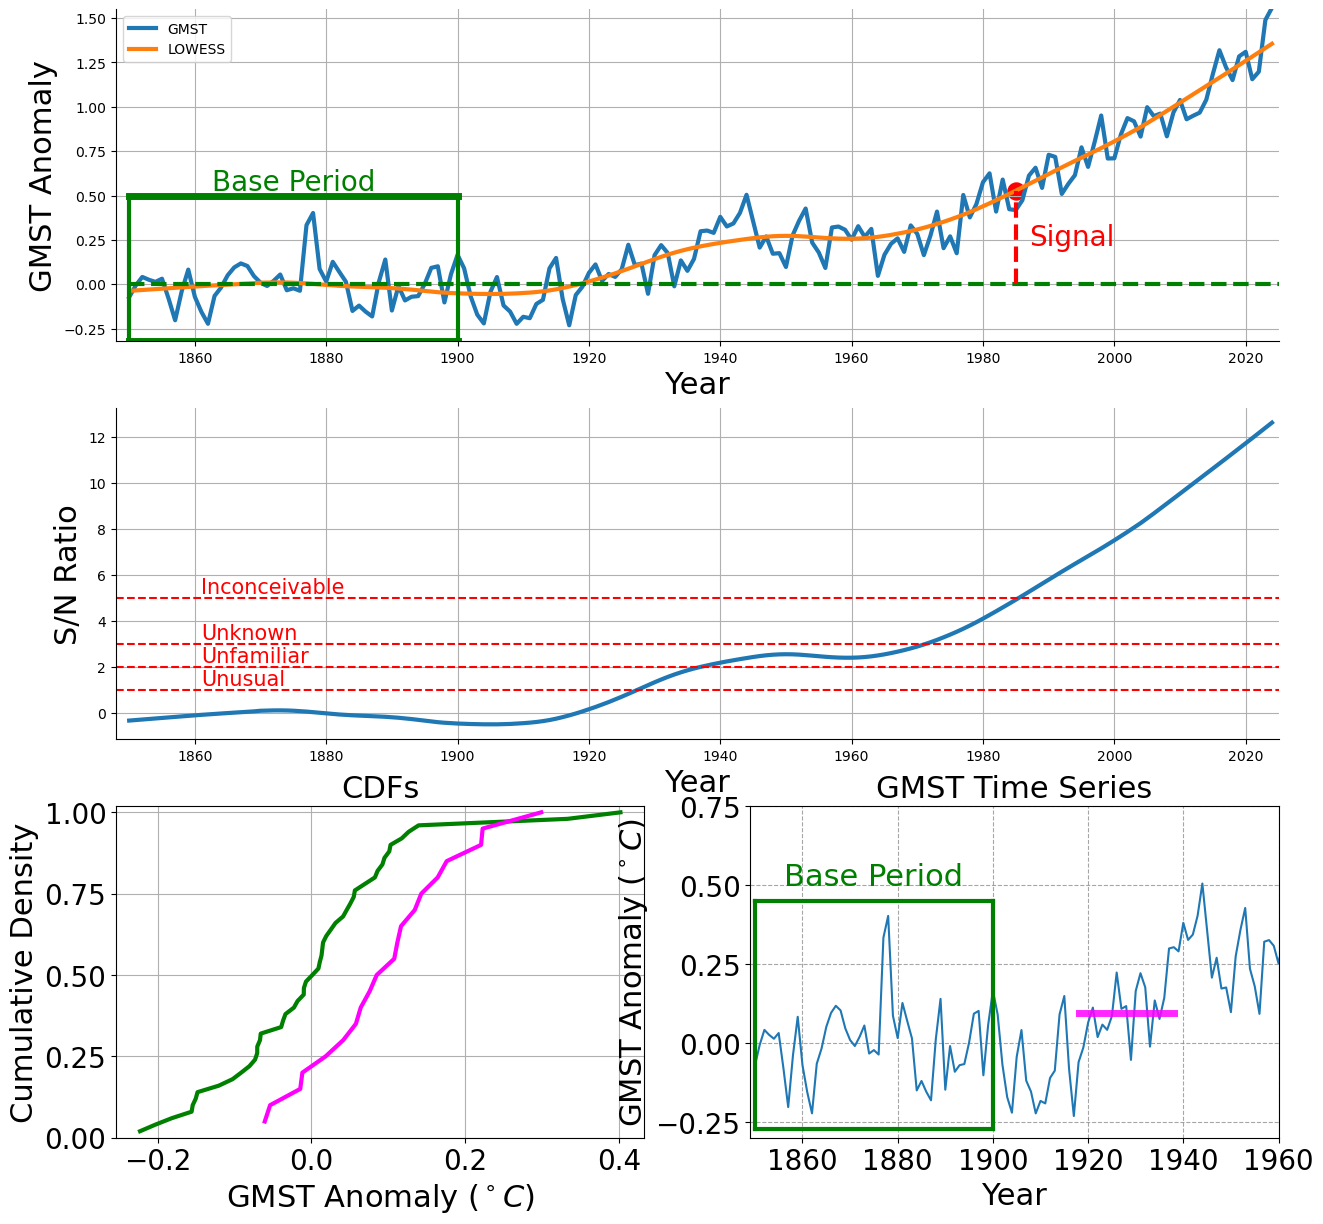

In [108]:
fig = plt.figure(figsize=(15, 25))
n_rows = 5
gs = gridspec.GridSpec(n_rows, 2)

sn_axes = [fig.add_subplot(gs[i, :]) for i in range(2)]
ks_axes = [fig.add_subplot(gs[2, i]) for i in range(2)]

sn_ratio_figure(fig, *sn_axes)
ks_test_figure(fig, *ks_axes)

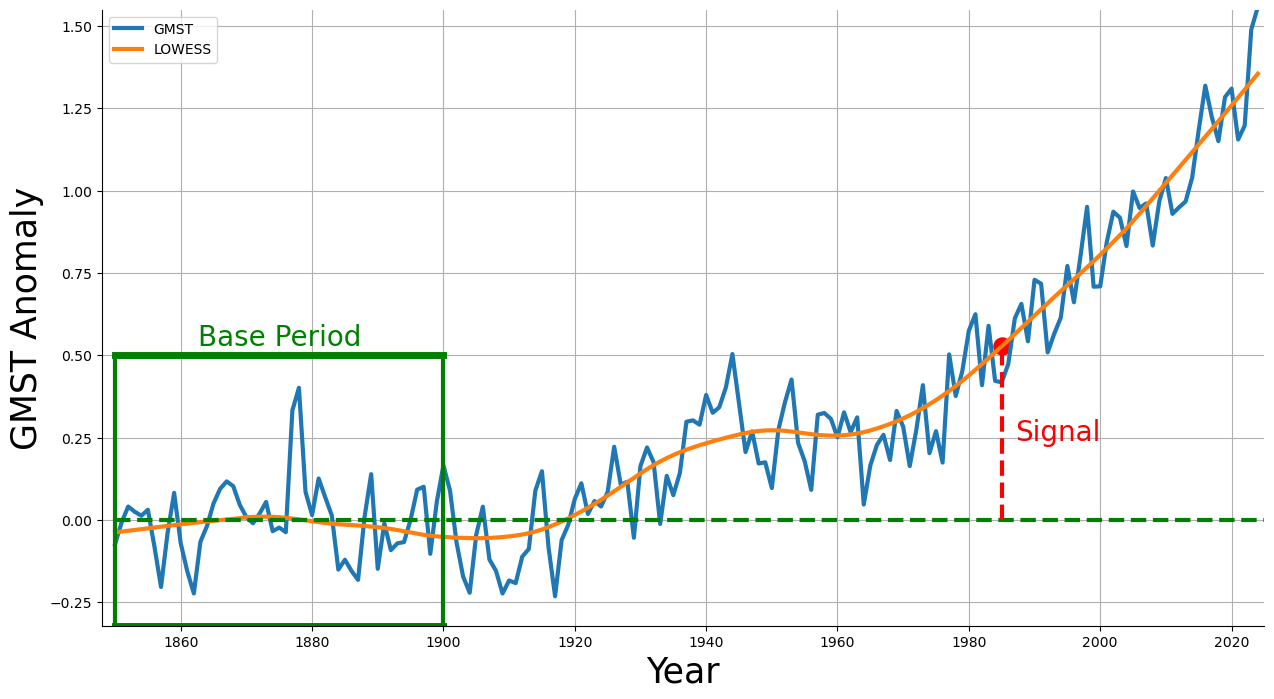

In [109]:

fig, ax1 = plt.subplots(1, 1, figsize=(15, 8))

### Upper aes
time = ds_best_lowess.time.dt.year.values
ax1.plot(time, best_ds_smean.values, linewidth=3, label='GMST')
ax1.plot(time, ds_best_lowess.values, linewidth=3, label='LOWESS')

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_ylabel('GMST Anomaly', fontsize=25)
ax1.set_xlabel('Year', fontsize=25)
ax1.grid(True)

ylower = ax1.get_ylim()[0]
ax1.plot([1850, 1850], [ylower, 0.5], linewidth=3, color='green')
ax1.plot([1900, 1900], [ylower, 0.5], linewidth=3, color='green')
ax1.plot([1850, 2025], [0, 0], color='green', linewidth=3, linestyle='--')
# ax1.plot([1850, 1900], [0, 0], color='green', linewidth=5)
ax1.plot([1850, 1900], [ylower, ylower], color='green', linewidth=5)
ax1.plot([1850, 1900], [0.5, 0.5], color='green', linewidth=5)


itime = 135
ax1.scatter(time[itime], ds_best_lowess.values[itime], marker='o', s=150,
          color='red')
ax1.plot([time[itime], time[itime]], [0, ds_best_lowess.values[itime]],
       color='red', linewidth=3, linestyle='--')

ax1.annotate('Signal', xy=(time[itime]+2, ds_best_lowess.values[itime]/2), fontsize=20, ha='left', 
            color='red', va='center')

ax1.set_ylim(ylower, 1.55)
ax1.annotate('Base Period', xy=(1875, 0.53), fontsize=20, ha='center', color='green')

ax1.set_xlim(1848, 2025)

ax1.legend()

In [110]:
# Assuming ks_emergence_year and base_period_tuple are already defined
ks_emergence_year = int(toe_ds['ks'].values.item())
base_period_end = base_period_tuple[-1]
year_until_emergence = ks_emergence_year - base_period_end
years = np.arange(0, 40, 3) # These are the years after the base period
# The central year will be the end of the base period + 10 (ass middle of 20-years), +year
central_years = base_period_end+10+years
years, central_years

(array([ 0,  3,  6,  9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39]),
 array([1910, 1913, 1916, 1919, 1922, 1925, 1928, 1931, 1934, 1937, 1940,
        1943, 1946, 1949]))

Text(0.5, 1.0, 'CDFs')

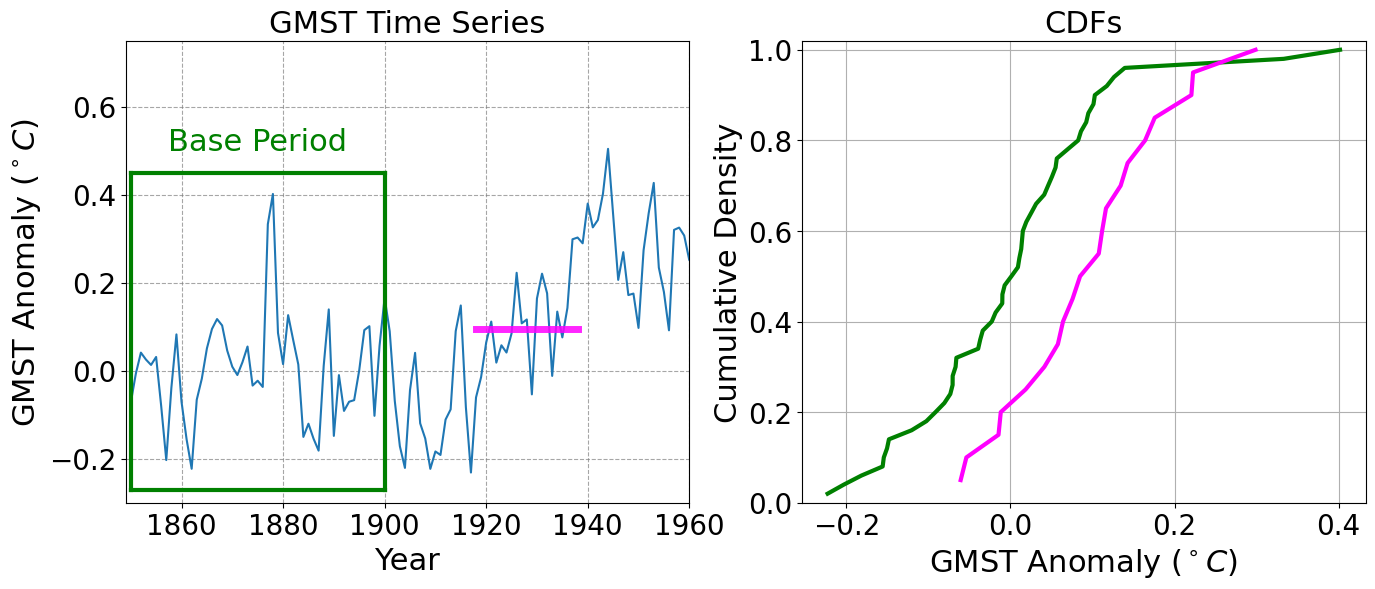

In [111]:
# Set up your plot
fig, (ax2, ax) = plt.subplots(1, 2, figsize=(16, 6))

ax2.plot(best_ds_smean.time.dt.year.values, best_ds_smean.values)
# Green base period annotations
ylower = ax2.get_ylim()[0]
upper_box = 0.45
box_line_width = 3
ax2.plot([1850, 1850], [ylower+0.05, upper_box], linewidth=box_line_width, color='green')
ax2.plot([1900, 1900], [ylower+0.05, upper_box], linewidth=box_line_width, color='green')
# ax2.plot([1850, 2025], [0, 0], color='green', linewidth=2, linestyle='--')
# ax2.plot([1850, 1900], [0, 0], color='green', linewidth=2)
ax2.plot([1850, 1900], [ylower+0.05, ylower+0.05], color='green', linewidth=box_line_width)
ax2.plot([1850, 1900], [upper_box, upper_box], color='green', linewidth=box_line_width)

ax2.annotate('Base Period', xy=(1875, 0.5), fontsize=22, ha='center', color='green')

ax2.set_xlim(1849, 1960)
ax2.grid(True, which='both', linestyle='--', color='grey', alpha=0.7)

# Base array for comparison
base_array = best_ds_smean.isel(time=slice(0, 50)).values  # Length 50
ecdf_base = ECDF(base_array)
ax.plot(ecdf_base.x, ecdf_base.y, color='green', linewidth=3, label='1850-1900\n(Base Period)')

# Prepare to calculate KS statistics and p-values
ks_statistics = []
ks_statistics2 = []

p_values = []

# Set up color maps
cmap1 = cm.get_cmap('Blues', sum(central_years < ks_emergence_year) + 3)  
cmap2 = cm.get_cmap('Reds', sum(central_years >= ks_emergence_year) + 3) 

# Loop through the years and calculate ECDFs, KS statistics, and p-values
count = 3
for year, central_year in zip(years, central_years):

    data2 = best_ds_smean.values[50 + year:70 + year]  # Second dataset (length 20)
    ecdf2 = ECDF(data2)
    

    # Compute KS statistic and p-value using ks_2samp
    ks_statistic2, p_value = ks_2samp(base_array, data2)  # Direct KS test


    # Get color from colormap
    if central_year < ks_emergence_year:
        color = cmap1(count)
        count += 1
    else:
        color = cmap2(count) 
        count += 1

        # Set line width based on conditions
    if ks_emergence_year - 3 < central_year < ks_emergence_year + 3:
        linewidth = 3
        count = 3
        linewidth_ax2 = 5
        color='magenta'
        
    else:
        color='green'
        linewidth = 1
        linewidth_ax2 = 2

    # Plot the ECDF for the second dataset
    if p_value < 0.01:
    #     p_value_str = '<0.01'
    # else:
    #     p_value_str = f'{p_value:.2f}'

        year_str = f'{central_year-10}-{central_year+10}'
        ax.plot(ecdf2.x, ecdf2.y, color=color,
                label=f'{year_str} ({p_value_str})', linewidth=linewidth)
    
        data2_mean = np.nanmean(data2)
        ax2.plot([base_period_end + year, base_period_end+ 20 + year], [data2_mean, data2_mean],
                color=color, linewidth=linewidth_ax2, alpha=0.85)
        break



# Set labels, grid, and legend
ax.set_ylabel('Cumulative Density', fontsize=22)
ax.set_xlabel('GMST Anomaly' + r' ($^\circ C$)', fontsize=22)
ax2.set_ylabel('GMST Anomaly' + r' ($^\circ C$)', fontsize=22)
ax2.set_xlabel('Year', fontsize=22)

ax.grid(True)
# ax.legend(loc='right', bbox_to_anchor=[1.0, 0.35], fontsize=8)

ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)
ax2.tick_params(axis='x', labelsize=20)

ax.set_ylim(0, 1.02)

ax2.set_ylim(-0.3, 0.75)

ax2.set_title('GMST Time Series', fontsize=22)
ax.set_title('CDFs', fontsize=22)

In [112]:
base_arr = best_ds_smean.isel(time=slice(0, 50))

In [113]:
start =70
arr = best_ds_smean.isel(time=slice(start, start+20)).values

In [114]:
num_bins = 25

bmax = np.nanmax(np.concatenate([base_arr, arr]))*1.2
bmin = np.nanmin(np.concatenate([base_arr, arr]))*1.2


# Define the bin width and create bin edges
bins = np.linspace(bmin, bmax, num_bins)

In [115]:
_, pdf_base = toe.discrete_pdf(base_arr, bins)
_, pdf_arr = toe.discrete_pdf(arr, bins)

In [116]:
pps_overlap = toe.discrete_distribution_overlap(pdf_base, pdf_arr)

In [117]:
x_kde, kde_vals1, kde_vals2, fga_overlap = toe.fractional_geometric_area(
    base_arr, arr, return_all=True, kde_kwargs=dict(bw_method=0.2))#'silverman'))


Text(0, 0.5, 'Density')

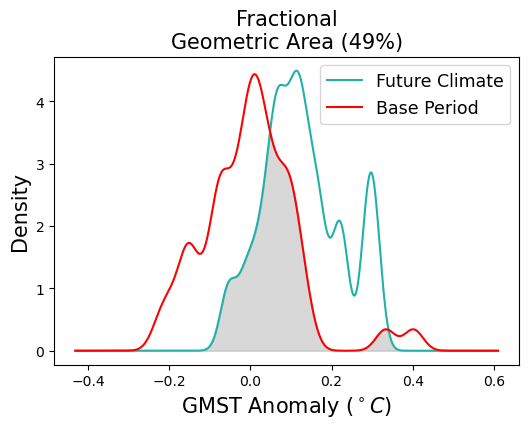

In [247]:

fig = plt.figure(figsize=(6, 4))
ax2 = fig.add_subplot(111)

ax2.plot(x_kde, kde_vals1, color='lightseagreen', label='Future Climate')
ax2.plot(x_kde, kde_vals2, color='red', label='Base Period')
ax2.fill_between(x_kde, 0, np.min(np.vstack([kde_vals1, kde_vals2]), axis=0),
                 color='gray', alpha=0.3)

ax2.set_title(f'Fractional\nGeometric Area ({fga_overlap:.0f}%)', fontsize=15)

ax2.legend(loc='upper right', fontsize=12.5)#, bbox_to_anchor=(1.6, 0.5))
ax2.set_xlabel('GMST Anomaly' + r' ($^\circ C$)', fontsize=15)
ax2.set_ylabel('Density', fontsize=15)


# FAR

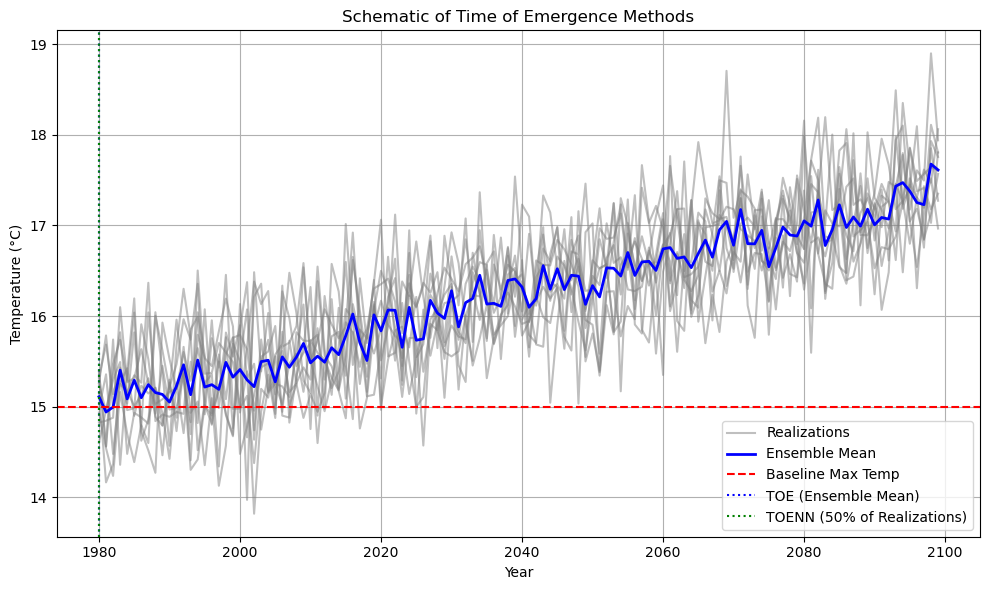

In [119]:
# Set the seed for reproducibility
np.random.seed(42)

# Define parameters
years = np.arange(1980, 2100)  # Years from 1980 to 2099
n_realizations = 10  # Number of realizations (climate model runs)
baseline_max_temp = 15  # Baseline maximum temperature (e.g., from 1980-1999)
warming_rate = 0.02  # Warming rate per year
natural_variability = 0.5  # Natural variability (standard deviation)

# Simulate decadal-mean temperatures for each realization
temperatures = np.zeros((n_realizations, len(years)))

for i in range(n_realizations):
    # Create a temperature time series with warming trend and variability
    temperatures[i] = baseline_max_temp + warming_rate * (years - 1980) + np.random.normal(0, natural_variability, len(years))

# Calculate ensemble mean and percentile values
ensemble_mean = np.mean(temperatures, axis=0)
ensemble_50th_percentile = np.percentile(temperatures, 50, axis=0)

# Find Time of Emergence (when ensemble mean exceeds baseline max)
toe_ensemble_mean = np.argmax(ensemble_mean > baseline_max_temp)

# Find ToENN (when more than 50% of realizations exceed baseline max)
toe_toenn = np.argmax(ensemble_50th_percentile > baseline_max_temp)

# Plot the results
plt.figure(figsize=(10, 6))

# Plot all realizations
for i in range(n_realizations):
    plt.plot(years, temperatures[i], color='gray', alpha=0.5, label='Realizations' if i == 0 else "")

# Plot ensemble mean
plt.plot(years, ensemble_mean, color='blue', label='Ensemble Mean', linewidth=2)

# Plot baseline max temperature
plt.axhline(baseline_max_temp, color='red', linestyle='--', label='Baseline Max Temp')

# Mark TOE for ensemble mean
plt.axvline(years[toe_ensemble_mean], color='blue', linestyle=':', label='TOE (Ensemble Mean)')

# Mark TOE for ToENN (50th percentile)
plt.axvline(years[toe_toenn], color='green', linestyle=':', label='TOENN (50% of Realizations)')

# Labels and legend
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.title('Schematic of Time of Emergence Methods')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


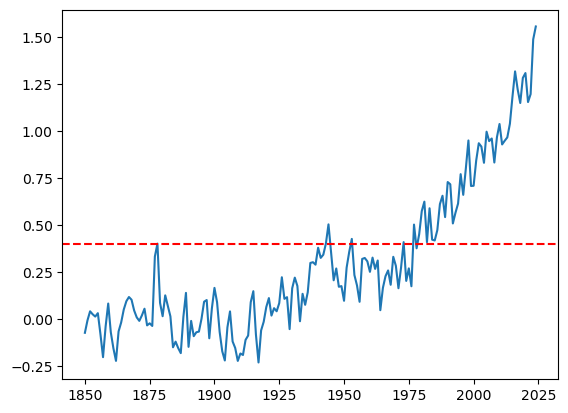

In [120]:
fig, ax = plt.subplots(1,1)
ax.plot(best_ds_smean.time.dt.year.values, best_ds_smean.values)
base_max = best_ds_smean.isel(time=slice(0,50)).max().values.item()
ax.axhline(base_max,  color='red', linestyle='--')

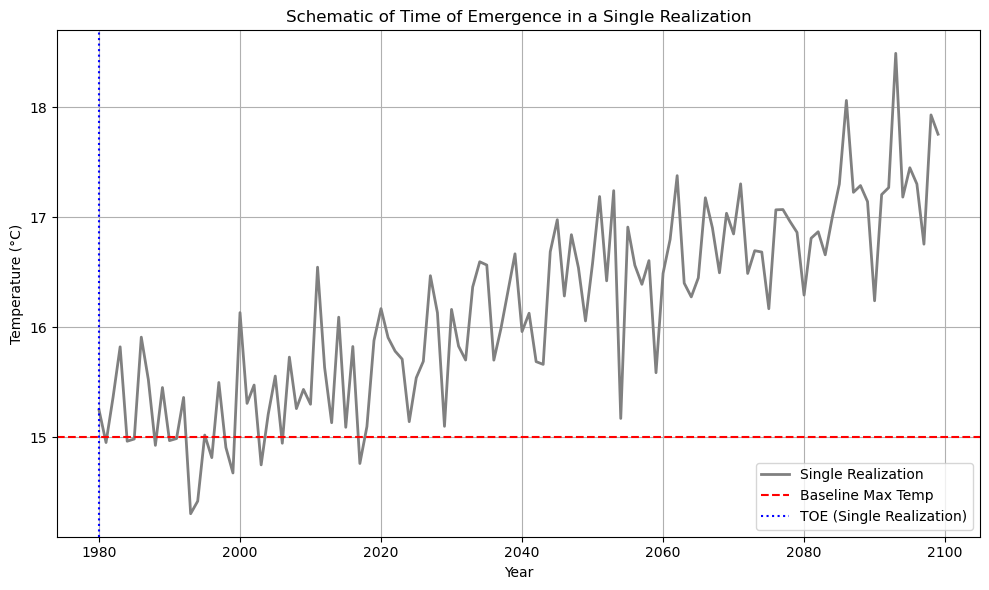

In [121]:


# Set the seed for reproducibility
np.random.seed(42)

# Define parameters
years = np.arange(1980, 2100)  # Years from 1980 to 2099
baseline_max_temp = 15  # Baseline maximum temperature (e.g., from 1980-1999)
warming_rate = 0.02  # Warming rate per year
natural_variability = 0.5  # Natural variability (standard deviation)

# Simulate a single realization of temperature with warming trend and variability
temperatures = baseline_max_temp + warming_rate * (years - 1980) + np.random.normal(0, natural_variability, len(years))

# Find the point of Time of Emergence (TOE) when temperature exceeds baseline maximum
toe_index = np.argmax(temperatures > baseline_max_temp)

# Plot the results
plt.figure(figsize=(10, 6))

# Plot the single realization of temperature
plt.plot(years, temperatures, color='gray', label='Single Realization', linewidth=2)

# Plot the baseline max temperature
plt.axhline(baseline_max_temp, color='red', linestyle='--', label='Baseline Max Temp')

# Mark TOE (when temperature exceeds baseline and stays above)
plt.axvline(years[toe_index], color='blue', linestyle=':', label='TOE (Single Realization)')

# Labels and legend
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.title('Schematic of Time of Emergence in a Single Realization')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [122]:
best_daily_ds = xr.open_dataset(
    '/g/data/w40/ab2313/time_of_emergence/best/Complete_TAVG_Daily_EqualArea.nc', 
chunks={'lat':-1, 'lon':-1, 'time':365})

In [123]:
new_time = xr.cftime_range(
    start=f'{int(best_daily_ds.year.values[0]):04d}-{int(best_daily_ds.month.values[0]):02d}-{int(best_daily_ds.day.values[0]):02d}',
    periods=len(best_daily_ds.time.values),
    freq='D'
)


In [124]:
new_time.shape, new_time[:5]

((52077,),
 CFTimeIndex([1880-01-01 00:00:00, 1880-01-02 00:00:00, 1880-01-03 00:00:00,
              1880-01-04 00:00:00, 1880-01-05 00:00:00],
             dtype='object', length=5, calendar='standard', freq='D'))

In [125]:
best_daily_ds_smean = best_daily_ds.temperature.mean(dim='map_points')#climate_utils.weighted_lat_lon_mean(best_daily_ds)

In [126]:
best_daily_ds_smean = best_daily_ds_smean.compute()

In [127]:
best_daily_ds_smean['time'] = new_time

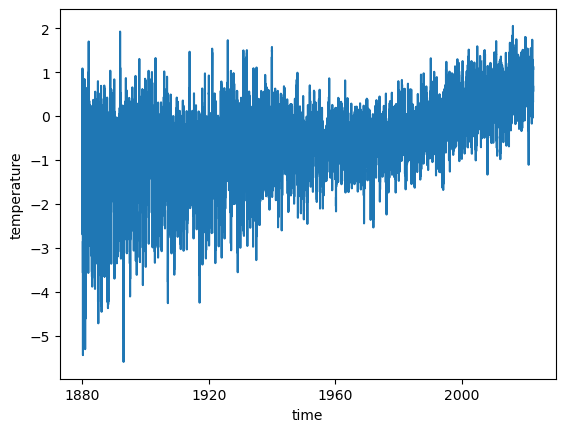

In [128]:
best_daily_ds_smean.plot()

In [129]:
daily_base_periods = ("1880", "1920")
best_daily_ds_smean_base = best_daily_ds_smean.sel(time=slice(daily_base_periods[0], daily_base_periods[1]))

In [130]:
base_average = best_daily_ds_smean_base.mean().values.item()
base_average

-1.0815659761428833

In [131]:
best_daily_ds_smean_base_anom = best_daily_ds_smean_base - base_average

In [132]:
best_daily_anom_ds = best_daily_ds_smean - base_average

In [133]:
threshold = 1

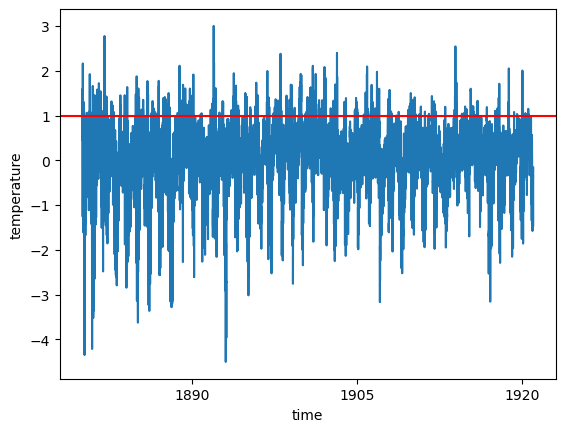

In [134]:
fig, ax = plt.subplots(1,1)
best_daily_ds_smean_base_anom.plot(ax=ax)
ax.axhline(threshold, color='red')

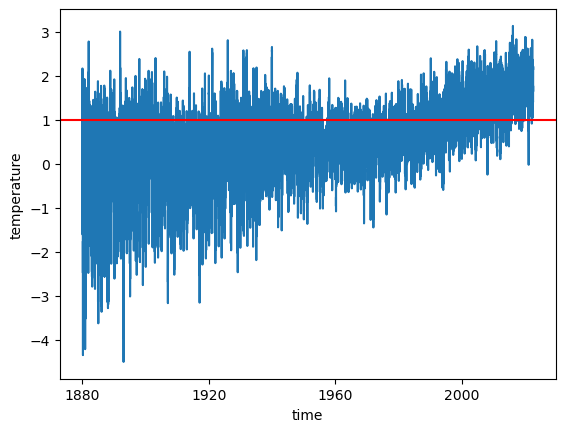

In [135]:
fig, ax = plt.subplots(1,1)
best_daily_anom_ds.plot(ax=ax)
ax.axhline(threshold, color='red')

In [136]:
# base_p99_da = best_daily_ds_smean_base.qunatile(0.999, dim='time')

In [137]:
(best_daily_ds_smean_base_anom>best_daily_anom_ds)

<xarray.DataArray 'temperature' (time: 14975)> Size: 15kB
False False False False False False ... False False False False False False
Coordinates:
  * time     (time) object 120kB 1880-01-01 00:00:00 ... 1920-12-31 00:00:00

In [138]:
num_in_base = xr.where(best_daily_ds_smean_base_anom>threshold, 1, 0).sum().values.item()
num_in_base

913

In [139]:
base_length = best_daily_ds_smean_base_anom.time.shape[0]
base_length

14975

In [140]:
p0 = num_in_base/base_length
p0

0.06096828046744574

In [141]:
window_length = 20*365
window_length

7300

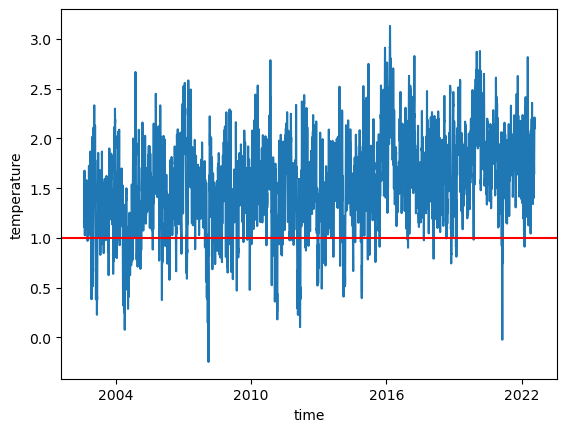

In [142]:
fig, ax = plt.subplots(1,1)
best_daily_anom_ds.isel(time=slice(-window_length, None)).plot(ax=ax)
ax.axhline(threshold, color='red')

In [143]:
above_pr_sum = xr.where(best_daily_anom_ds>threshold, 1, 0).rolling(time=window_length).sum()

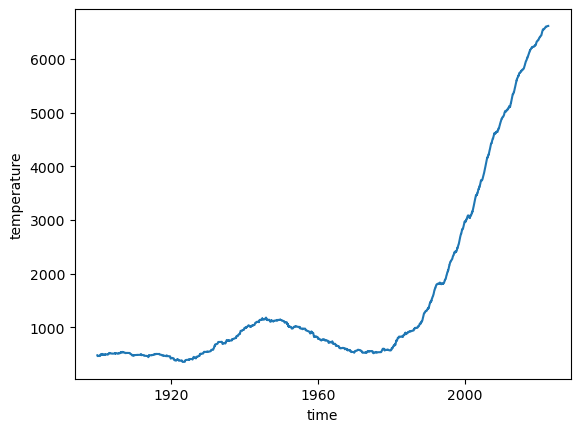

In [144]:
above_pr_sum.plot()

In [145]:
p1 = above_pr_sum/window_length

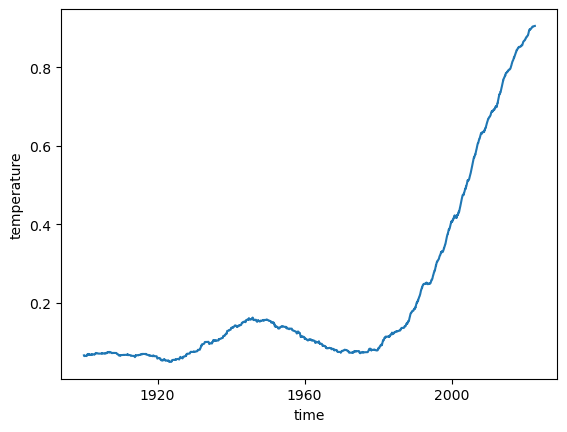

In [146]:
p1.plot()

In [147]:
pr_da = p1/p0

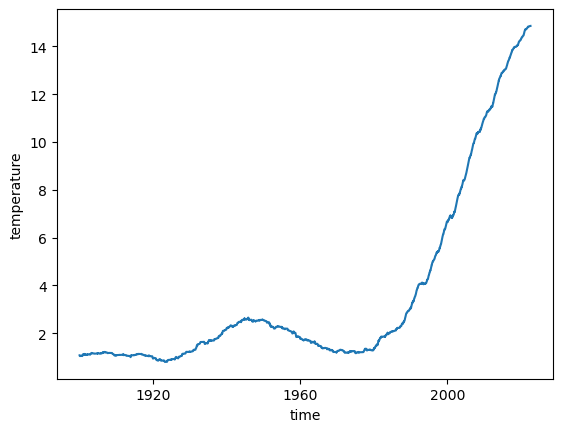

In [148]:
pr_da.plot()

In [149]:
far2_da = 1-1/pr_da
far_da = 1 - p0/p1

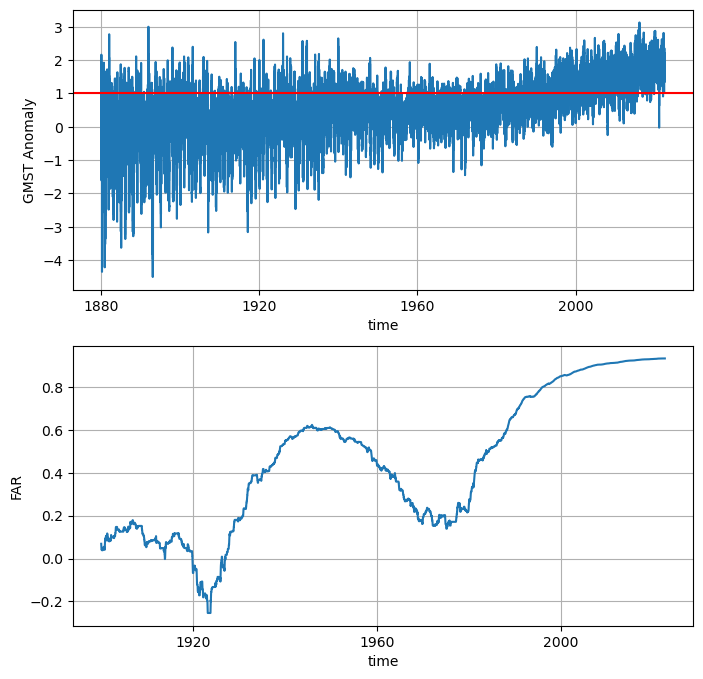

In [150]:
fig, (ax, ax2) = plt.subplots(2,1, figsize=(8, 8))
best_daily_anom_ds.plot(ax=ax)
far_da.plot(ax=ax2)

ax.axhline(threshold, color='red')

ax.set_ylabel('GMST Anomaly')
ax2.set_ylabel('FAR')

ax.grid(True)
ax2.grid(True)

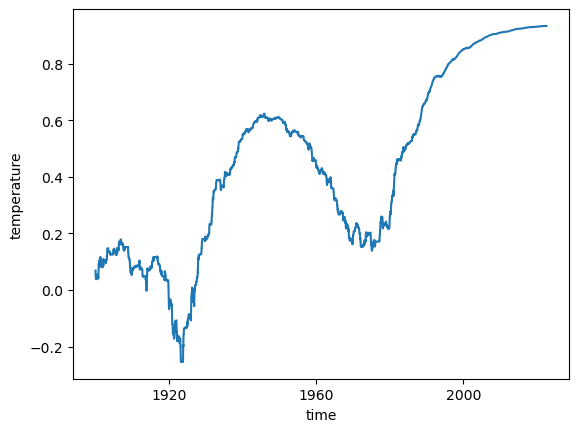

In [151]:
far2_da.plot()

In [152]:
# daily_base_periods = (1880, 1820)

In [153]:
# baser_period = best_daily_ds.where()